# Problem Statement
___

`Situation`
* Alan Walker is a single , aspiring , working mid-profession currently living in Ames City. Like many of his peers in the working profession archetype, he is at a crossroad where he is looking to sell off his current house, so that he have sufficient capital to relocate to a bigger house to establish his new and impending growing family.

`Complication`
* Facing the same dilemma of those in the young working profession archtype who is aspiring to start their own family, they often want to **optimise their selling price** of their current house so as to lessen the finanicial burden with major activities not exlcuding potential expenses from the forthcoming nuptials , welcoming of their newborn , costs affliated to purchasing new house, etc.

`Question (Problem Statement)`
* As a specialist in an established property and interior design team in Millenium Walk, our housing prediction models aim to provide advise to house seller on which features to optimise within their renovation spending budget so that they are able to to optimise their selling price between 5% to 10% from their baseline Sale Price.

# Quick Fact on AMES City
___

* State : Iowa
* Population : 66,427
* Major Race ; White (81.3%)
* Median value of housing :  205,900USD
* Owner-occupied housing unit rate : 40.7%
* Median monthly owner cost : 577USD
* Median gross rent : 930USD

* Key Facilities and Nature Park
    - Iowa State University
    - Ada Hayden Heritage Park
    - Community Gardens on South Garden
    - Nutty Woods
    - Brookside Park
* Source
    - [US Census Bereau](https://www.census.gov/quickfacts/amescityiowa)
    - [City of Ames](https://www.cityofames.org/home)

# Content Summary for notebook
___

- 0.0 Libraries Import & General Function
- 1.0 Dataset Exploration, Visualisation & Preprocessing
- 2.0 Feature Engineering
- 3.0 Modelling
- 4.0 Modelling on top 10 feature
- 5.0 Preparing function and dataset for Kaggle Submission
- 6.0 Using optimised model to advise client (Alan Walker's Archetype) features to optimise given limited budget and its qualitative impact on Sale Price.
- 7.0 Conclusion
- 8.0 Credit and Resources

# 0.0 Import libraries
___

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split , cross_validate , cross_val_score , GridSearchCV
from sklearn.linear_model import LinearRegression , Lasso , Ridge , ElasticNet
from sklearn.linear_model import LassoCV , RidgeCV , ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [2]:
plt.style.use('ggplot')
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 0.5 Function Creation
___

In [3]:
def null_plot(df):
    x = df.isnull().sum().sort_values(ascending = True).tail(15)

    plt.figure(figsize = (9,6))
    x.plot(kind = 'barh' , color = 'lightblue')

    plt.xlabel('Count')
    plt.ylabel('Features')
    plt.title('Missing Count for Top 15 Features');

In [4]:
def EDA_subplot(nrows , ncols , feature_list , df):

    plt.figure(figsize = (ncols*10 , nrows*8))
    for i in range(len(feature_list)):
        plt.subplot(nrows , ncols , i+1)
        
        # If numeric data feature , plot scatter
        if pd.api.types.is_numeric_dtype(df[feature_list[i]]):
        
            sns.scatterplot(data = df,
                            x = feature_list[i],
                            y = 'Log SalePrice')
            plt.title(f'{feature_list[i]} vs Sale Price')
        
        # If non - numeric data feature , plot boxplot
        else:
            sns.boxplot(data = df,
                        x = feature_list[i],
                        y = 'Log SalePrice',
                        width = 0.5)
            plt.title(f'{feature_list[i]} vs Sale Price')
            plt.xticks(rotation = 90)     

In [5]:
def minority_feature_dummify(df , col_name):
    print('Before Dummify:')
    print('=======================')
    print(df[col_name].value_counts())
    
    for index , data in enumerate(df[col_name]):
        if pd.isna(data):
            df.loc[index , col_name] = -1
        else:
            df.loc[index , col_name] = 1
    
    print('                       ')
    print('After Dummify:')
    print('=======================')
    print(df[col_name].value_counts())

In [6]:
def eval_pred(model , X_train, X_val):
    
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    scores = {'Training MAE': mean_absolute_error(y_train , train_pred),
              'Validation MAE' : mean_absolute_error(y_val , val_pred),
              'Training RMSE': mean_squared_error(y_train , train_pred , squared = False),
              'Validation RMSE' : mean_squared_error(y_val , val_pred , squared = False),
              'Training Model Score' : model.score(X_train, y_train),
              'Validation Model Score' : model.score(X_val , y_val)}
    
    
    df_score = pd.DataFrame({'Score' : scores.values()}, 
                              index = scores.keys())
    return df_score


def error_percent(score):
    rmse = score.loc['Validation RMSE', 'Score']
    rmse_error_percent = round(((np.exp(rmse)-1)*100),2)
    mean = df_train["SalePrice"].mean()
    
    return(round(rmse,4) , round(rmse_error_percent , 2) , round(mean , 2))

In [7]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [8]:
def residual_plot(y_val , y_pred , label):

    model_residual = y_val - y_pred

    sns.scatterplot(x = y_pred,
                    y = model_residual,
                    label = label + ' residual')

    plt.xlabel('Predicted Value' , fontsize = 12)
    plt.ylabel('Standardised Residuals' , fontsize = 12)
    plt.hlines(y = 0 , xmin = min(y_pred) , xmax = max(y_pred) , color = 'black' , linestyles = '--')
    plt.legend()
    plt.title('Residual Plot for ' + label  , fontsize = 20)

In [9]:
def regplot(y_val , y_pred , label):

    sns.scatterplot(x = y_pred,
                    y = y_val)
    
    sns.lineplot(x = [min(y_pred) ,max(y_pred)],
                 y = [min(y_pred) ,max(y_pred)],
                 color = 'black',
                 linewidth = 3,
                 linestyle = '--')

    plt.xlabel('Predicted Value' , fontsize = 12)
    plt.ylabel('True Value' , fontsize = 12)
    plt.title(label + ' Model Estimation'  , fontsize = 20)

In [10]:
def coef_plot(model):
    
    if 'RandomForest' in str(model):
        df = pd.DataFrame(index= X_train.columns,
                    data = {'coef_' :model.feature_importances_})
        df = df.sort_values(by = 'coef_' , ascending = True).tail(15)
        df.plot(kind = 'barh' , figsize = (8,6))
        plt.title('Top 15 Feature Importance')
        
    else:
        df = pd.DataFrame(index= X_train.columns,
                          data = {'coef_' :model.coef_})
        df = df.sort_values(by = 'coef_' , ascending = True).tail(15)
        df.plot(kind = 'barh' , figsize = (8,6))
        plt.title('Top 15 Feature Importance')

# 1.0 Exploring Datasets
___

The aim of Section 1.0 is to have an overview of the dataset distribution for most of the features and have a broad understanding of the variables in each features. We will also check for outliers ,datatype accuracy and clean them out prior to the feature engineering studies in Section 2.0.

- 1.1 Dataset Overview
- 1.2 Exploring Null Values
- 1.3 Exploring Duplicates
- 1.4 General Overview of Features
    - 1.4a General Overview of Sales Distribution and Data Visualisation
    - 1.4b General Overview for Date Features
    - 1.4c General Overview for Basement Features    
    - 1.4d General Overview for Garage Features
    - 1.4e General Overview for Heating & Utilities Related
    - 1.4f General Overview for Porch Features
    - 1.4g General Overview for House Ext. Features    
    - 1.4h General Overview for House Int. Features
    - 1.4i General Overview for Land Plot Features
    - 1.4j General Overview for House Surronding Features
    - 1.4k General Overview on House Type and Functionality
- 1.5 Standardising Column Name
- 1.6 Pre-processing Missing Value
- 1.7 Pre-processing Outlier Value

In [11]:
df_sub = pd.read_csv('datasets/sample_sub_reg.csv')
df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')

In [12]:
df_train.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

In [13]:
df_train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [15]:
df_train.describe()

Id           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2051.000000  2.051000e+03  2051.000000   1721.000000    2051.000000   
mean   1474.033642  7.135900e+08    57.008776     69.055200   10065.208191   
std     843.980841  1.886918e+08    42.824223     23.260653    6742.488909   
min       1.000000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     753.500000  5.284581e+08    20.000000     58.000000    7500.000000   
50%    1486.000000  5.354532e+08    50.000000     68.000000    9430.000000   
75%    2198.000000  9.071801e+08    70.000000     80.000000   11513.500000   
max    2930.000000  9.241520e+08   190.000000    313.000000  159000.000000   

       Overall Qual  Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  \
count   2051.000000   2051.000000  2051.000000     2051.000000   2029.000000   
mean       6.112140      5.562165  1971.708922     1984.190151     99.695909   
std        1.426271      1.104497    30.177889       21.036250    174.963129   
min        1.000000      1.000000  1872.000000     1950.000000      0.000000   
25%        5.000000      5.000000  1953.500000     1964.500000      0.000000   
50%        6.000000      5.000000  1974.000000     1993.000000      0.000000   
75%        7.000000      6.000000  2001.000000     2004.000000    161.000000   
max       10.000000      9.000000  2010.000000     2010.000000   1600.000000   

       ...  Wood Deck SF  Open Porch SF  Enclosed Porch   3Ssn Porch  \
count  ...   2051.000000    2051.000000     2051.000000  2051.000000   
mean   ...     93.833740      47.556802       22.571916     2.591419   
std    ...    128.549416      66.747241       59.845110    25.229615   
min    ...      0.000000       0.000000        0.000000     0.000000   
25%    ...      0.000000       0.000000        0.000000     0.000000   
50%    ...      0.000000      27.000000        0.000000     0.000000   
75%    ...    168.000000      70.000000        0.000000     0.000000   
max    ...   1424.000000     547.000000      432.000000   508.000000   

       Screen Porch    Pool Area      Misc Val      Mo Sold      Yr Sold  \
count   2051.000000  2051.000000   2051.000000  2051.000000  2051.000000   
mean      16.511458     2.397855     51.574354     6.219893  2007.775719   
std       57.374204    37.782570    573.393985     2.744736     1.312014   
min        0.000000     0.000000      0.000000     1.000000  2006.000000   
25%        0.000000     0.000000      0.000000     4.000000  2007.000000   
50%        0.000000     0.000000      0.000000     6.000000  2008.000000   
75%        0.000000     0.000000      0.000000     8.000000  2009.000000   
max      490.000000   800.000000  17000.000000    12.000000  2010.000000   

           SalePrice  
count    2051.000000  
mean   181469.701609  
std     79258.659352  
min     12789.000000  
25%    129825.000000  
50%    162500.000000  
75%    214000.000000  
max    611657.000000  

[8 rows x 39 columns]

### 1.1 Dataset overview
___

In [16]:
print('Train data shape: ' , df_train.shape)
print('Train data dim: ' , df_train.ndim)
print('Train data size: ' , df_train.size)
print('Test data shape: ' , df_test.shape)
print('Test data dim: ' , df_test.ndim)
print('Test data size: ' , df_test.size)

Train data shape:  (2051, 81)
Train data dim:  2
Train data size:  166131
Test data shape:  (878, 80)
Test data dim:  2
Test data size:  70240


### 1.2 Exploring Null Value
___

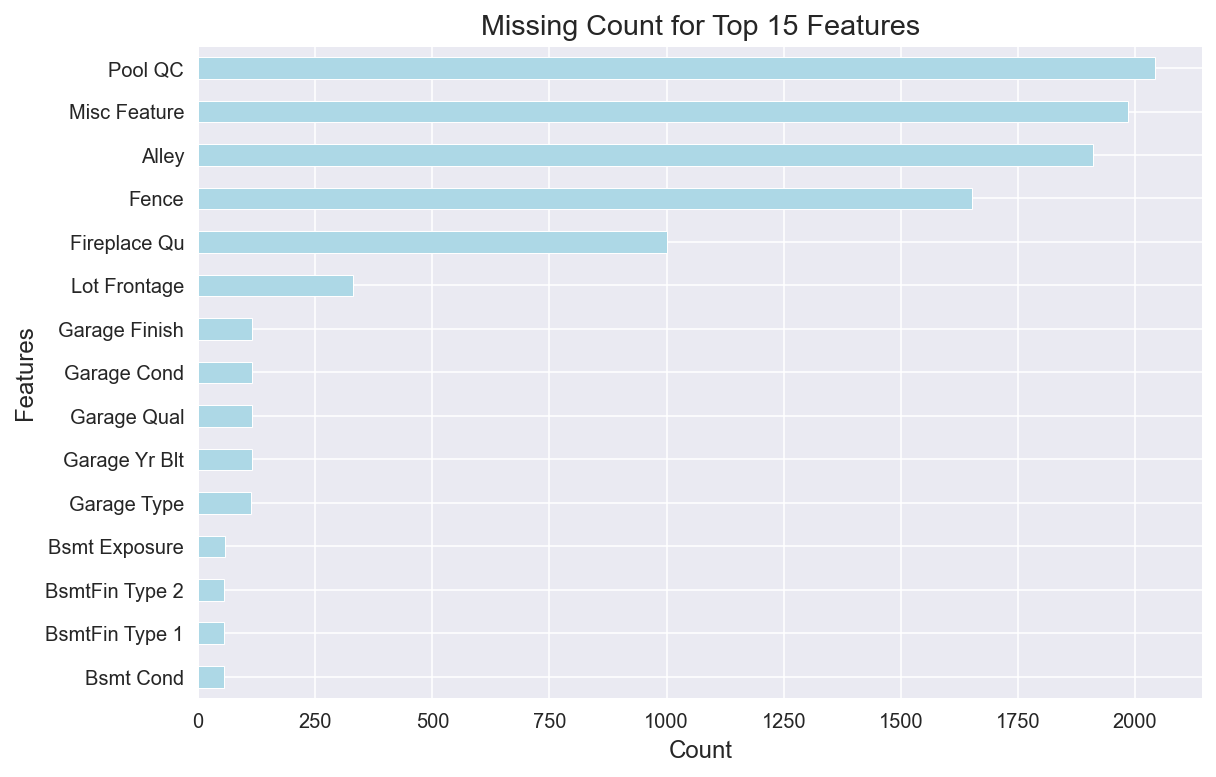

In [17]:
# Visualing Null Value Count for Features

null_plot(df_train)

### 1.3 Exploring Duplicates
___

In [18]:
df_train.duplicated().sum()

0

### 1.4  General Overview of Numeric and Non-numeric features
___

In [19]:
# Finding Numeric Features
numeric_list = []
for col_name , data in df_train.items():
    if pd.api.types.is_numeric_dtype(data):
        numeric_list.append(col_name)

print(f'No. of Numeric Features : {len(numeric_list)}')
print(numeric_list)

No. of Numeric Features : 39
['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice']


In [20]:
# Finding Categorical Features
cat_list = []
for col_name , data in df_train.items():
    if not pd.api.types.is_numeric_dtype(data):
        cat_list.append(col_name)

print(f'No. of Categorical Features : {len(cat_list)}')        
print(cat_list)

No. of Categorical Features : 42
['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature', 'Sale Type']


### 1.4a General Overview of Sales Distribution and Data Visualisation (For Relation & Outliers)
___
Since the Log of the SalePrice give a better normal distribution , we will be using that for subsequent comparison against other features

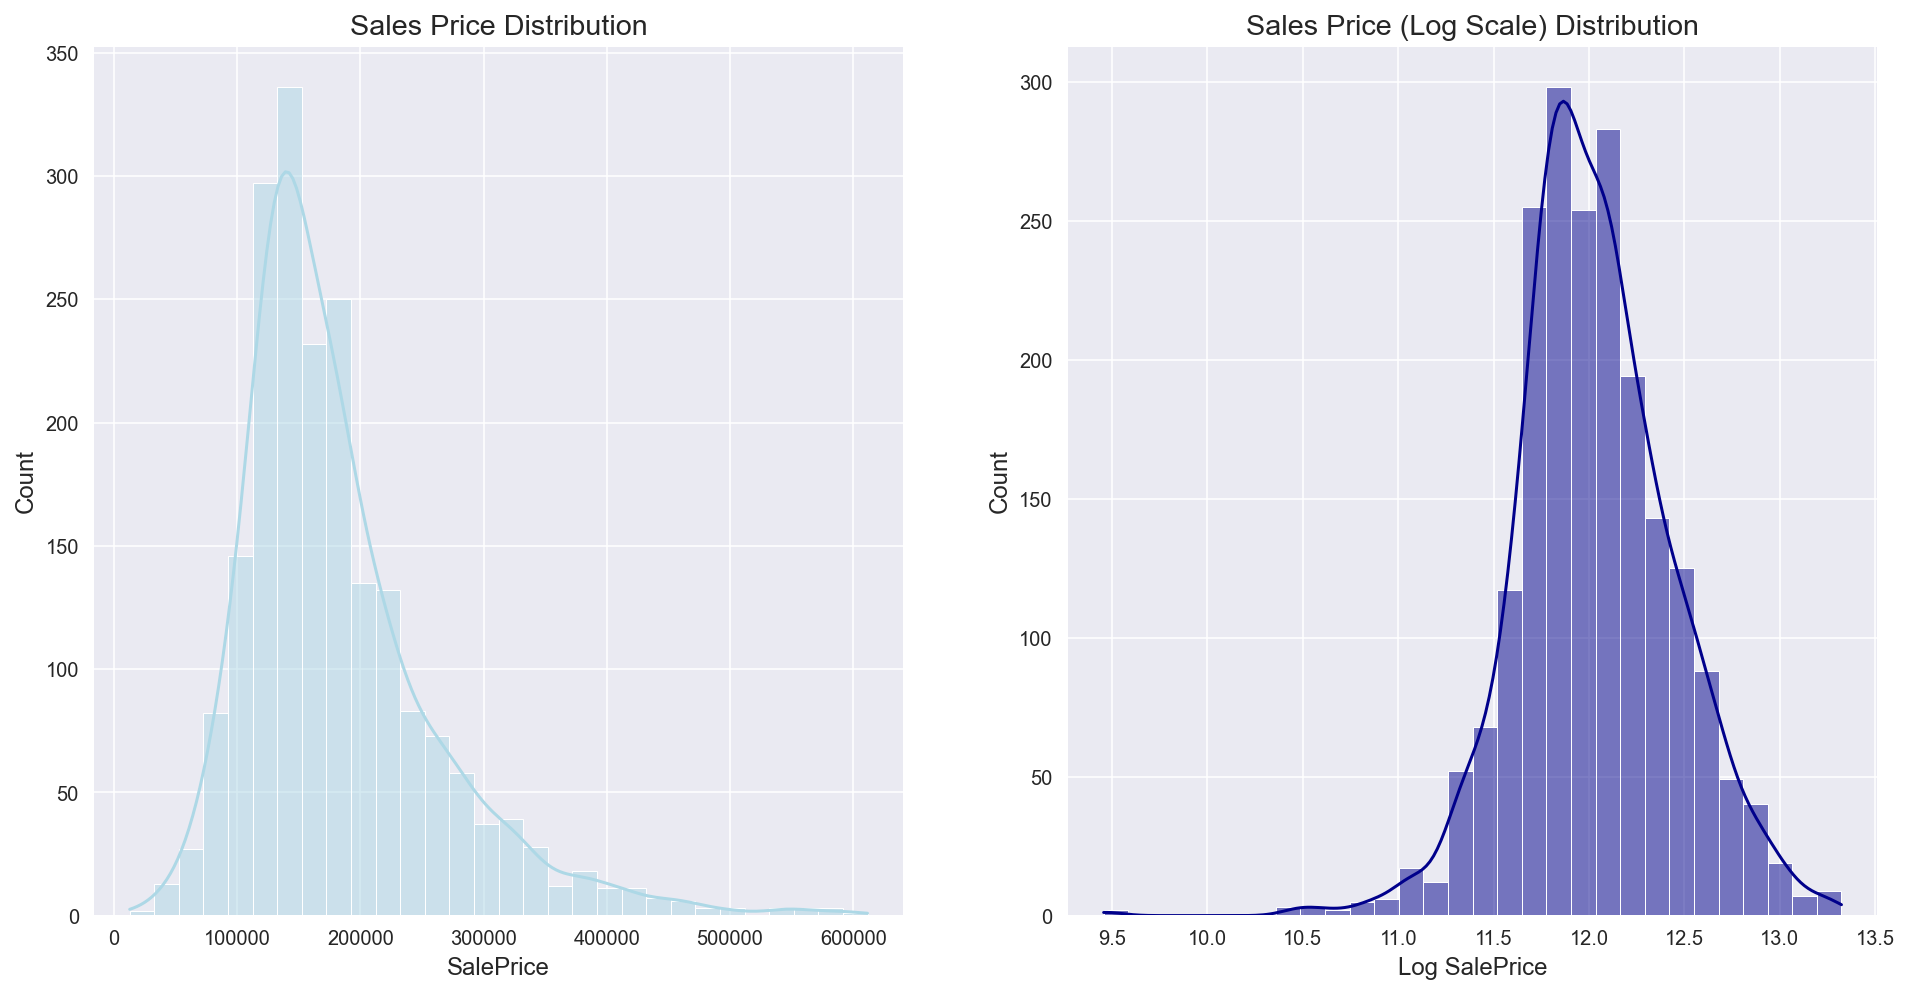

In [21]:
plt.figure(figsize = (16,8))

# Sales Price Distribution
plt.subplot(1,2,1)
sns.histplot(data = df_train,
             x = 'SalePrice',
             stat = 'count',
             color = 'lightblue',
             bins = 30,
             kde = True)
plt.title('Sales Price Distribution')

# Log Sales Price Distribution

df_train['Log SalePrice'] = np.log(df_train['SalePrice']) # Create new column for Log value of SalePrice

plt.subplot(1,2,2)
sns.histplot(data = df_train,
             x = 'Log SalePrice',
             stat = 'count',
             color = 'darkblue',
             bins = 30,
             kde = True)
             
plt.title('Sales Price (Log Scale) Distribution');

### 1.4b General Overview on Date Features
___

- Created a feature called Building Age =  Yr Sold - Year Built
- Base on Date features , the year sold between 2006 to 2010 seem fairly consistent for the sales price. Except the outlier , there are no special surge in sales price for house sold in later years

- House built more recently generally is able to be sold at a higher price. 

In [22]:
# Create New Feature for Building Age : Time between last built or modified to sold

for i in range(len(df_train)):
    if df_train['Year Remod/Add'][i] > df_train['Year Built'][i]:
        
        df_train['Building Age'] = df_train['Yr Sold'] -  df_train['Year Remod/Add']
    else:
        
        df_train['Building Age'] = df_train['Yr Sold'] -  df_train['Year Built']    

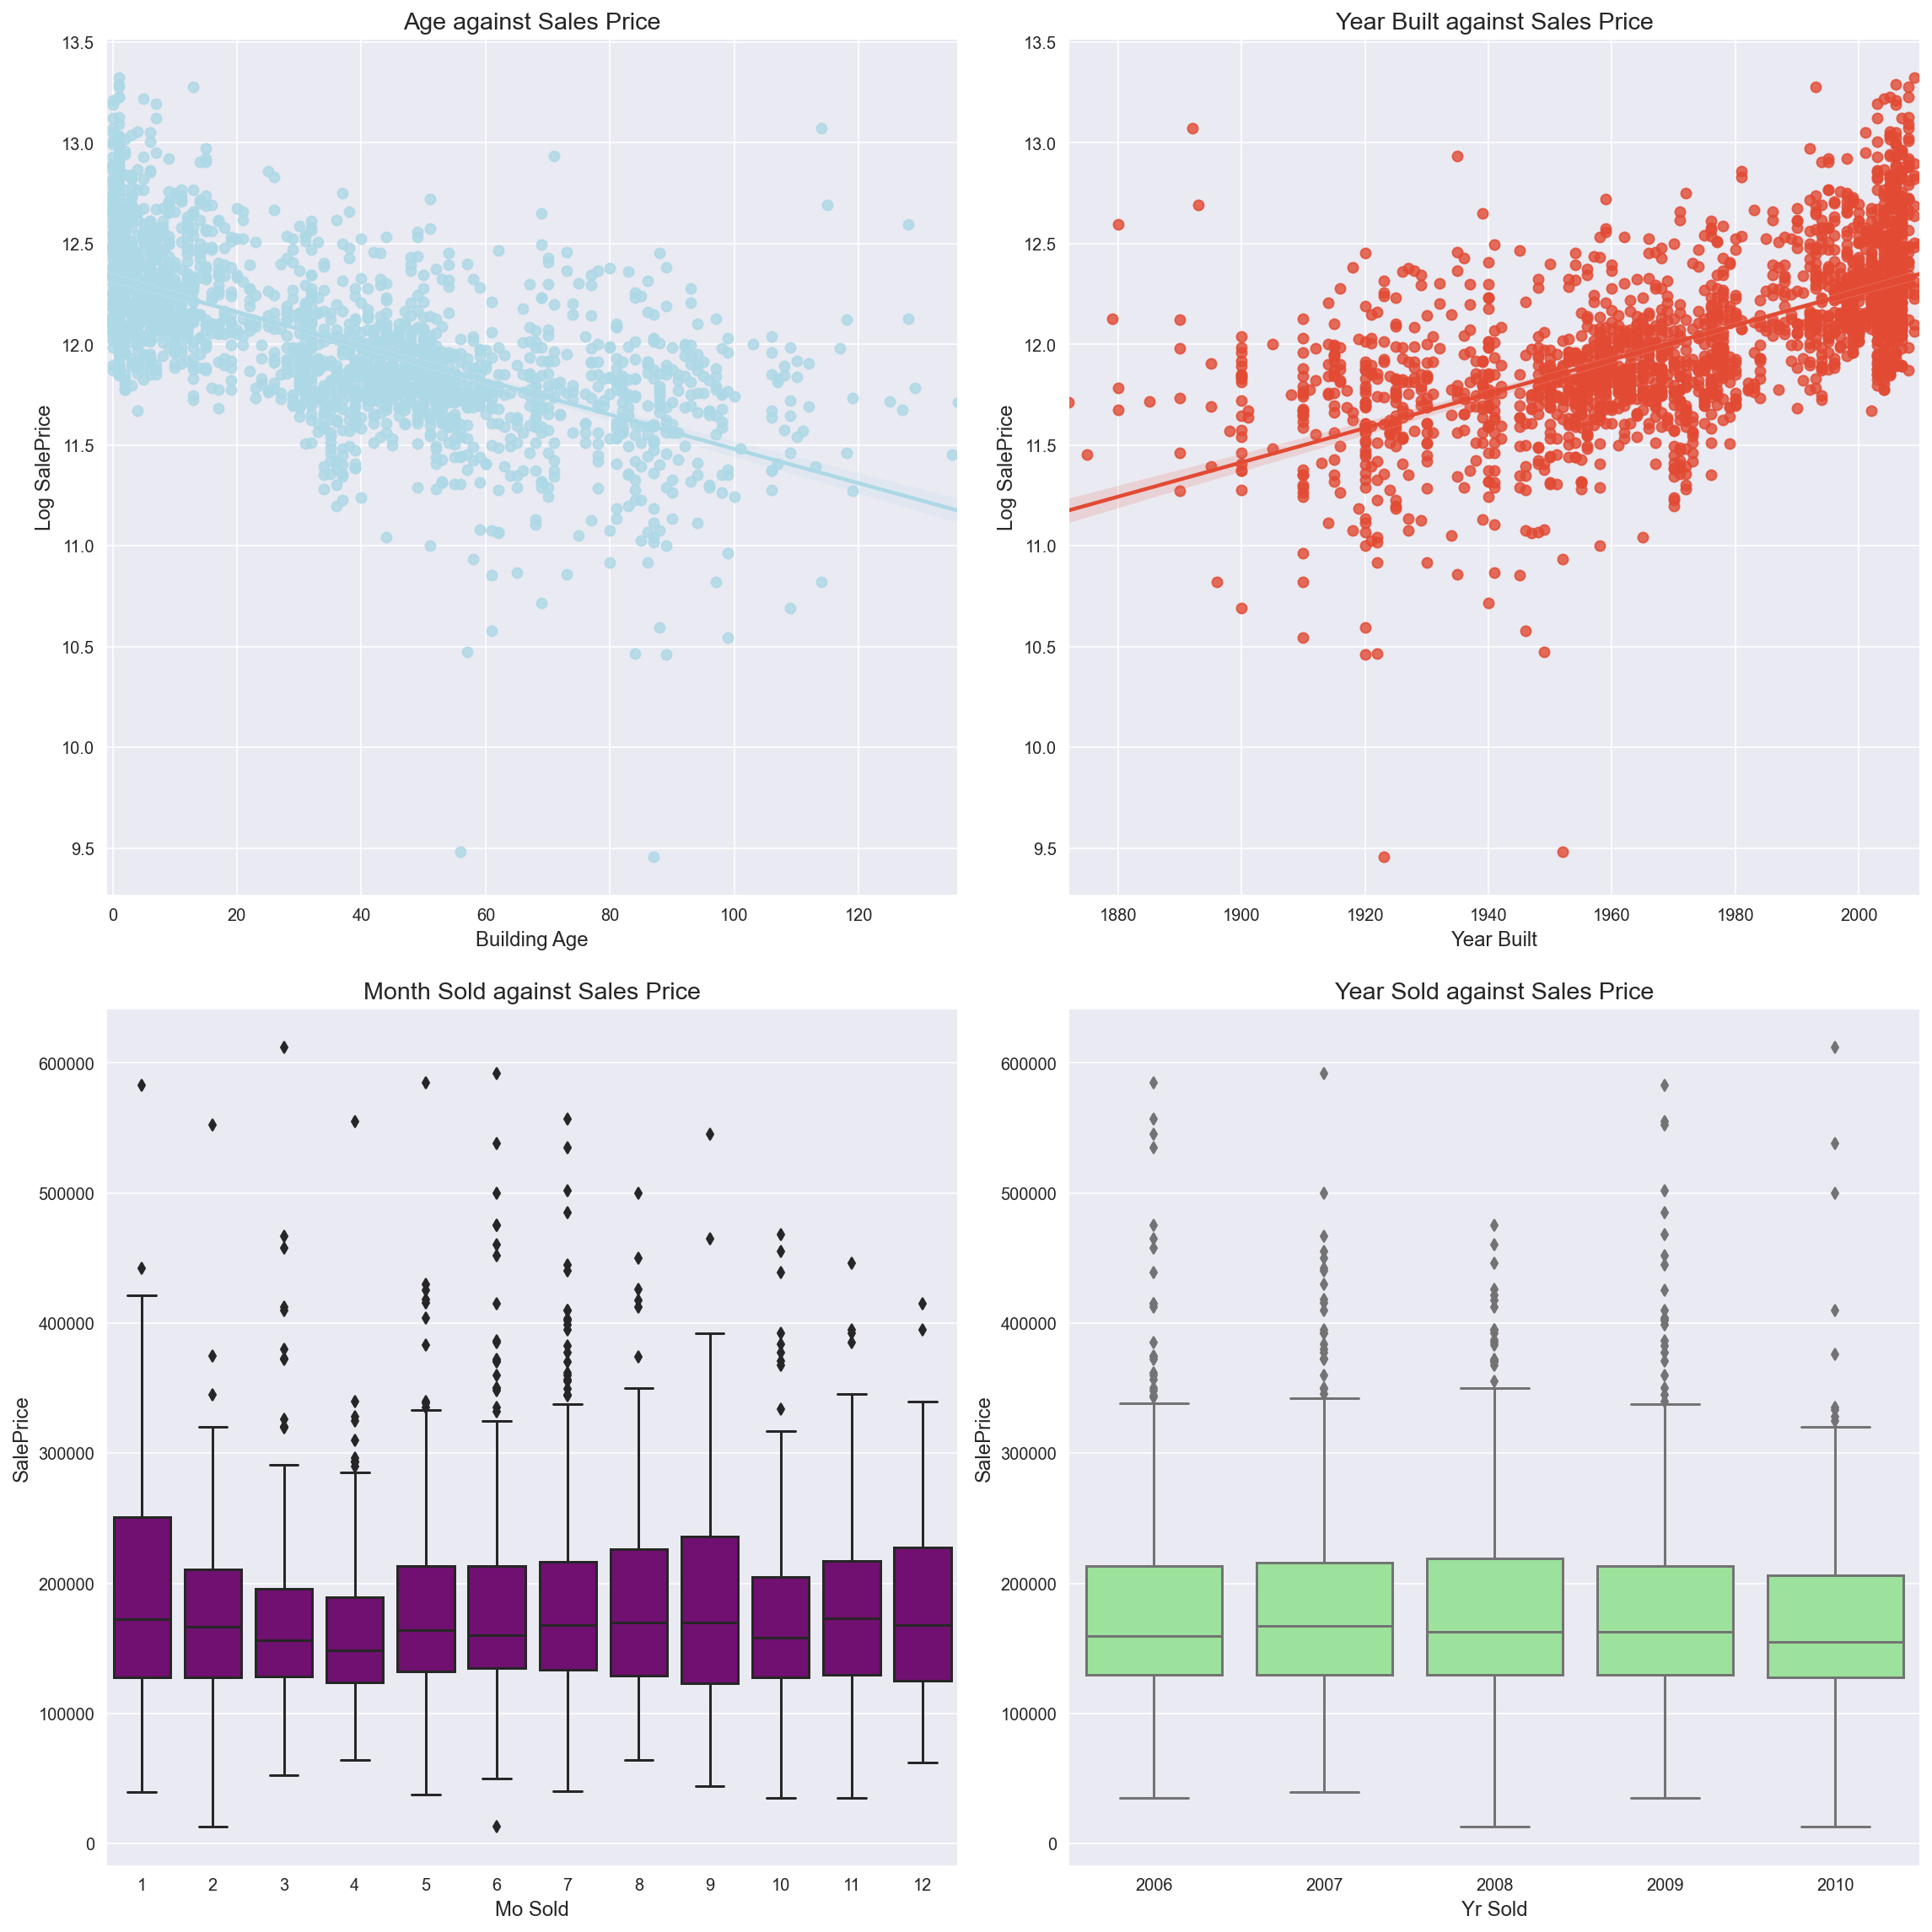

In [23]:
plt.figure(figsize = (16,16))



# Plot 1 : Age against Sales Price
plt.subplot(2,2,1)
sns.regplot(data = df_train,
            x = 'Building Age',
            y = 'Log SalePrice',
            color = 'lightblue')
plt.title('Age against Sales Price')

# Plot 2 : year Built against Sales Price
plt.subplot(2,2,2)
sns.regplot(data = df_train,
            x = 'Year Built',
            y = 'Log SalePrice')
plt.title('Year Built against Sales Price')


# Plot 3 : Month Sold against Sales Price
plt.subplot(2,2,3)
sns.boxplot(data = df_train,
            x = 'Mo Sold',
            y = 'SalePrice',
            color = 'purple');
plt.title('Month Sold against Sales Price')


# Plot 3 : Year Sold against Sales Price
plt.subplot(2,2,4)
sns.boxplot(data = df_train,
            x = 'Yr Sold',
            y = 'SalePrice',
            color = 'lightgreen')
plt.title('Year Sold against Sales Price')

plt.tight_layout(h_pad = 2)

### 1.4c General Overview on Basement Features
___

- Total 11 features for Basement : 
    - 6 numeric features : [BsmtFin SF 1, BsmtFin SF 2 , Bsmt Unf SF , Total Bsmt SF , Bsmt Full Bath , Bsmt Half Bath]
    - 4 non-numeric ordinal features : ['Bsmt Qual', 'Bsmt Cond' , 'BsmtFin Type 1' , 'BsmtFin Type 2']
    - 1 non-numeric , non-ordinal features : ['Bsmt Exposure']
- Excellent and Good Bsmt quality typically fetch a higher price.
- Random outliers observed in Total Bsmt SF , BSMT

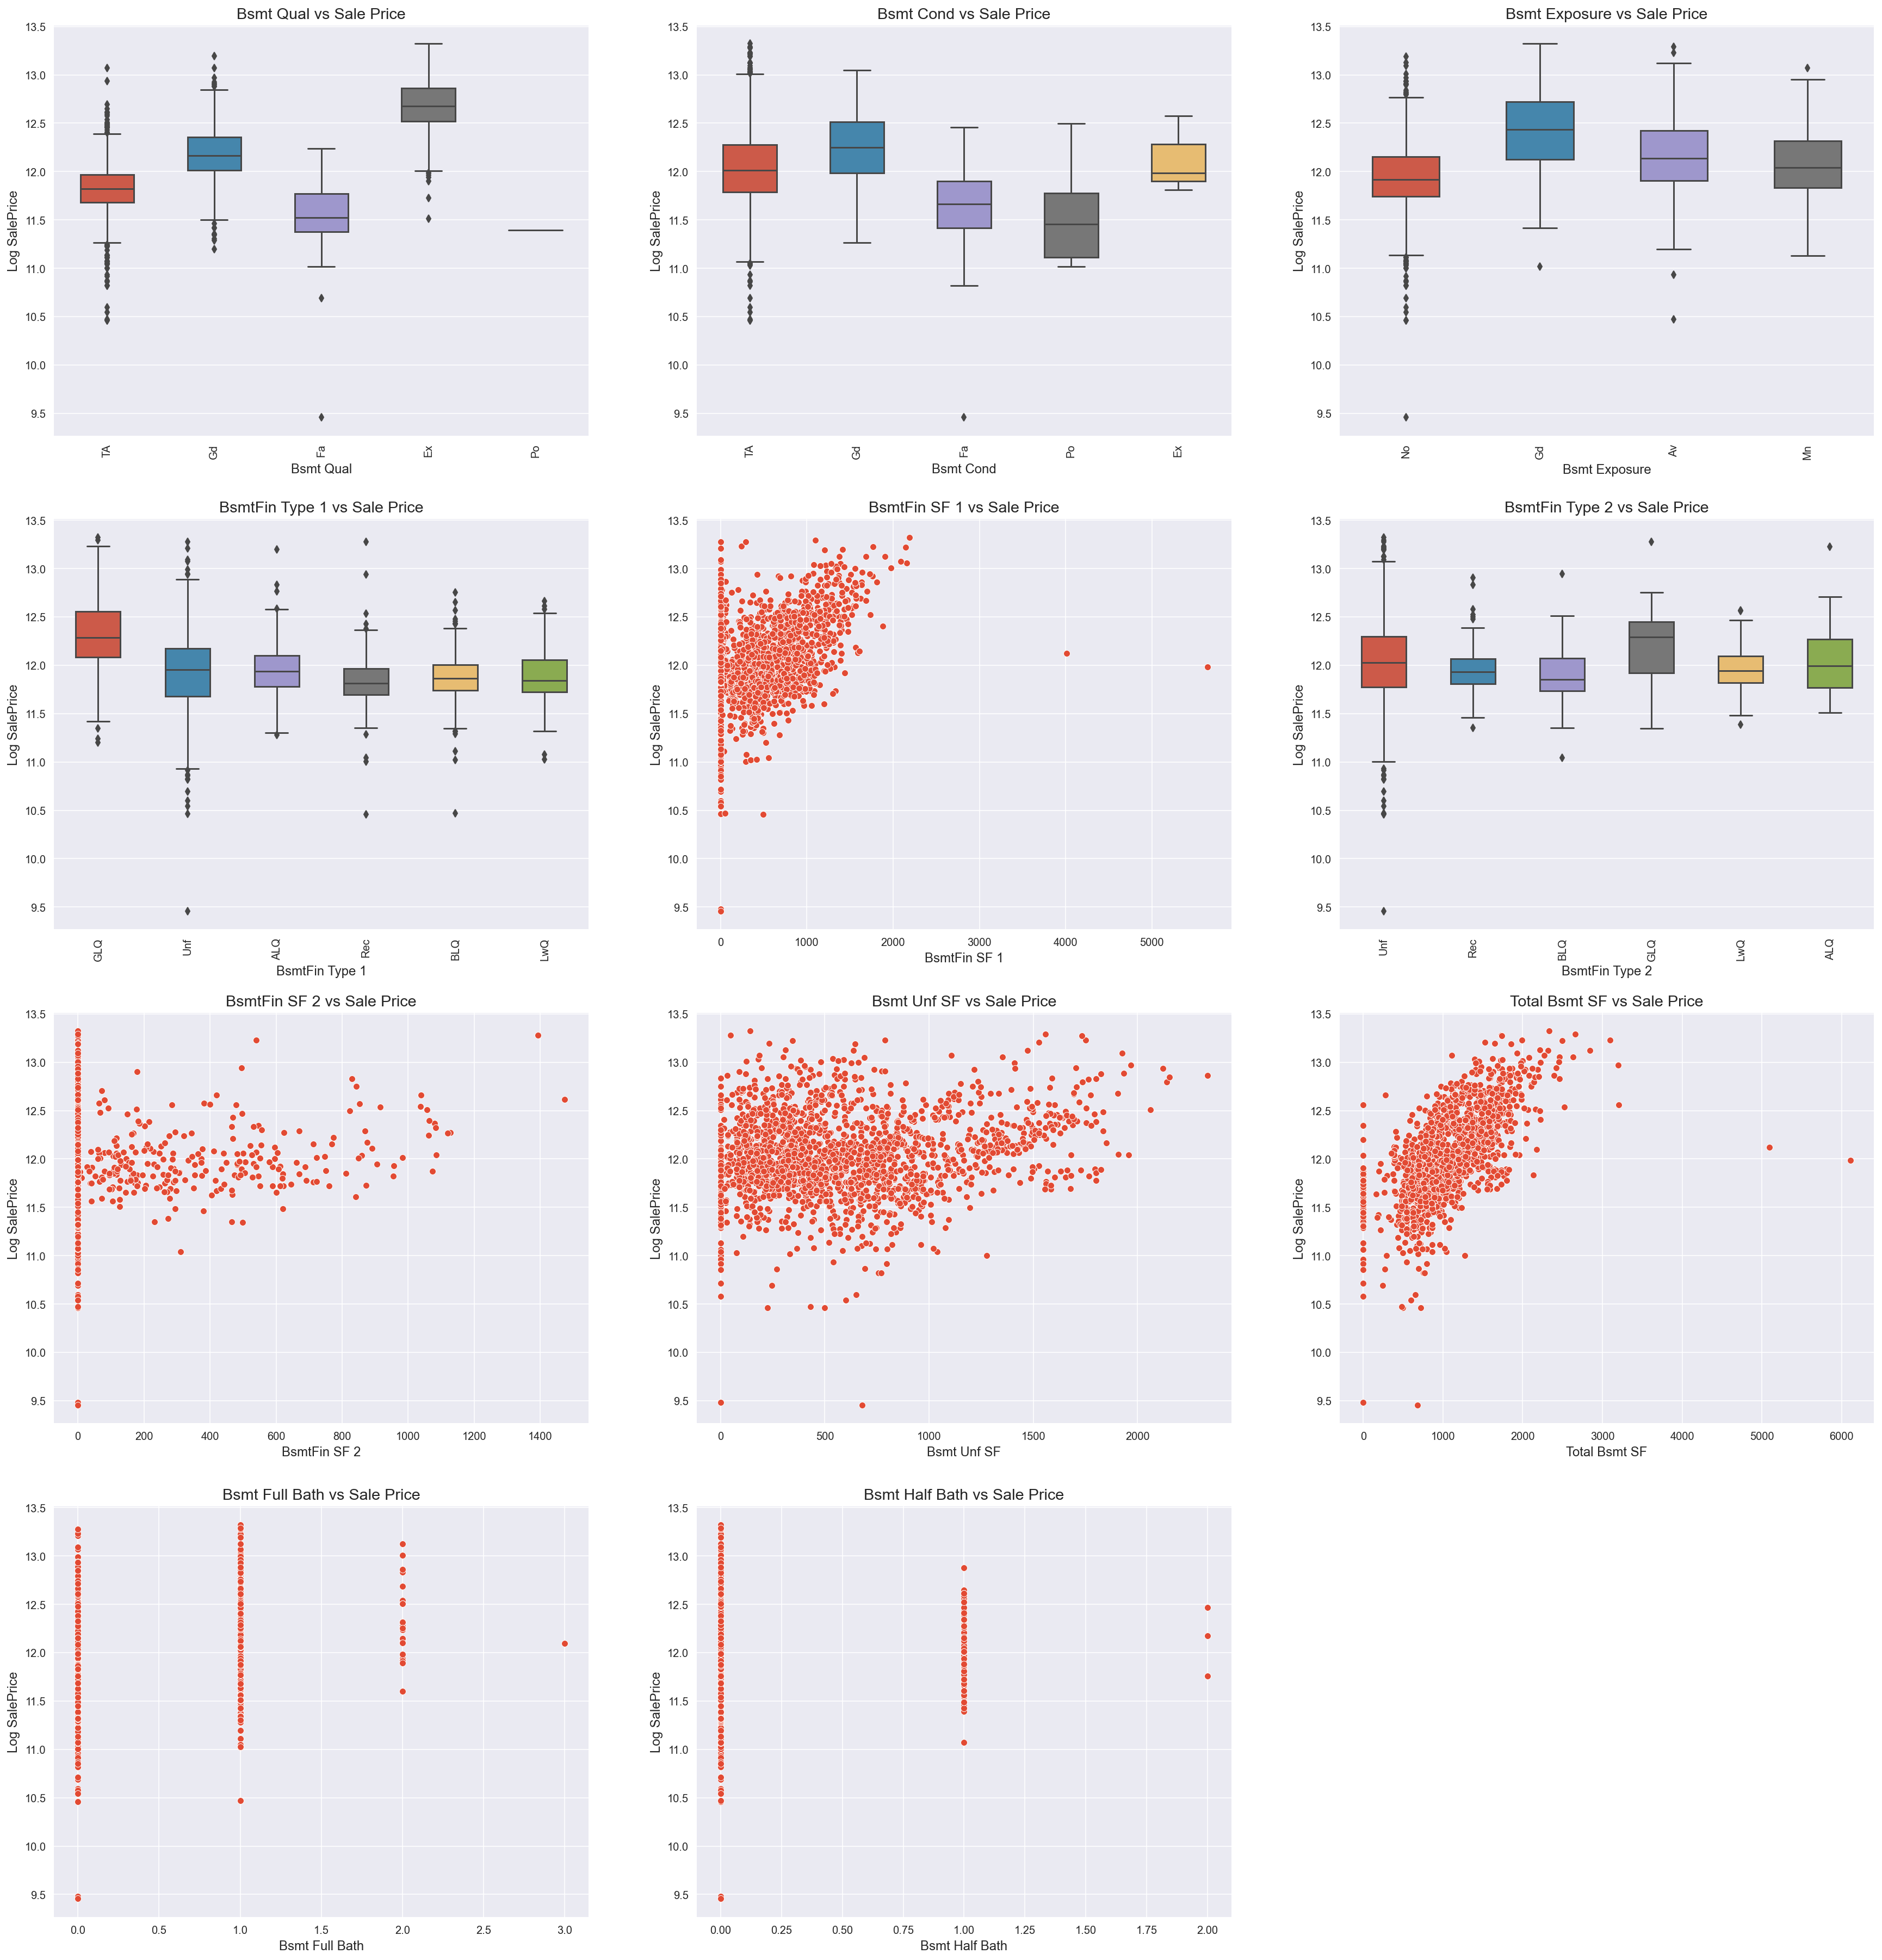

In [24]:
basement_list = [bsmt for bsmt in df_train.columns if 'Bsmt' in bsmt]

EDA_subplot(4 , 3 , basement_list , df_train)

### 1.4d General Overview on Garage Features
___

- Total 8 features for Basement : 
    - 3 numeric features : [Garage Yr Built , Garage Cars , Garage Area]
    - 4 non-numeric ordinal features : [Garage Quality , Garage Cond , Paved Drive , Garage Finish]
    - 1 non-numeric , non-ordinal features : [Garage Type]
- General observation :
    - Quality and condition of Garage does not highly impact sales price. A typically average Garage can fetch higher then an excellent/good Garage.
    - Garage Area doesn't affect the sales price as much too. An average size Garage has a similiar price range as those of a high agrage area.
- Outlier observed in Garage Year Built. Someone had travalled into the future and build a garage 200 year in advance.
- Col Name annotation appear not to be consistent for same meaning : QC , QU , Qual , Cond. All same meaning , but different name.

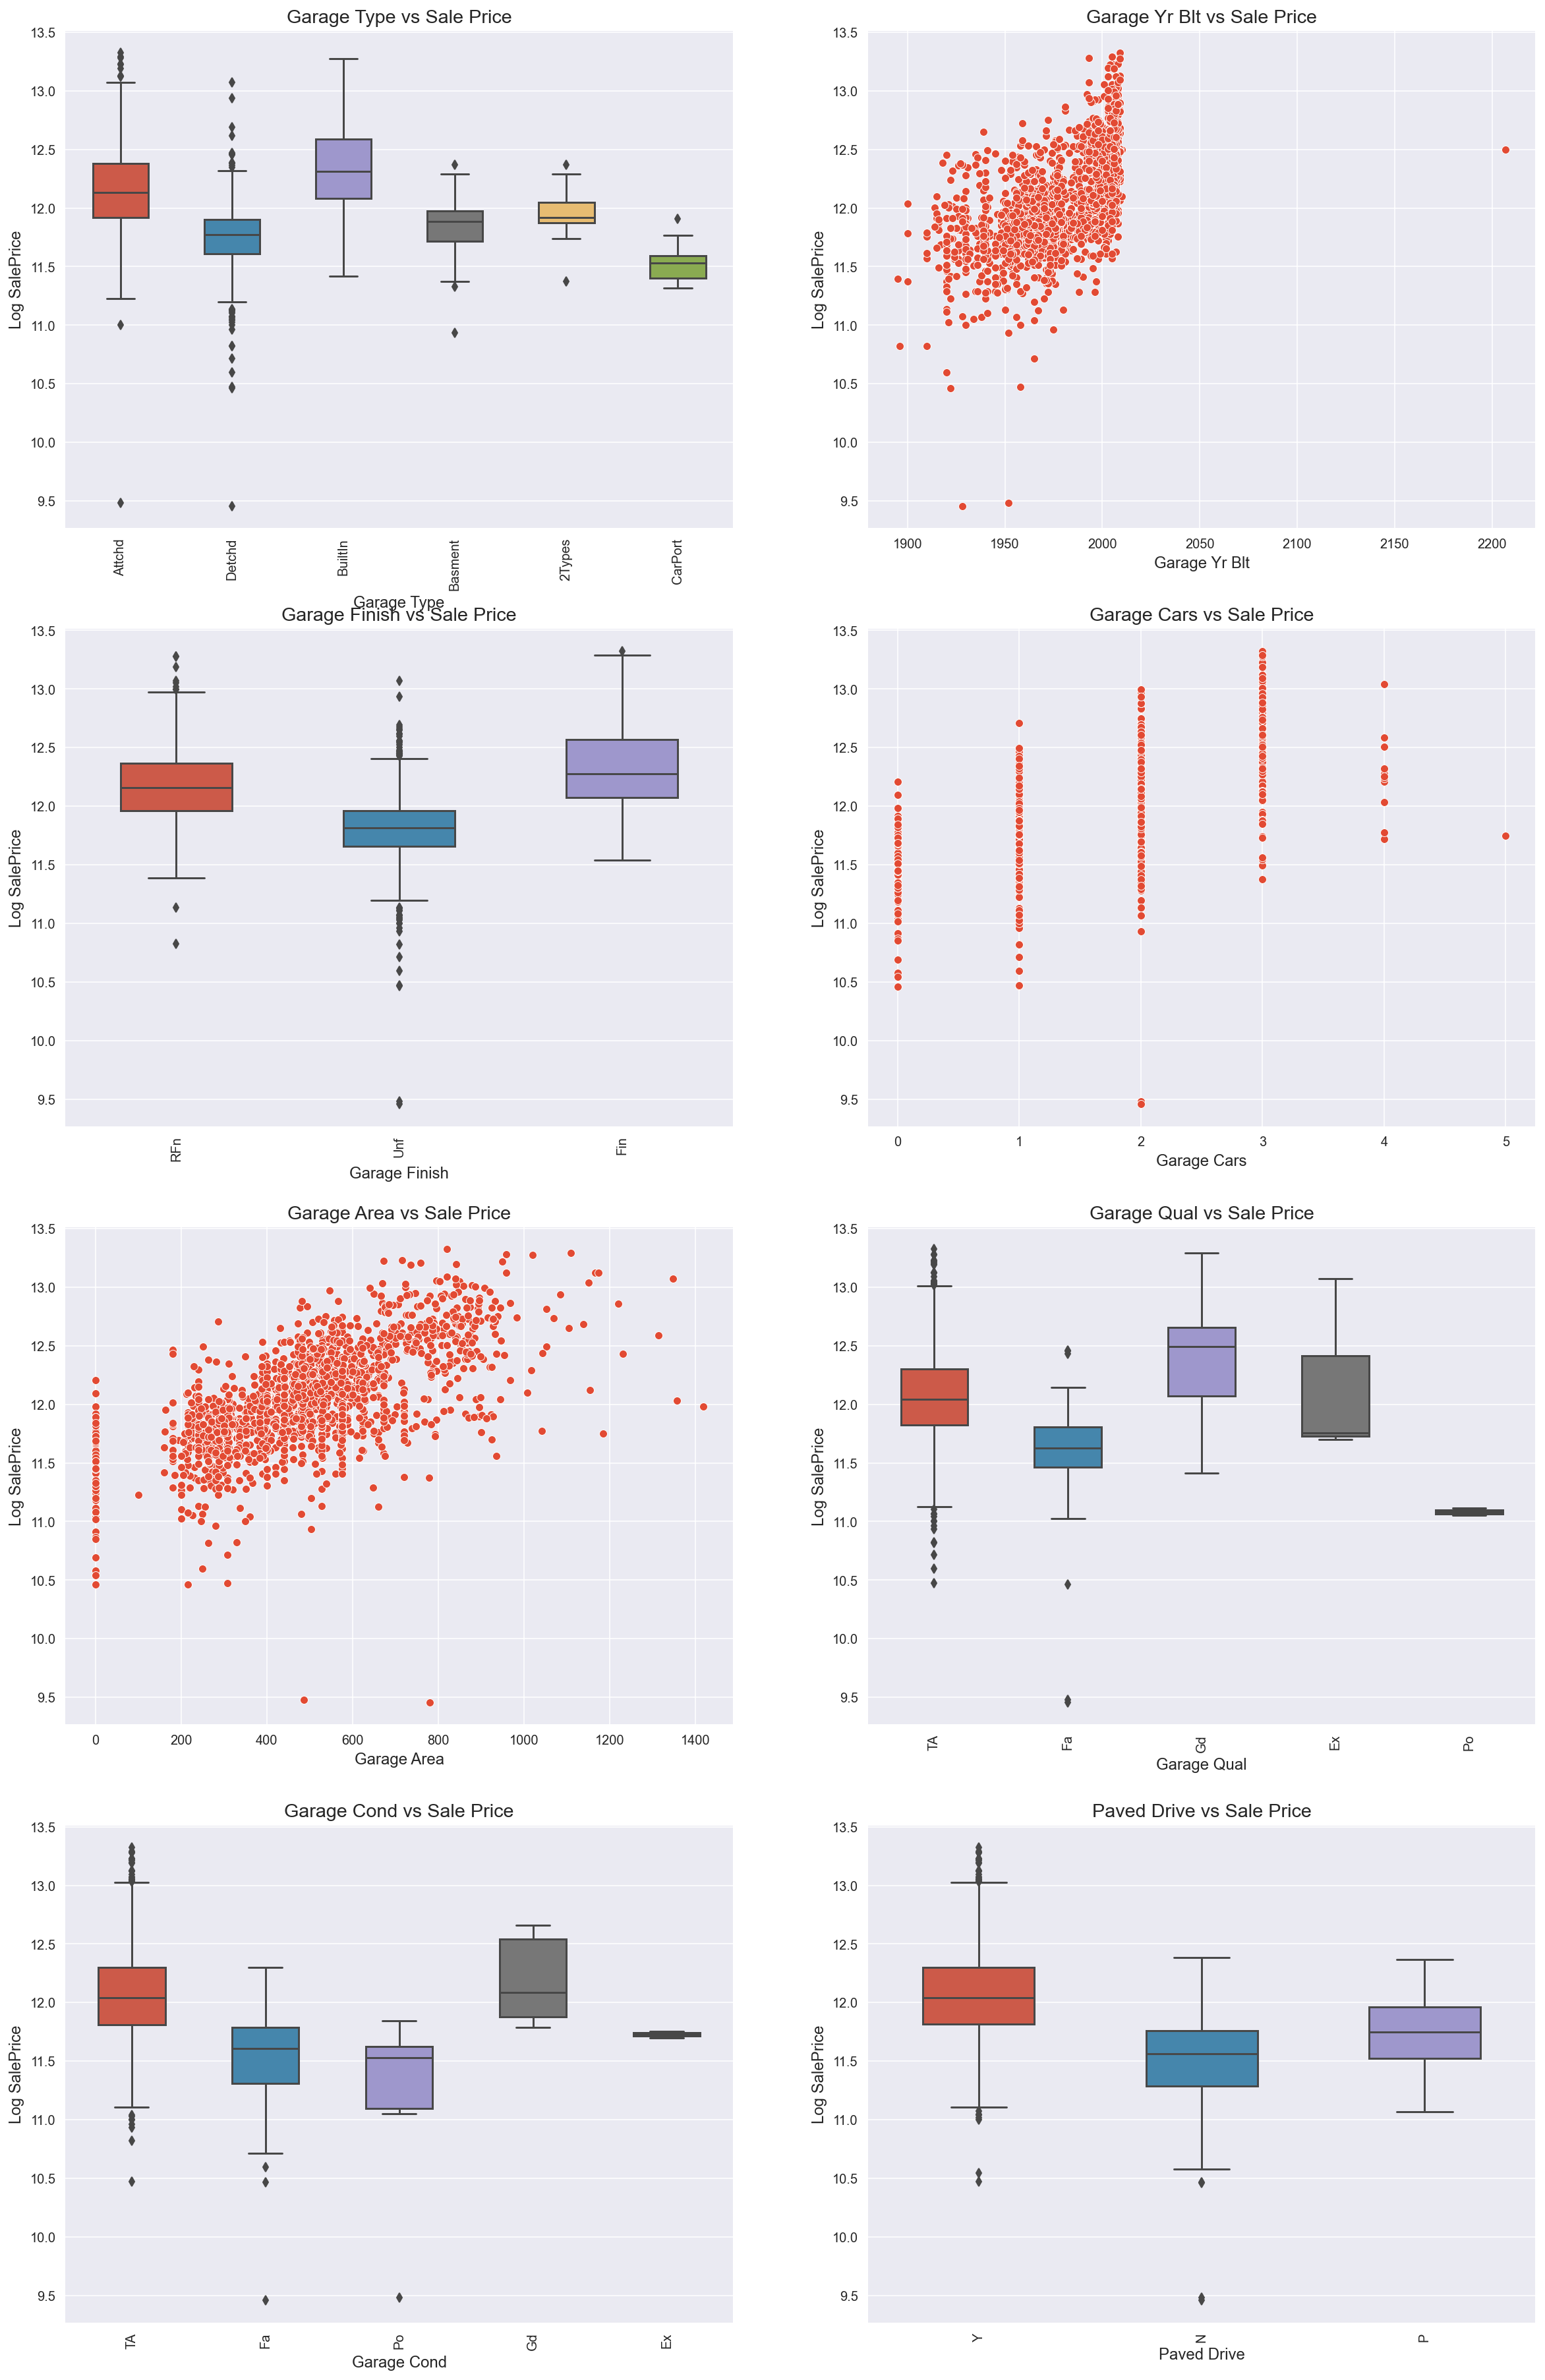

In [25]:
garage_list  = [garage for garage in df_train if 'Garage' in garage or 'Paved' in garage]
EDA_subplot(4 , 2 , garage_list , df_train)

### 1.4e General Overview on Heating & Utilities Related
___
- Total **7** features for Utilities : 
    - 1 numeric features : [Fireplaces]
    - 4 non-numeric ordinal features : [Heating QC , Fireplace QU , Electrical , Utilities]
    - 2 non-numeric , non-ordinal features : [Heating , Central Air]
- Having excellent & good heating facilities and fireplaces indicate a better selling price.
- Having Air conditioning helps in saleprice too.
- Most houses utilises the standard CCB
- Gas Heating is more common than gravity furnance and wall furnance
- Col Name annotation appear not to be consistent for same meaning : QC , QU , Qual , Cond. All same meaning , but different name.

| Features | Type | Description |
|---|---|---|
| Heating | Categorical | Floor : Floor Furnance<br>GasA : Gas Forced warm air furnance<br>GasW : Gas hot water or steam heat<br>Grav : Gravity Furnance<br>Wall : Wall Furnance |
| Heating QC | Ordinal | Ex : Excellent<br>Gd : Good<br>TA : Typical Average<br>Fa : Fair<br>Po : Poor |
| Fireplaces | Discrete | Number of fireplaces |
| Fireplace Qu | Ordinal | Ex : Excellent<br>Gd : Good<br>TA : Typical Average<br>Fa : Fair<br>Po : Poor<br>NA : No Fireplace |
| Central Air | Categorical | Central air conditioning (Yes /No) |
| Electrical | Ordinal | Electrical system<br>SBrkr : Standard CCB<br>FuseA : Fuse Box over 60A with all Romex Wiring<br>FuseF : Fuse Box at 60A with mostly Romex wiring<br>FuseP : Fuse Box at 60A with tube wiring<br>Mixed |
| Utilities | Ordinal | Type of utilities available<br>AllPub : E , G , W , S<br>NoSewr : E , G , W<br>NoSeWa : E , G<br>ELO : E |

<Figure size 864x864 with 0 Axes>

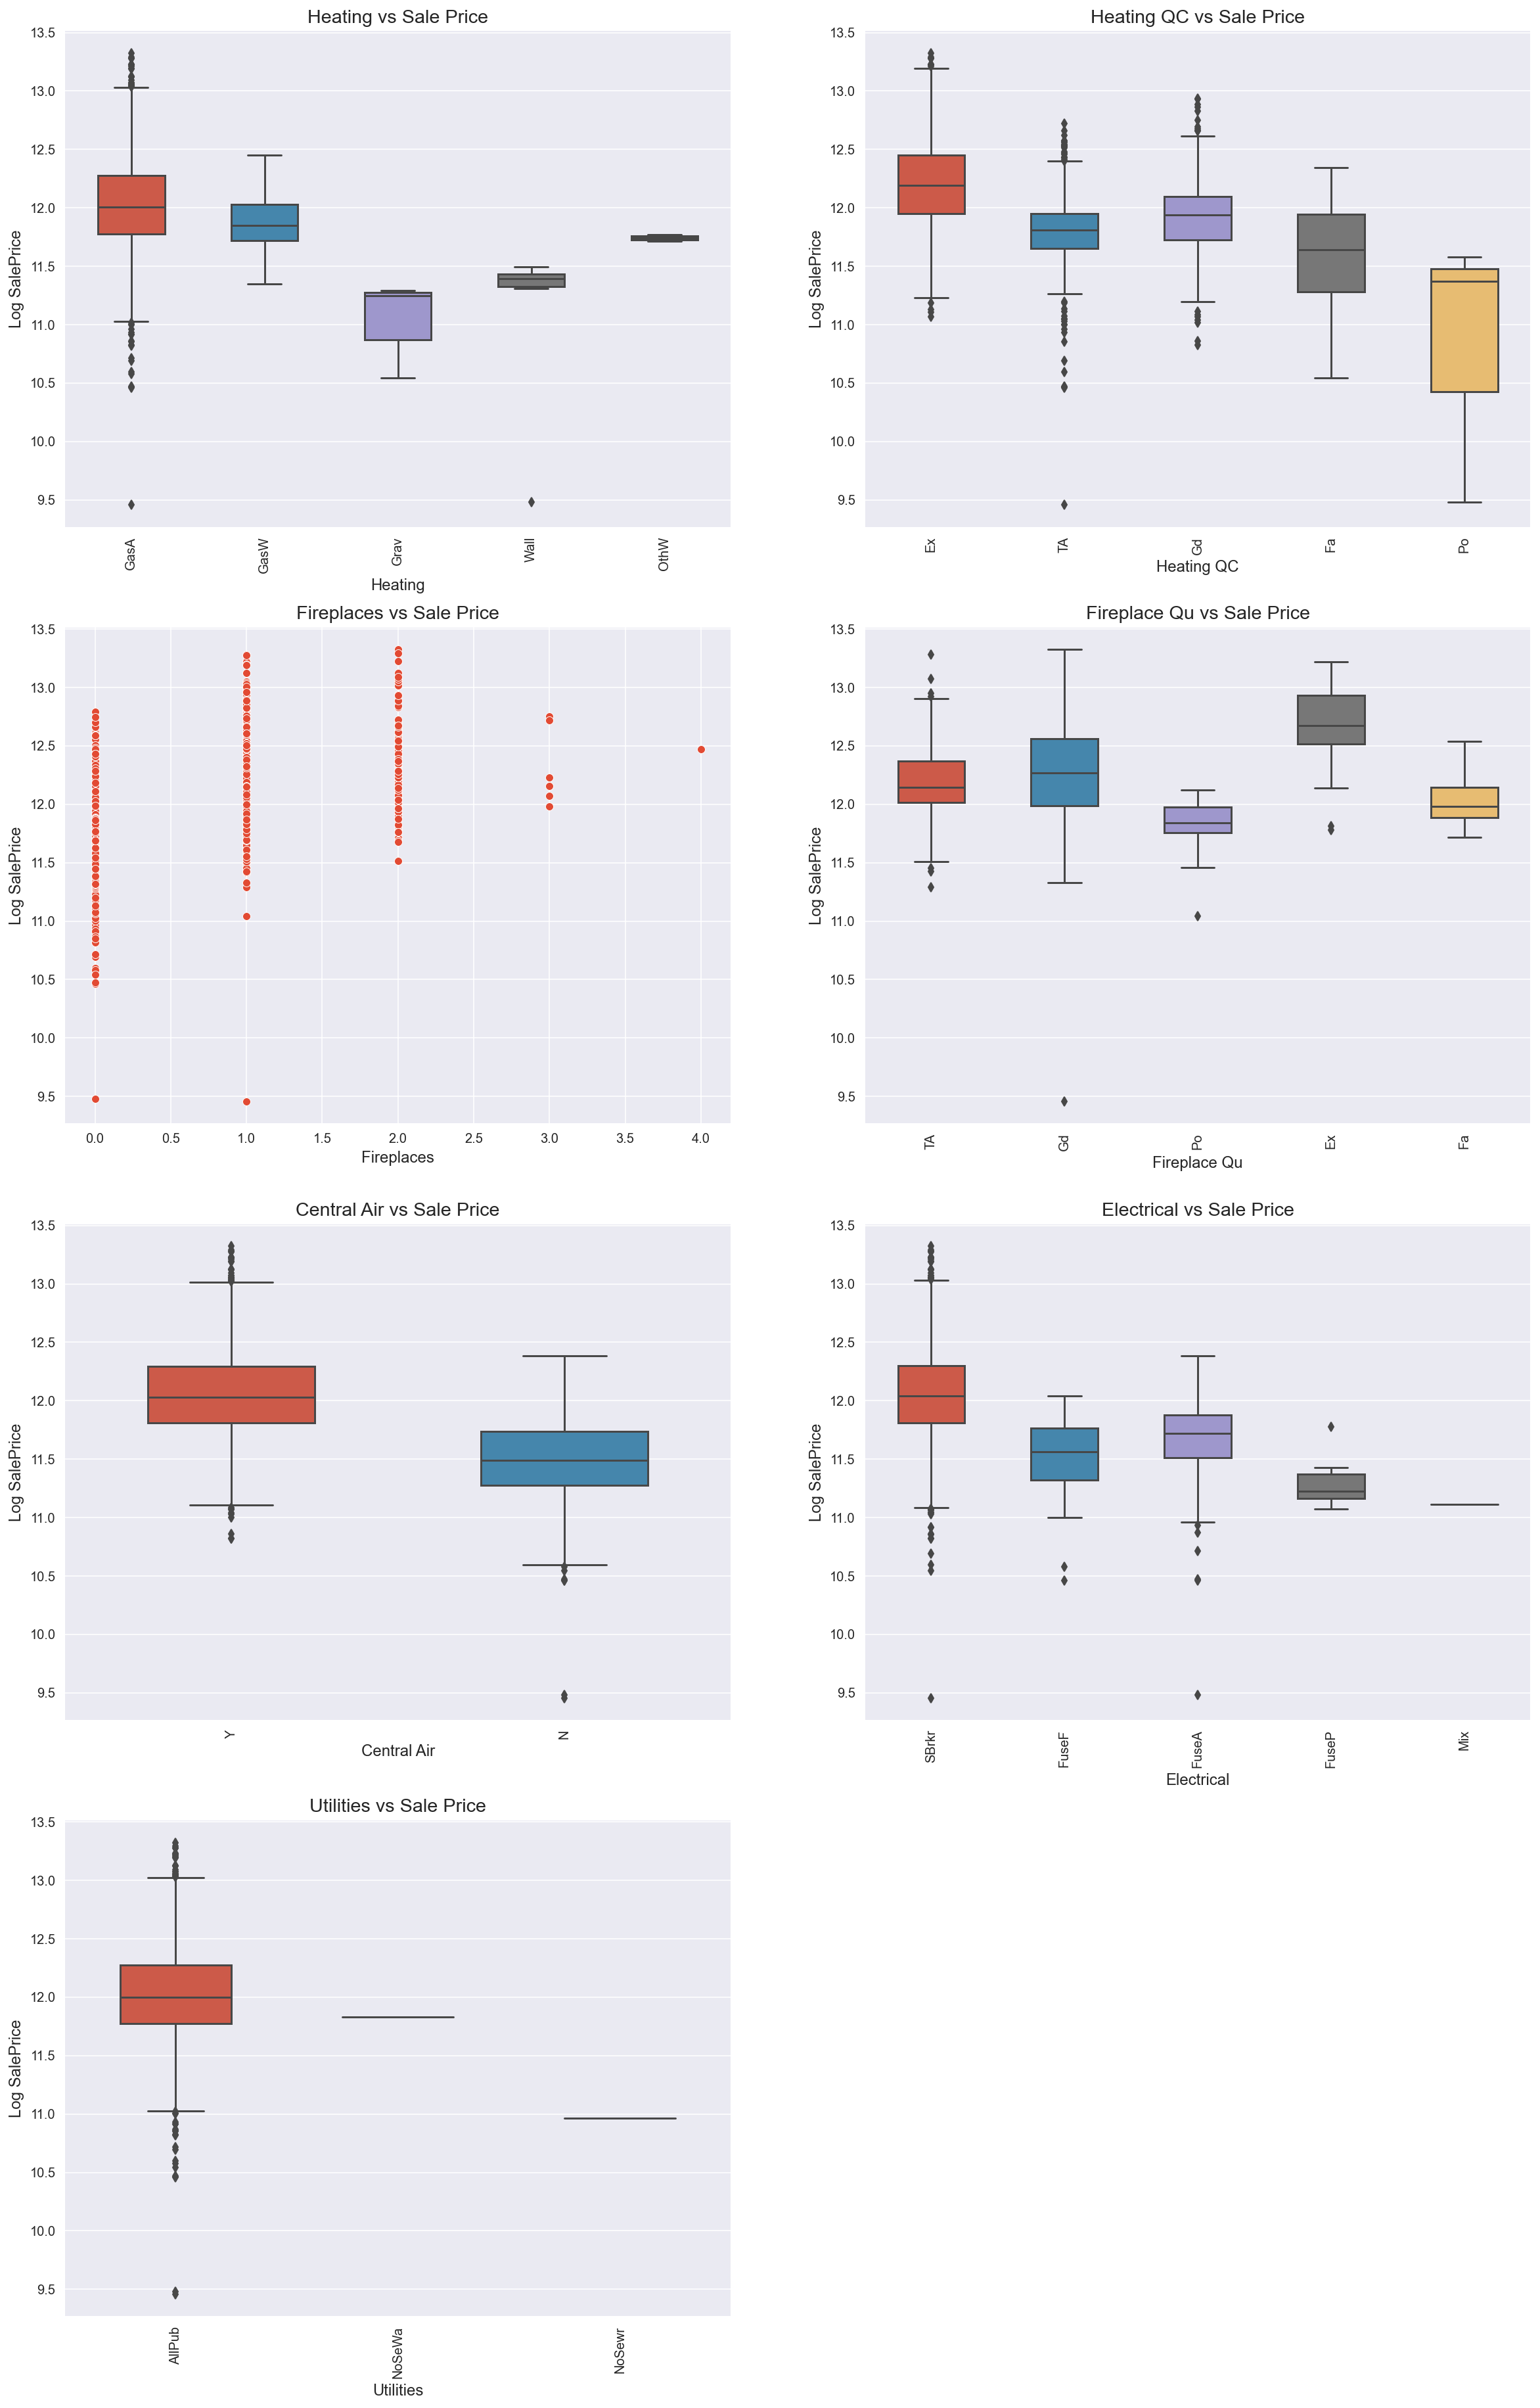

In [26]:
utilities_list  = ['Heating' , 'Heating QC' , 'Fireplaces' , 'Fireplace Qu' , 'Central Air' ,'Electrical' , 'Utilities']
utilities_list

plt.figure(figsize = (12,12))
EDA_subplot(4 , 2 , utilities_list , df_train);

### 1.4.1e Does Sales Price increase at Winter Season with better quality heating feature?
___

- Sales price with the same excellent , good heating quality remain fairly constant across all season.
- Heater type using Gas is able to fetch a higher price typically.


In [27]:
# Creating a dict for season

season_map = {1 : 'Spring' , 2 : 'Spring' , 3 : 'Spring',
              4 : 'Summer' , 5 : 'Summer' , 6 : 'Summer',
              7 : 'Autumn' , 8 : 'Autumn' , 9 : 'Autumn',
              10 : 'Winter' , 11 : 'Winter' , 12 : 'Winter'}

df_train['Season'] = df_train['Mo Sold'].map(season_map)

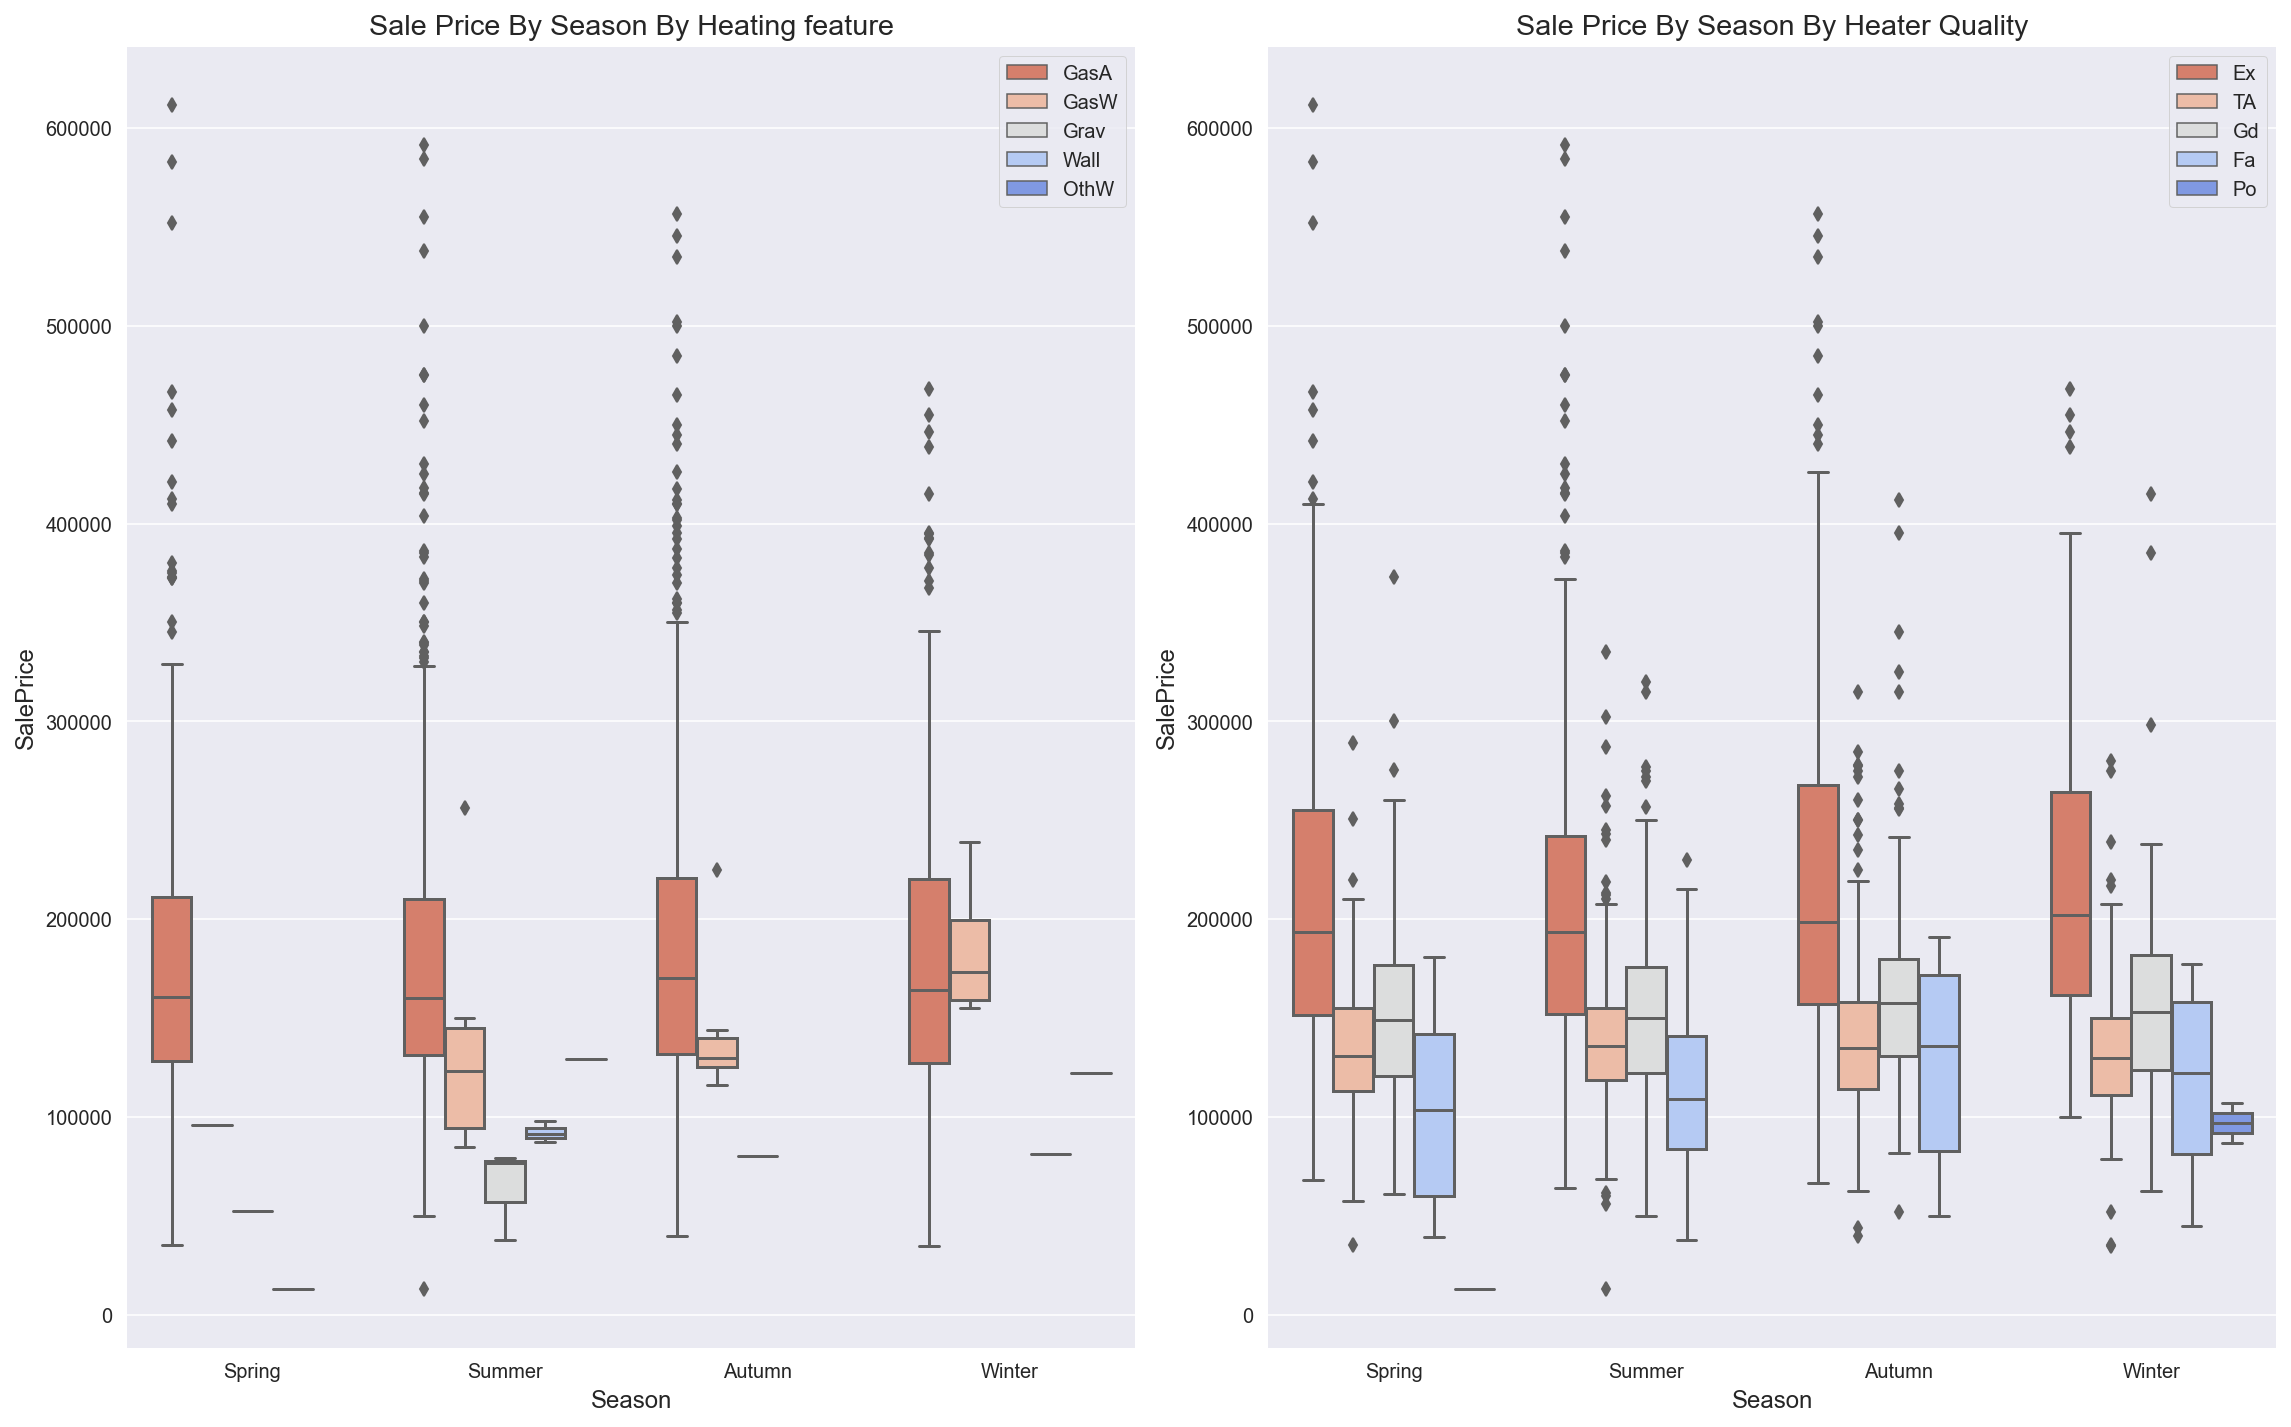

In [28]:
# Plotting Seasons against heating features
plt.figure(figsize = (16,10))

plt.subplot(1,2,1)
sns.boxplot(data = df_train,
            x = 'Season',
            y = 'SalePrice',
            hue = 'Heating',
            palette = 'coolwarm_r');
plt.title('Sale Price By Season By Heating feature')
plt.legend(loc = 'best')

plt.subplot(1,2,2)
sns.boxplot(data = df_train,
            x = 'Season',
            y = 'SalePrice',
            hue = 'Heating QC',
            palette = 'coolwarm_r');
plt.title('Sale Price By Season By Heater Quality')
plt.legend(loc = 'best')

plt.tight_layout()

### 1.4f General Overview on Porch Features
___
- Total **5** features for Porch : 
    - 6 numeric features
- There are houses with no porch that is selling higher or equivalently as high as those with porch.
- Fairly neutral relation from general observation

| Features       | Type       | Description  |
|----------------|------------|-------|
| Wood Deck SF   | Continuous | Sq Ft |
| Open Porch SF  | Continuous | Sq Ft |
| Enclosed Porch | Continuous | Sq Ft |
| 3-Ssn Porch    | Continuous | Sq Ft |
| Screen Porch   | Continuous | Sq Ft |

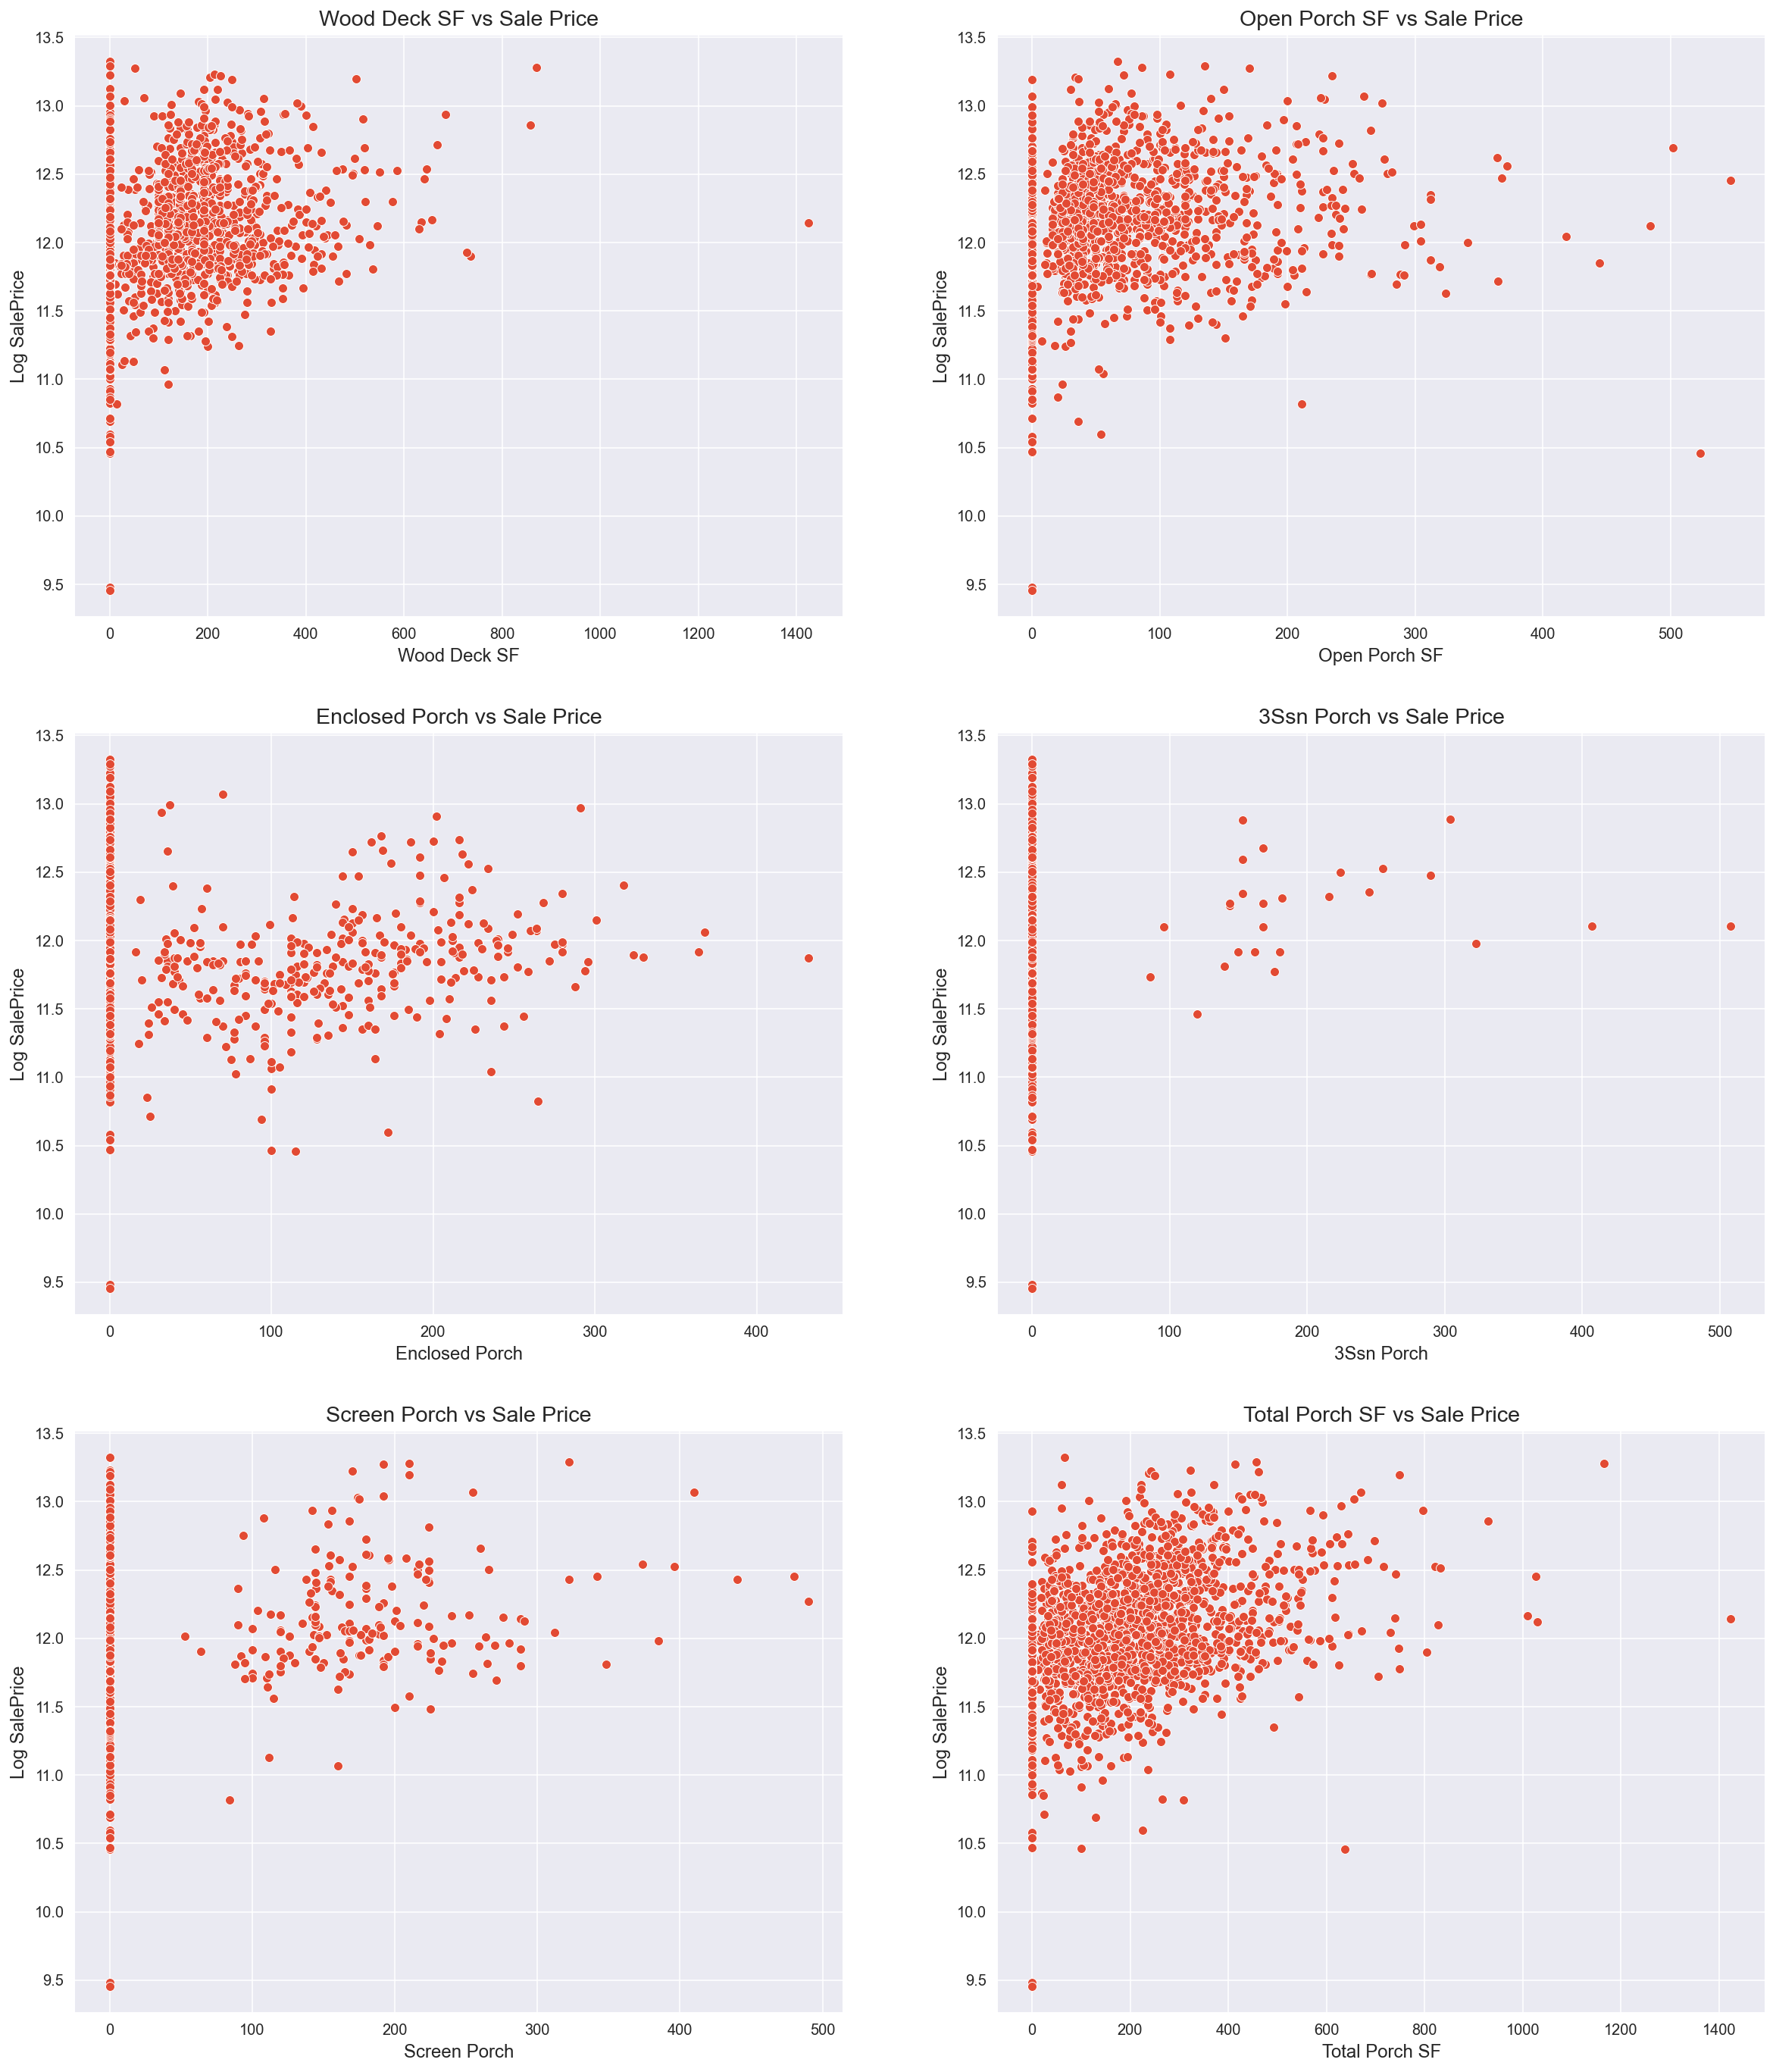

In [29]:
porch_list  = [porch for porch in df_train if 'Porch'in porch or 'Deck' in porch]

df_train['Total Porch SF'] = df_train[porch_list].sum(axis = 1)

# Updating Porch List
porch_list  = [porch for porch in df_train if 'Porch'in porch or 'Deck' in porch]

EDA_subplot(3 , 2 , porch_list , df_train)

### 1.4g General Overview on House Exterior Features
___

- Total **6** features for Heater : 
    - 2 non-numeric ordinal features : [Exter Qual , Exter Cond]
    - 4 non-numeric , non-ordinal features : [Exterior 1st , Exterior 2nd , Roof Style , Roof Matl]
- Having excellent housing condition correlate to a higher price and a poor 
- Gas Heating is more common than gravity furnance and wall furnance
- Outlier Data can be observed in Exterior features

| Features | Type | Description |
|---|---|---|
| Exterior 1st<br>Exterior 2nd | Categorical | AsbShng	: Asbestos Shingles<br>AsphShn	: Asphalt Shingles<br>BrkComm	: Brick Common<br>BrkFace	: Brick Face<br>CBlock : Cinder Block<br>CemntBd	: Cement Board<br>HdBoard	: Hard Board<br>ImStucc	: Imitation Stucco<br>MetalSd	: Metal Siding<br>Other : Other<br>Plywood	: Plywood<br>PreCast	PreCast	<br>Stone : Stone<br>Stucco : Stucco<br>VinylSd : Vinyl Siding<br>WdSdng : Wood Siding<br>WdShing : Wood Shingles |
| Roof Style | Categorical | Flat	Flat<br>Gable : Gable<br>Gambrel : Gabrel (Barn)<br>Hip : Hip<br>Mansard : Mansard<br>Shed : Shed |
| Roof Matl | Categorical | ClyTile	: Clay or Tile<br>CompShg : Standard (Composite) Shingle<br>Membran : Membrane<br>Metal :	Metal<br>Roll : Roll<br>Tar&Grv : Gravel & Tar<br>WdShake : Wood Shakes<br>WdShngl : Wood Shingles |
| Exterior QC<br>Exterior Cond | Ordinal | Ex : Excellent<br>Gd : Good<br>TA : Typical Average<br>Fa : Fair<br>Po : Poor |

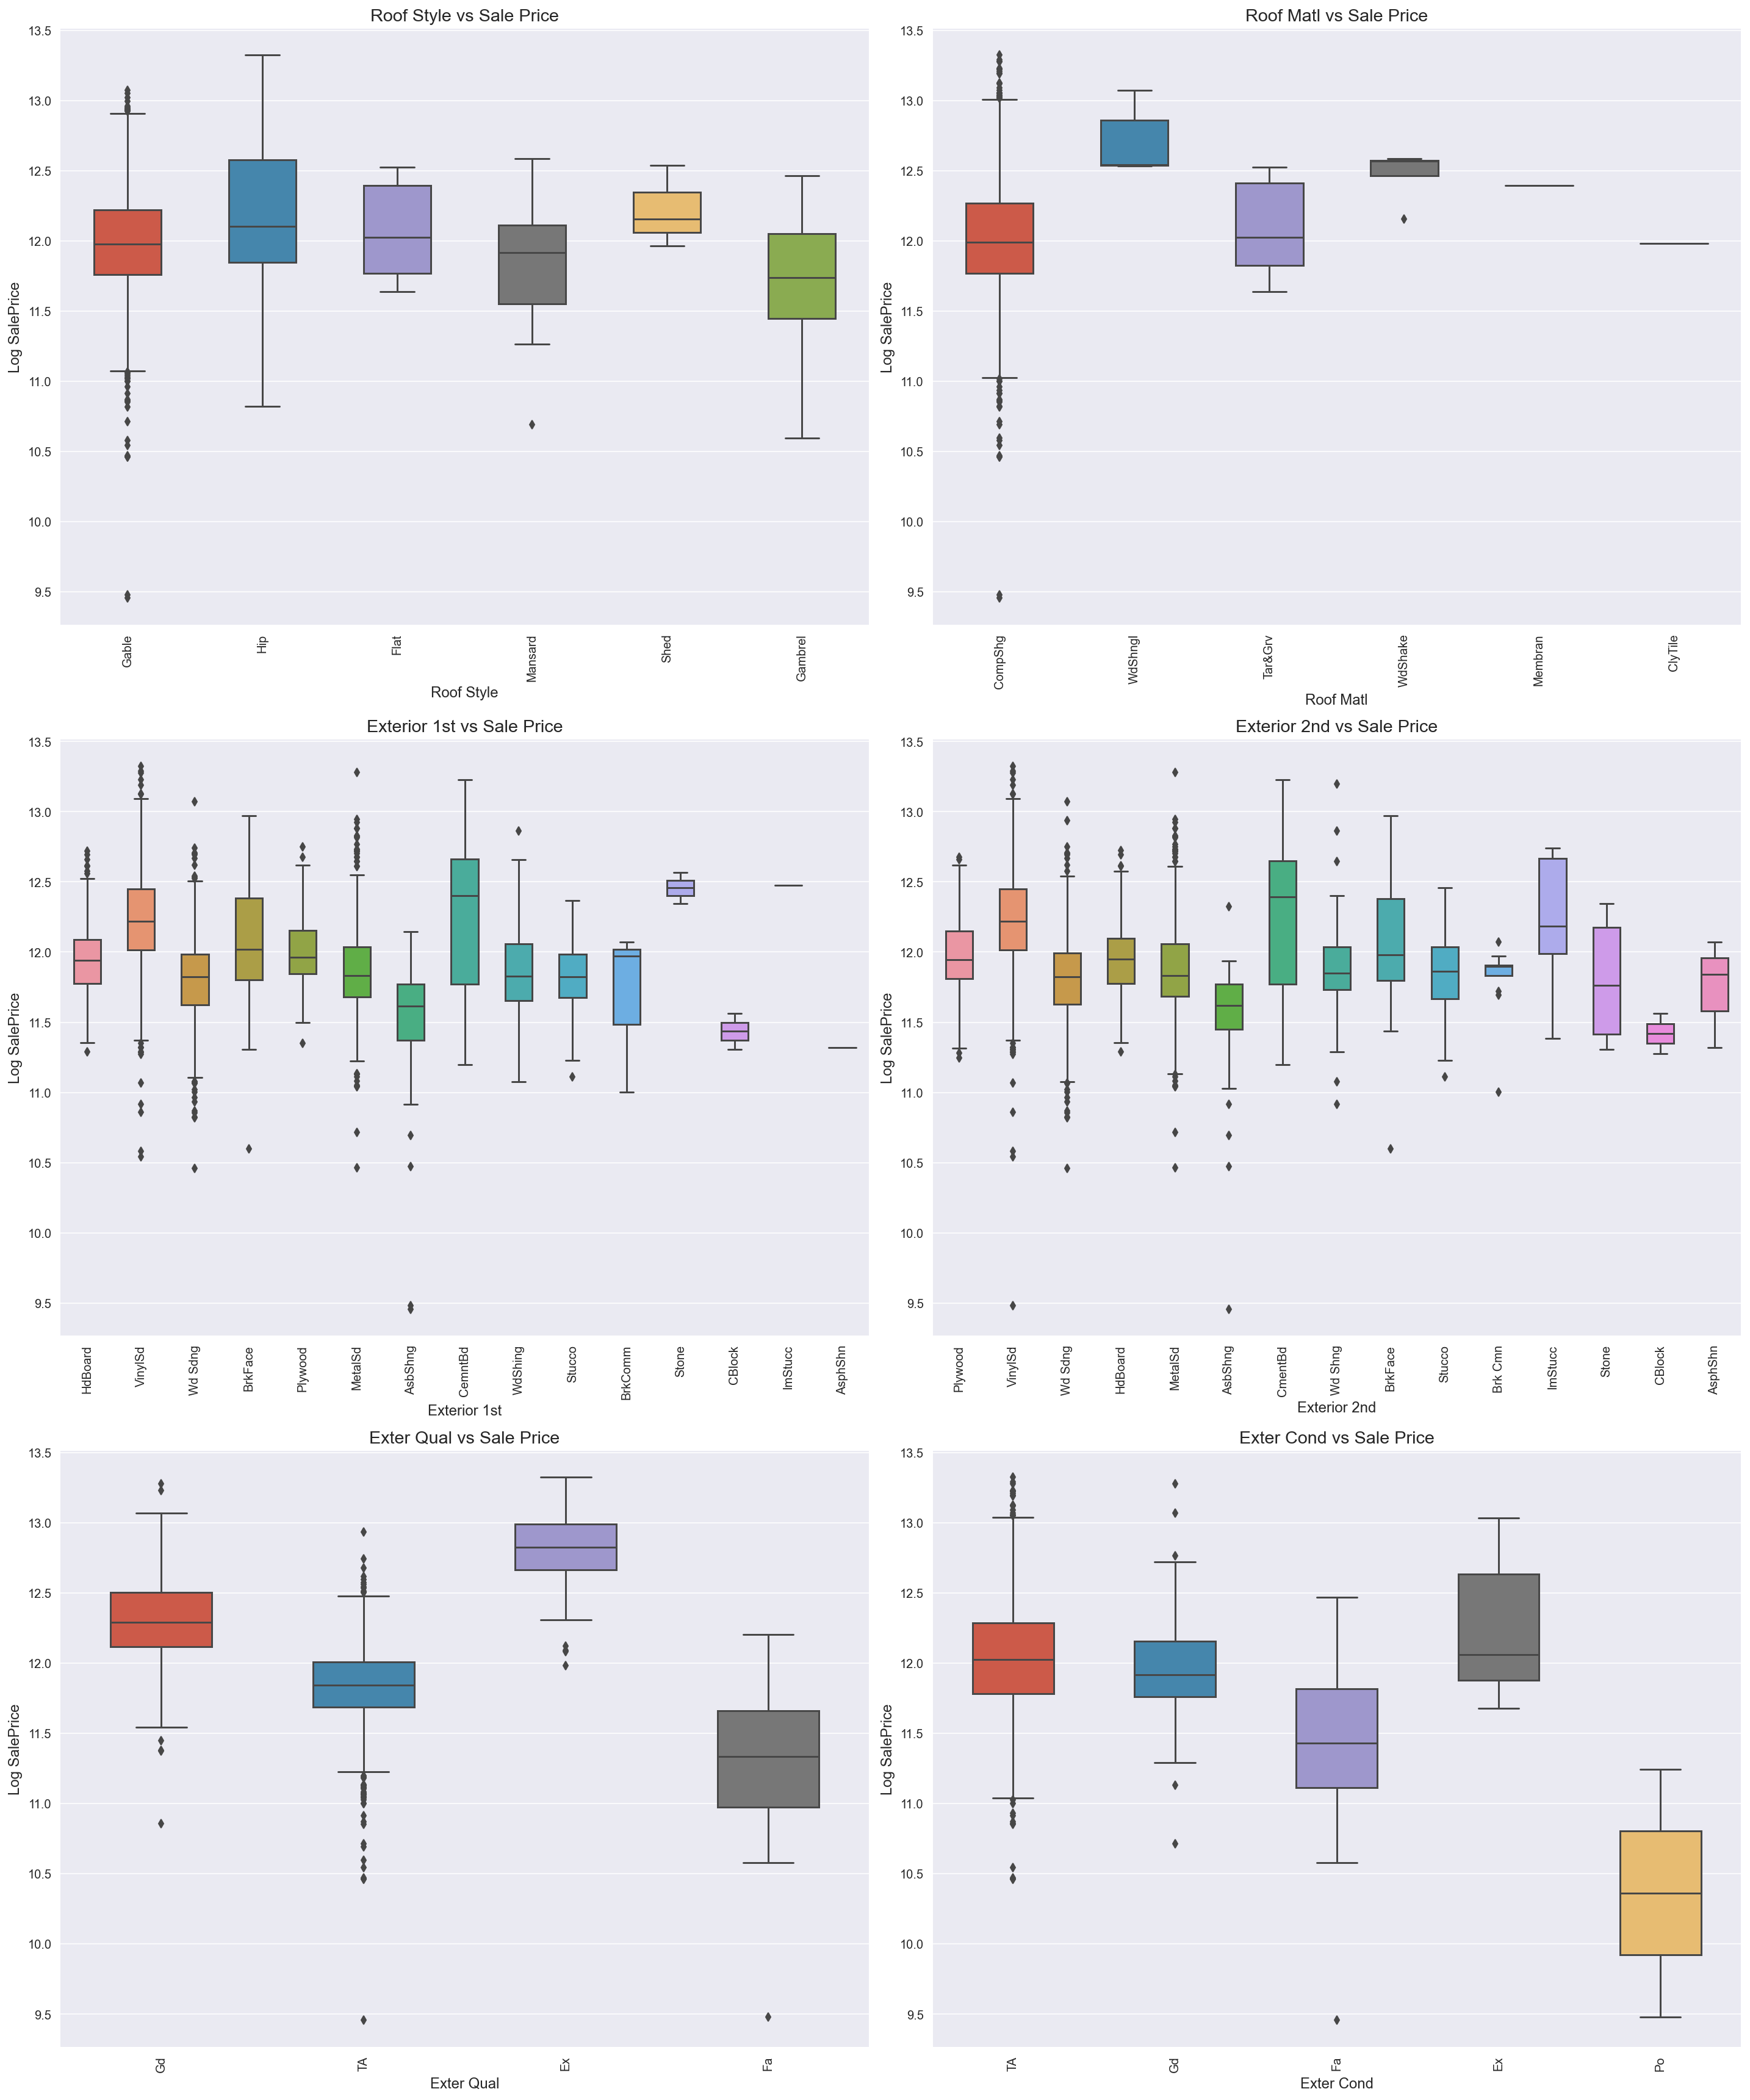

In [30]:
ext_feature_list  = [ext for ext in df_train if 'Exter'in ext or 'Roof' in ext]

EDA_subplot(3,2,ext_feature_list , df_train)
plt.tight_layout(h_pad=1.08)

### 1.4h General Overview on House Interior Features
___

- General Features related to house floor ,area , bath , room , kitchen & masonry
- General Observation:
    - House size observed to have a linear impact on sale price as seen from 1st flr , 2nd flr SF and Gr Liv Area
    - While Kitchen quantity might not matter , kitchen quality does.
    - More room , better sales price.
    - Some outliers can be observed in Living Area , 4 that are very large, yet cheap.
    - Brick Face and Stone are popular choice for masonary, however large portion of house does not have.
- We have 1 house or restaurant that have 3 kitchens. Will remove this outlier

| Features | Type | Description |
|---|---|---|
| 1st Flr SF | Continuous | First Floor square feet |
| 2nd Flr SF | Continuous | Second floor square feet |
| Low Qual Fin SF | Continuous | Low quality finished square feet (all floors) |
| Gr Liv Area | Continuous | Above ground(above grade) living area square feet |
| Full Bath | Discrete | Full bathrooms above grade (above ground) |
| Half Bath | Discrete | Half bathrooms above grade (above ground) |
| Bedroom AbvGr | Discrete | Bedrooms above grade (does NOT include basement bedrooms) |
| TotRms AbvGrd | Discrete | Total rooms above grade (does not include bathrooms) |
| Kitchen AbvGr | Discrete | Kitchens above grade (ground) |
| KitchenQual | Ordinal | Ex : Excellent<br>Gd : Good<br>TA : Typical Average<br>Fa : Fair<br>Po : Poor |
| Mas Vnr Type | Categorical | Masonry veneer type<br>BrkCmn : Brick Common<br>BrkFace : Brick Face<br>CBlock : Cinder Block<br>Stone : Stone<br>NA :None |
| Mas Vnr Area | Continuous | Masonry veneer area in square feet |

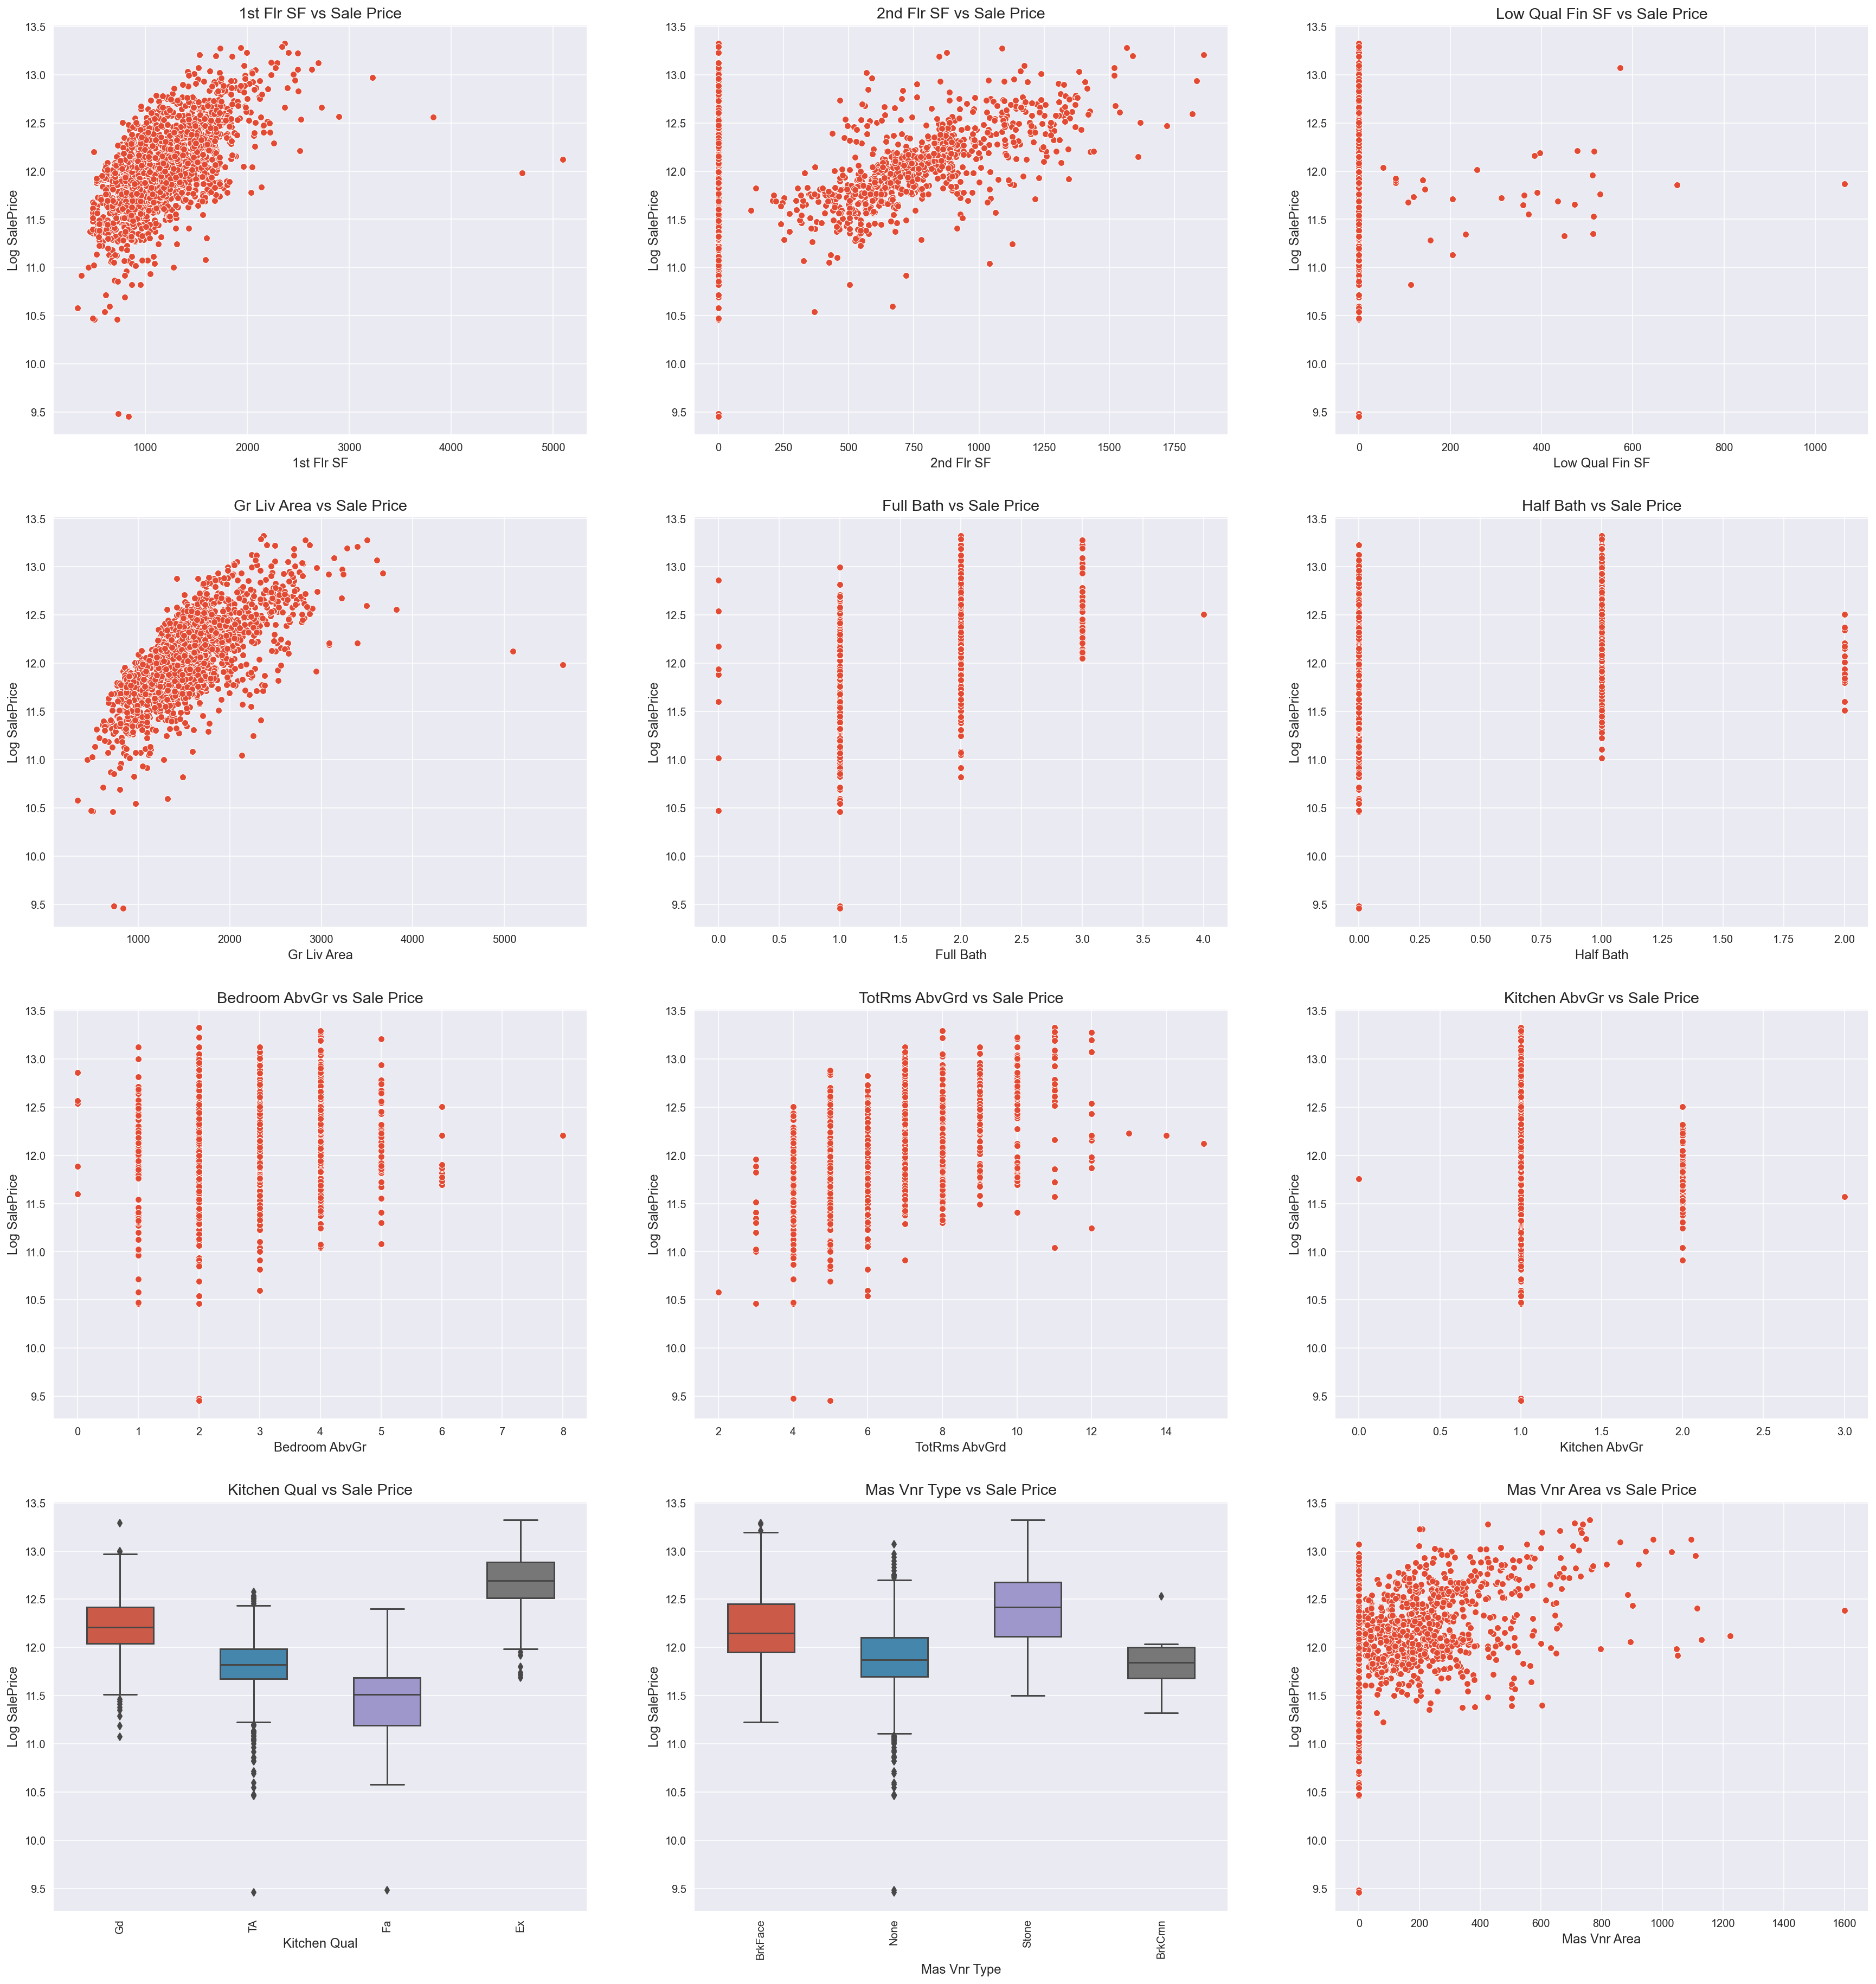

In [31]:
int_feature_list  = ['1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr' , 'TotRms AbvGrd' ,'Kitchen AbvGr', 'Kitchen Qual' , 'Mas Vnr Type', 'Mas Vnr Area']

EDA_subplot(4,3,int_feature_list , df_train)

### 1.4i General Overview on Land Plot Feature
___

- General features on the land plot and land condition.
- Feature of access and the land plot have neutral correlation with the SalePrice individually.
- Couple of Outlier could be observed in Lot Area and Lot Frontage.

| Feature | Type | Description |
|---|---|---|
| Lot Frontage | Continuous | Linear feet of street connected to property |
| Lot Area | Continuous | Lot size in square feet |
| Street | Categorical | Type of road access to property<br>Grvl : Gravel<br>Pave : Paved |
| Alley | Categorical | Type of road access to property<br>Grvl : Gravel<br>Pave : Paved |
| Lot Shape | Ordinal | General Shape of Property<br>Reg : Regular<br>IR1 : Slightly Irregular<br>IR2 : Moderately Irregular<br>IR3 : Irregular |
| Land Slope | Ordinal | Slope of property<br>Gtl : Gentle<br>Mod : Moderate Slope<br>Sev : Severe Slope |
| Land Contour | Categorical | Flatness of the property<br>Lvl : Near Flat / Level<br>Bnk : Banked<br>HLS : Hillside<br>Low : Depression |
| Lot Config | Categorical | Lot Configuration<br>Inside : Inside Lot<br>Corner : Corner<br>CulDeSac : Cul-De-Sac<br>FR2 : Frontage on 2 sides<br>FR3 : Frontage on 3 sides |

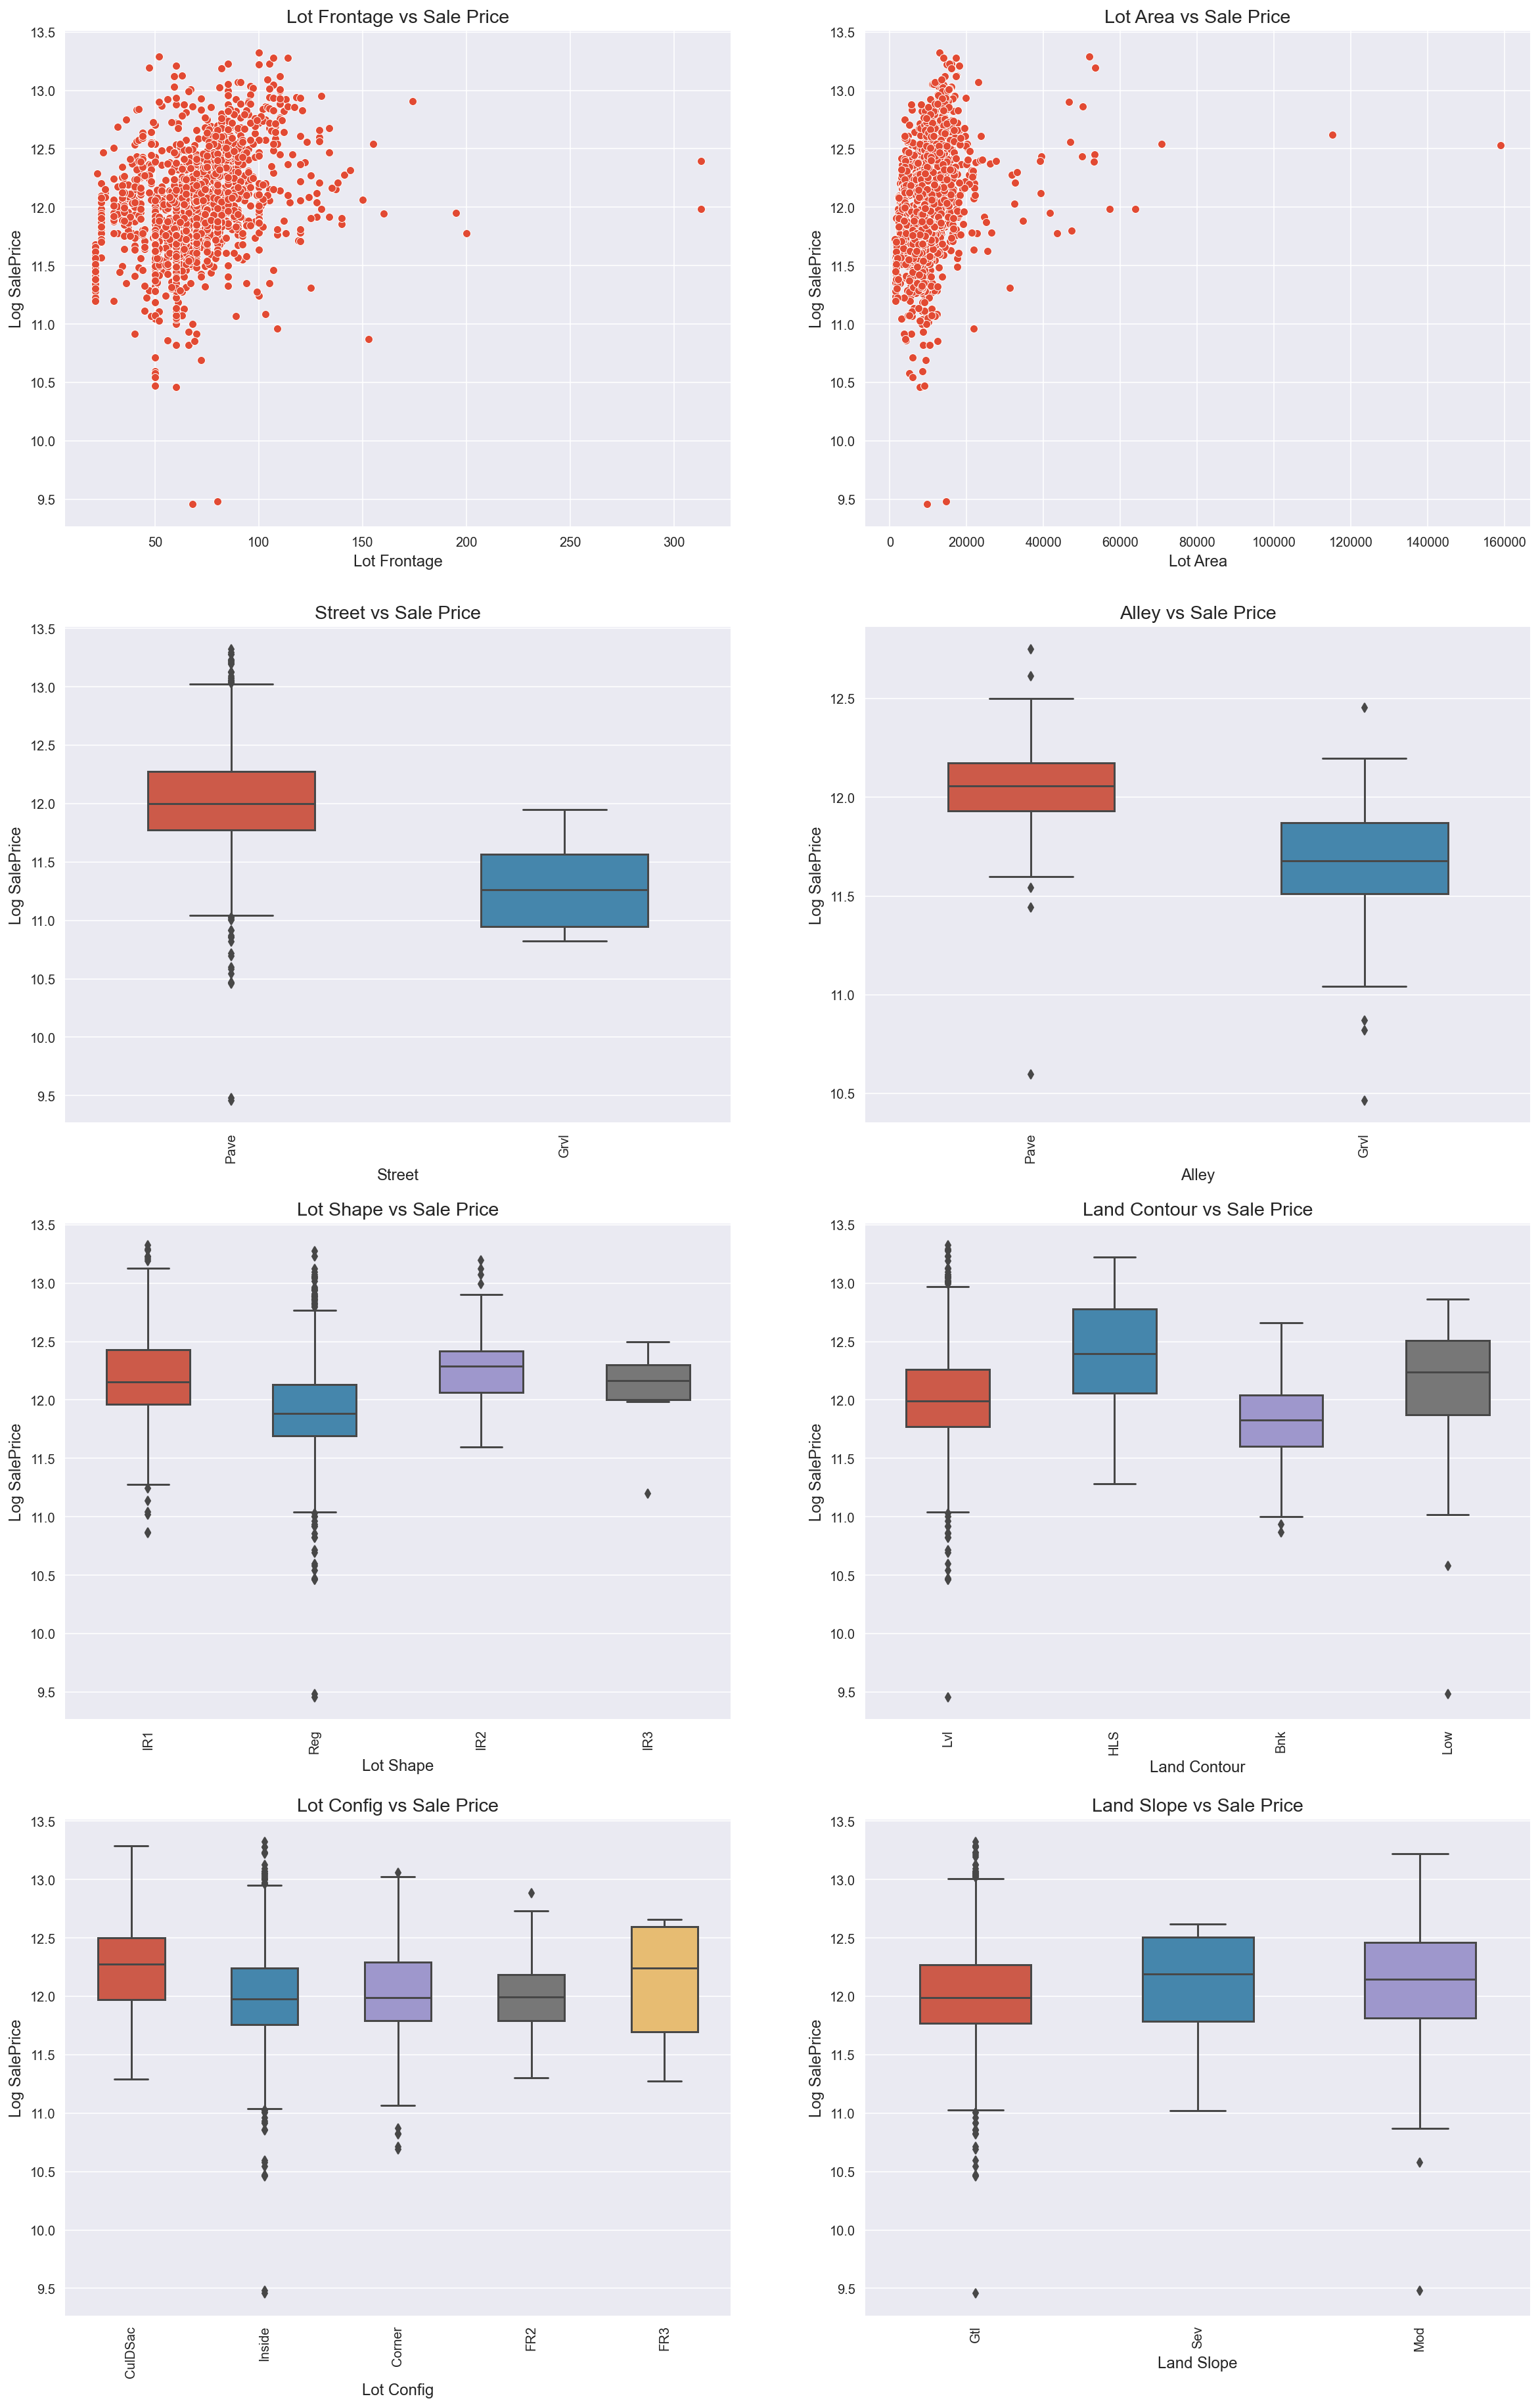

In [32]:
land_plot_list  = [lot for lot in df_train if 'Lot'in lot or 'Land' in lot or 'Street' in lot or 'Alley' in lot]
EDA_subplot(4,2 , land_plot_list , df_train)

### 1.4j General Overview on Neighborhood
___

- From below observations , there appears to have 4 clusters. We will dummify them into 4 sections as Ordinal Feature.

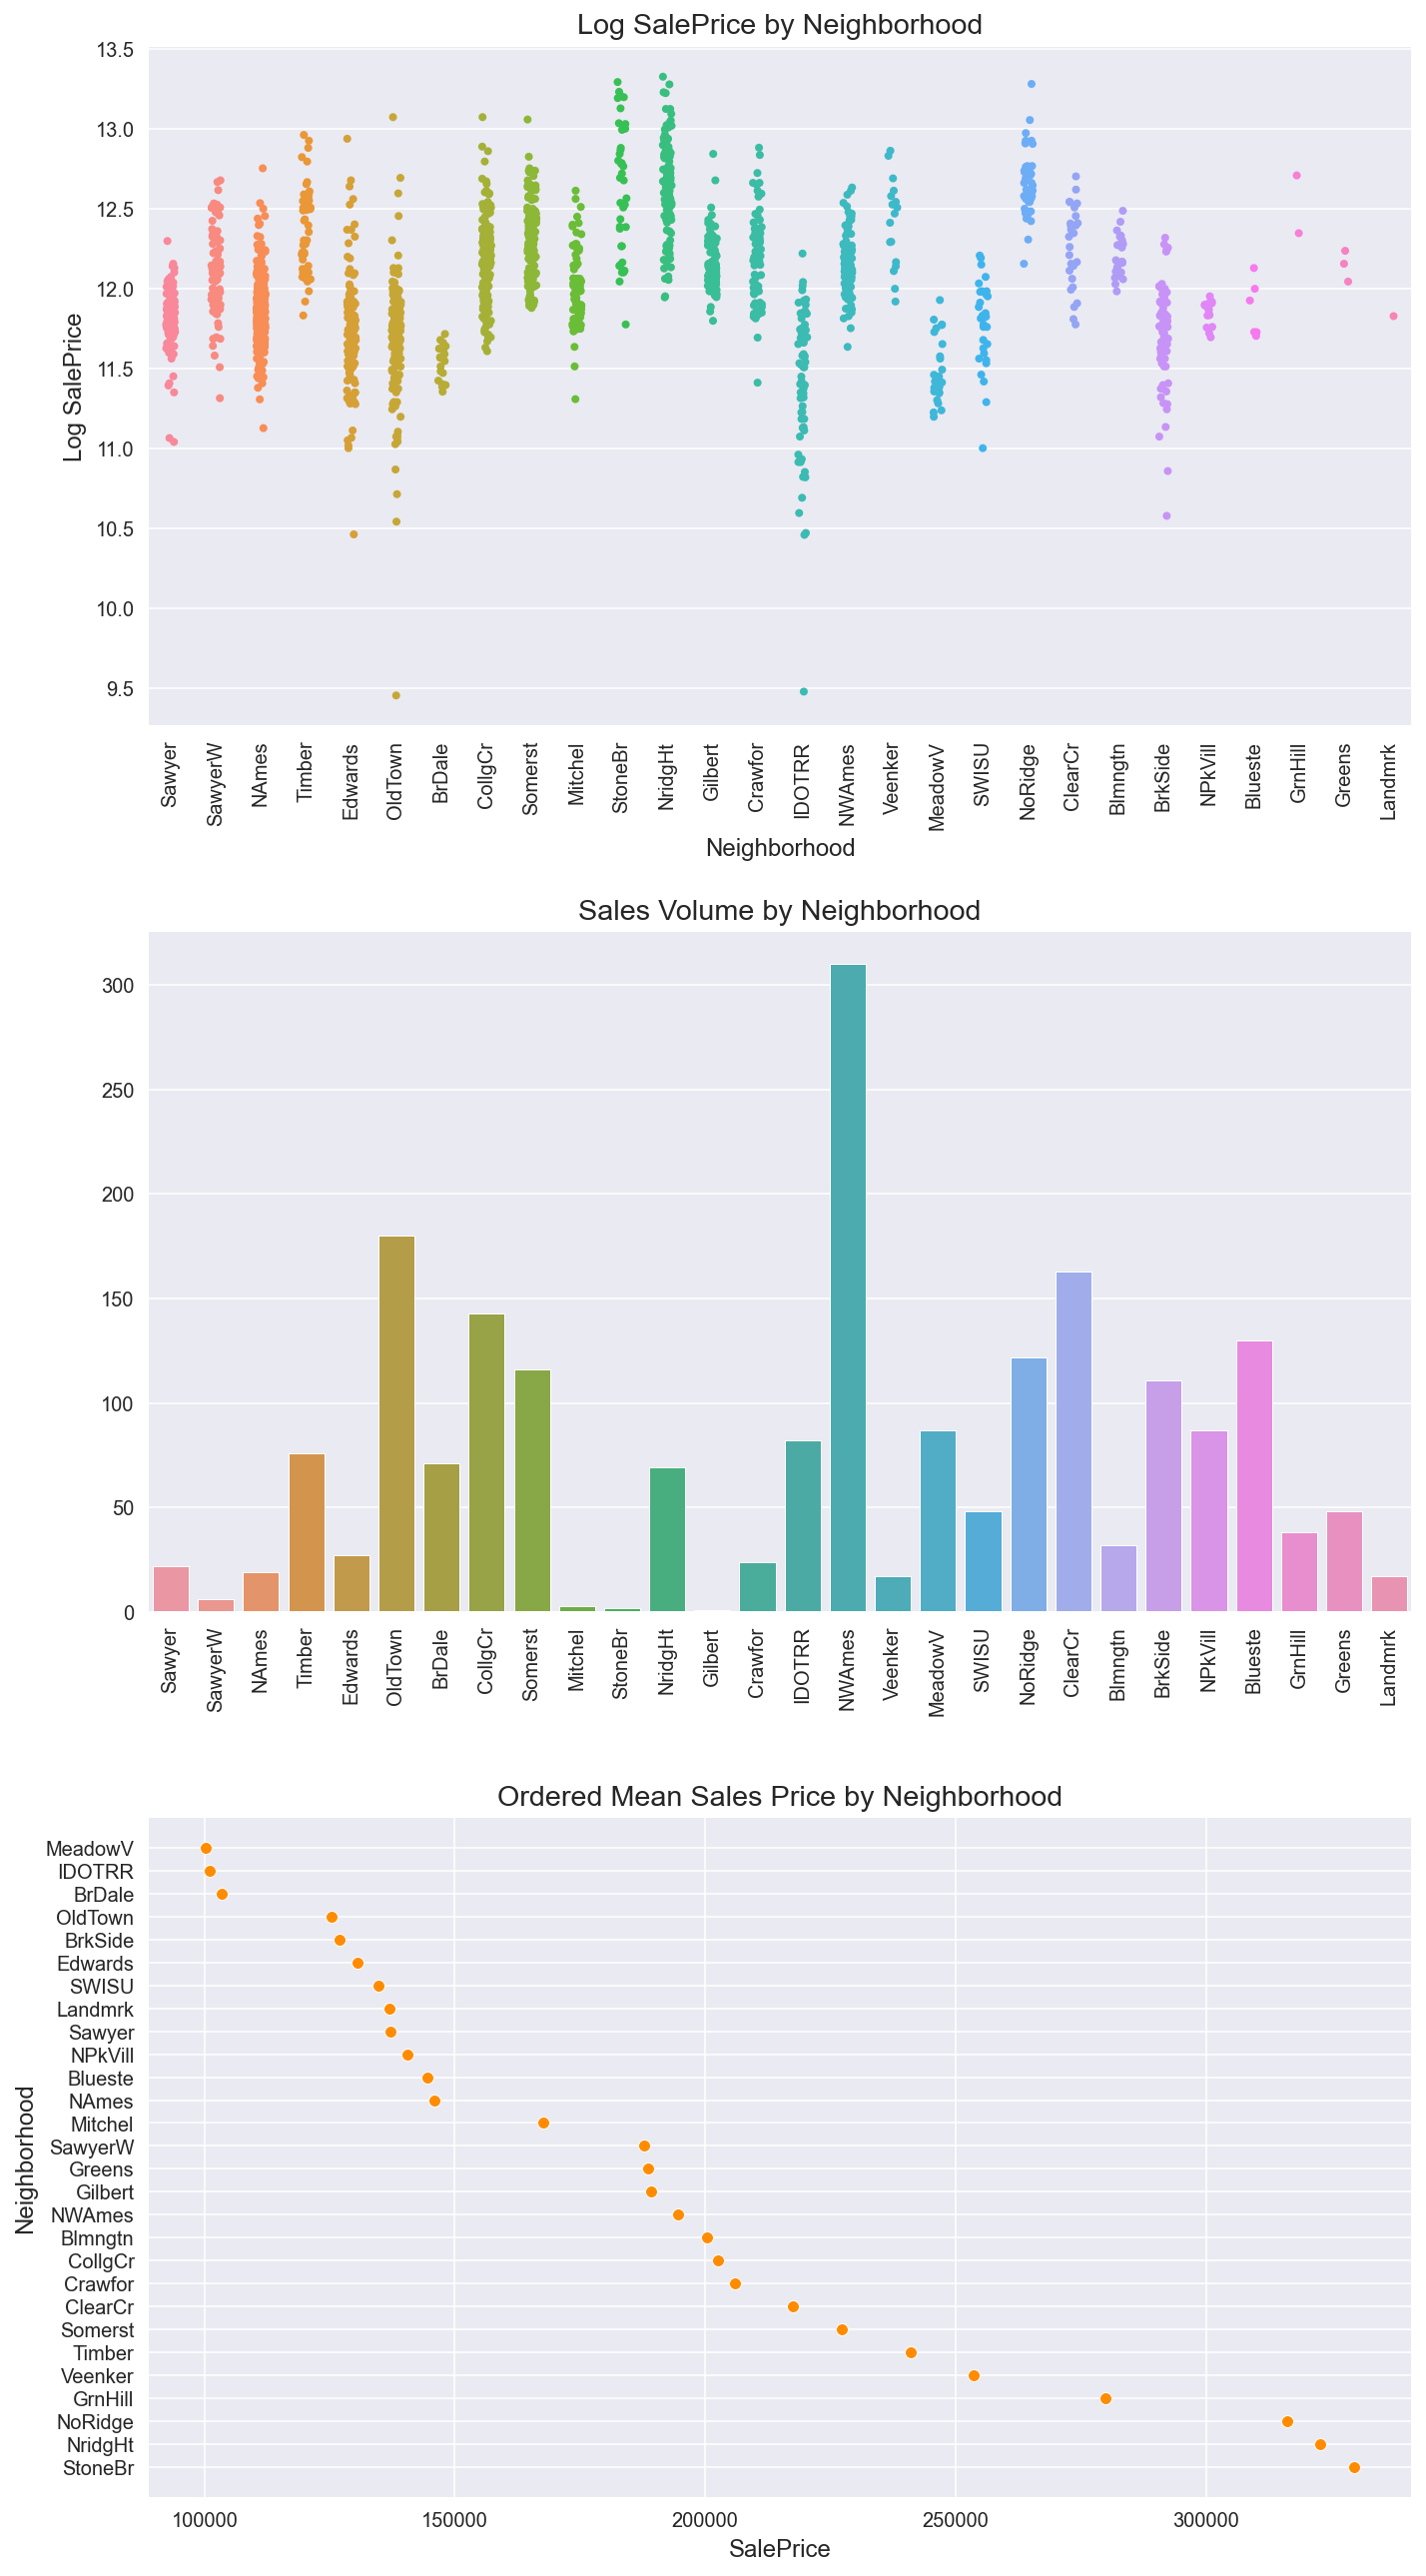

In [33]:
plt.figure(figsize = (10,18))


### Sales Price Overview
plt.subplot(3,1,1)
sns.stripplot(x = 'Neighborhood',
              y = 'Log SalePrice',
              data = df_train,
              size = 4)
plt.title('Log SalePrice by Neighborhood')
plt.xticks(rotation = 90)

### Sales Volume Overview
plt.subplot(3,1,2)
sns.barplot(x = df_train['Neighborhood'].unique(),
            y = df_train.groupby('Neighborhood').size(),
            ci = False)

plt.title('Sales Volume by Neighborhood')
plt.xticks(rotation = 90)

### Sales Price Overview
plt.subplot(3,1,3)
df_neighborhood = pd.DataFrame(df_train.groupby('Neighborhood').mean()['SalePrice']).sort_values(by = 'SalePrice')

sns.scatterplot(x = df_neighborhood['SalePrice'],
                y = df_neighborhood.index,
                data = df_neighborhood,
                color = 'darkorange')
plt.title('Ordered Mean Sales Price by Neighborhood')

plt.tight_layout(h_pad=2)

In [34]:
# Create a ordinal dict to map neighbourhood to cluster

"""
Neighborhood 1: MeadowV : BrDale
Neighborhood 2: Oldtown : Mitchel
Neighborhood 3: SawyerW : GrnHill
Neighborhood 4: NoRidge : StoneBr

"""

# We could attempt to use K_means over here to assist us to cluster if neccessary
df_neighborhood['Cluster']= 1
df_neighborhood['Cluster'].iloc[3:13] = 2
df_neighborhood['Cluster'].iloc[13:25] = 3
df_neighborhood['Cluster'].iloc[25:] = 4

neighbor_dict = df_neighborhood['Cluster'].to_dict()
print(neighbor_dict)

{'MeadowV': 1, 'IDOTRR': 1, 'BrDale': 1, 'OldTown': 2, 'BrkSide': 2, 'Edwards': 2, 'SWISU': 2, 'Landmrk': 2, 'Sawyer': 2, 'NPkVill': 2, 'Blueste': 2, 'NAmes': 2, 'Mitchel': 2, 'SawyerW': 3, 'Greens': 3, 'Gilbert': 3, 'NWAmes': 3, 'Blmngtn': 3, 'CollgCr': 3, 'Crawfor': 3, 'ClearCr': 3, 'Somerst': 3, 'Timber': 3, 'Veenker': 3, 'GrnHill': 3, 'NoRidge': 4, 'NridgHt': 4, 'StoneBr': 4}


C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### 1.4.1j What about the neighborhood surrounding?
___

- General Observation:
    - Being near a railroad generally relate to a lower Sale Price. Guess no one want to listen to the train noise..
    - Near to a positive ameneties help as well in the Sale Price.
    - Norm is the most....~~normal~~  common here. 
    - We going to penalize those houses near railwal during dummfying

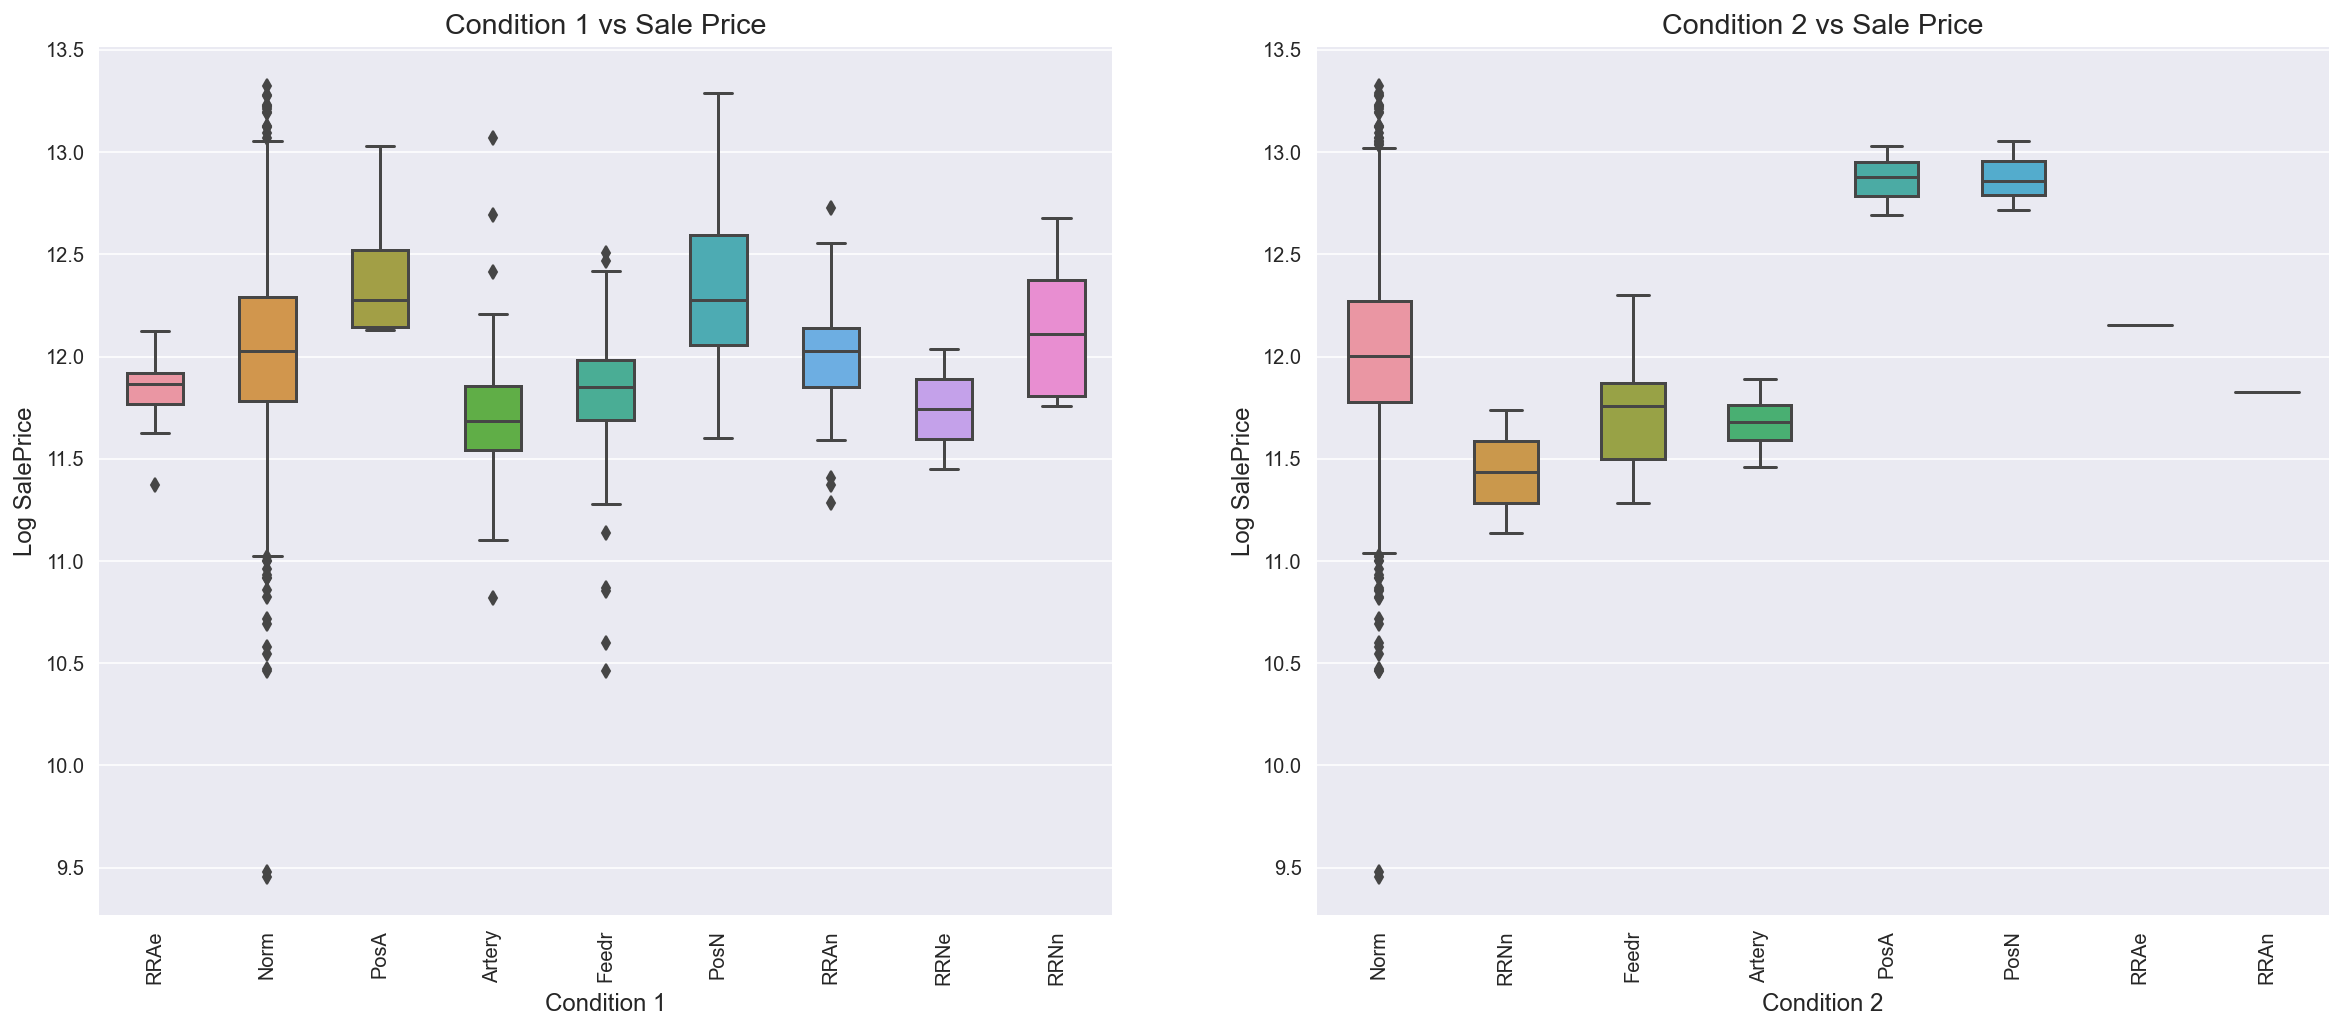

In [35]:
neighbourhood_surrounding = ['Condition 1' , 'Condition 2']
EDA_subplot(1 , 2, neighbourhood_surrounding , df_train)

### 1.4k General Overview on House Type and Functionality
___

- Typical Funtionality can fetch the higher price as expected. The rest of the funtional features will be penalized for its demerit
- Fairly consistent Sale Price for the House style except for the 1.5 Storey Unfinished. Interestingly , a 1 Storey is quite closed to a 2 storey house.
- Building Type Seem faily consistent as well for the 5 house type.
- Non-residential area such as industrial , agriculture ,and commercial are not that popular.

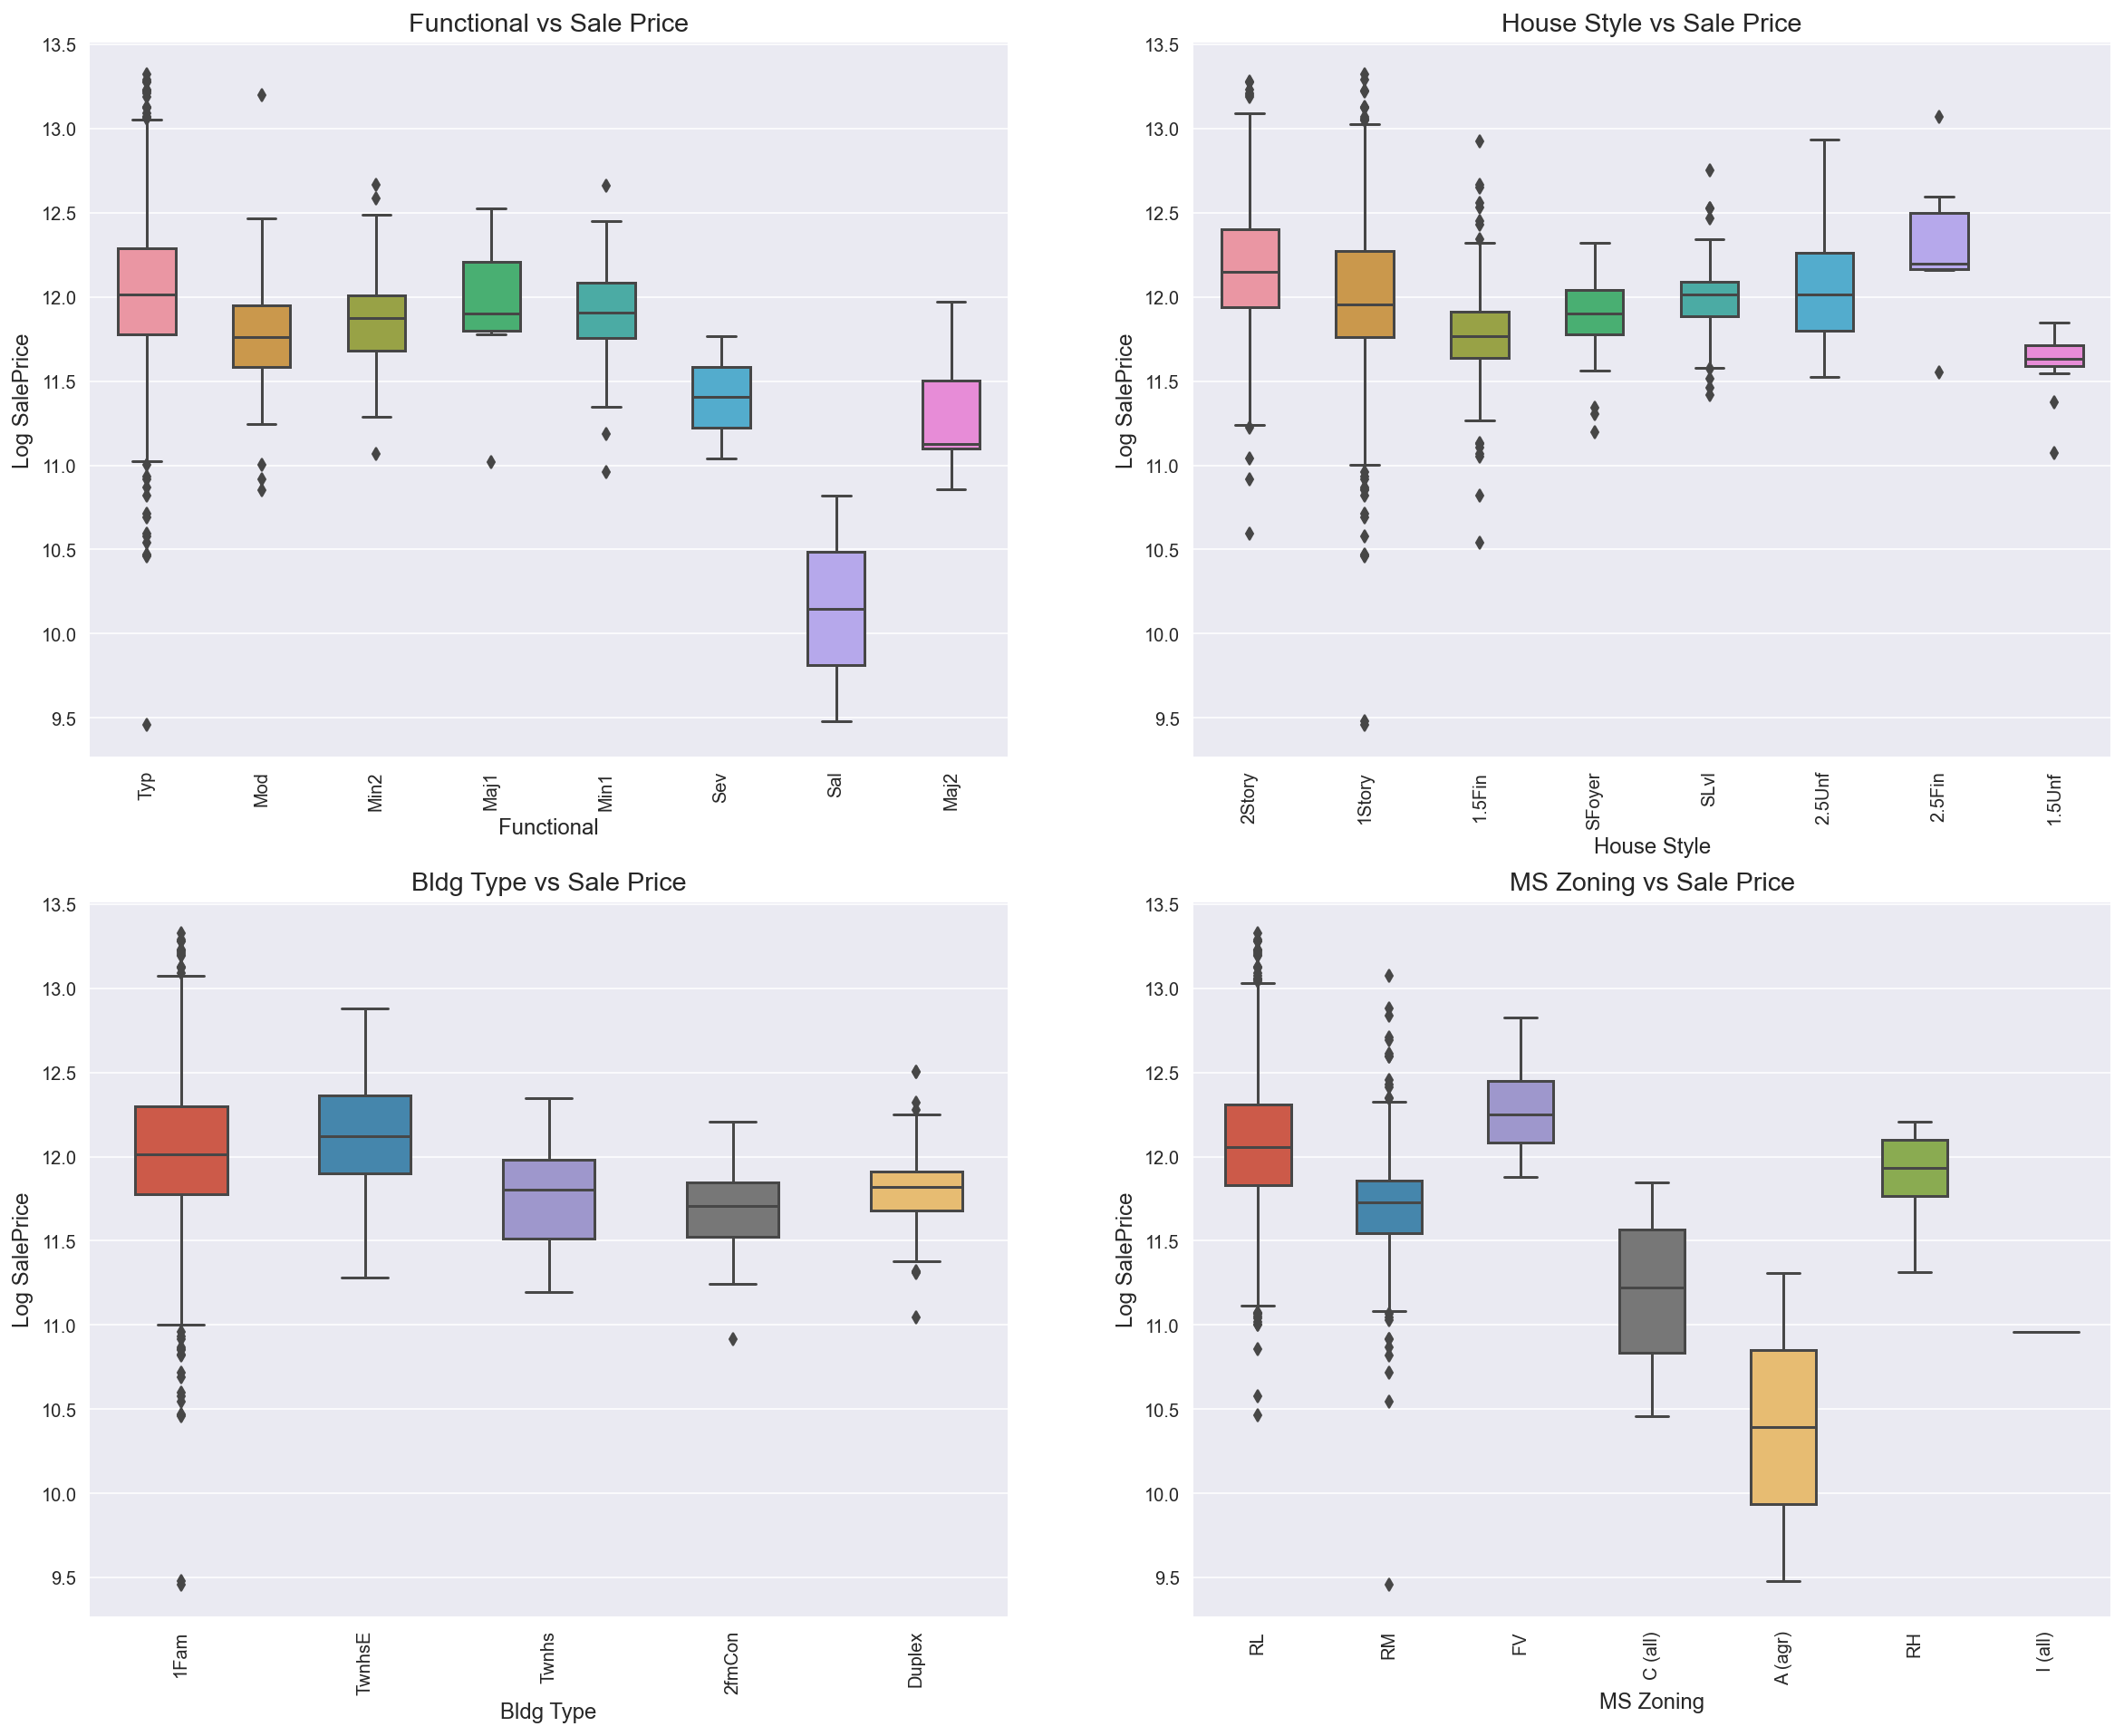

In [36]:
functional = ['Functional' , 'House Style', 'Bldg Type' , 'MS Zoning']
EDA_subplot(2 , 2, functional , df_train)

### 1.5 Standardising Column Name
___
After exploring the features , we observed that many columns contain different abbreviation that meant the same thing. It can be tough remembering too many variables when attempting to call the same category. This section is mean to standardise some of the column name and is more of a personal workstyle.

In [37]:
# Creating a function here for use to preprocess test data
def standardise_col_name(df):
    # Qual , Qu , QC generally refer to the same ordinal output
    df.columns = df.columns.str.replace('Qual' , 'QC').str.replace('Qu' , 'QC')

    # Either standadise to AbvGrd or AbvGr
    df.columns = df.columns.str.replace('TotRms AbvGrd' , 'Totalrooms AbvGr')
    df.columns = df.columns.str.replace('Gr Liv Area' , 'Liv Area AbvGr')

    # Year or Yr
    df.columns = df.columns.str.replace('Year' , 'Yr')
    
    return(df)

In [38]:
standardise_col_name(df_train).head(3)

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   

  Lot Shape Land Contour  ... Misc Feature Misc Val Mo Sold Yr Sold Sale Type  \
0       IR1          Lvl  ...          NaN        0       3    2010       WD    
1       IR1          Lvl  ...          NaN        0       4    2009       WD    
2       Reg          Lvl  ...          NaN        0       1    2010       WD    

  SalePrice Log SalePrice Building Age  Season  Total Porch SF  
0    130500     11.779129           34  Spring              44  
1    220000     12.301383           13  Summer              74  
2    109000     11.599103           57  Spring              52  

[3 rows x 85 columns]

### 1.6 Preprocessing Missing Value
___
Now that we have a better understanding of all the features , it will make our reasoning for preprocessing missing value more logical.

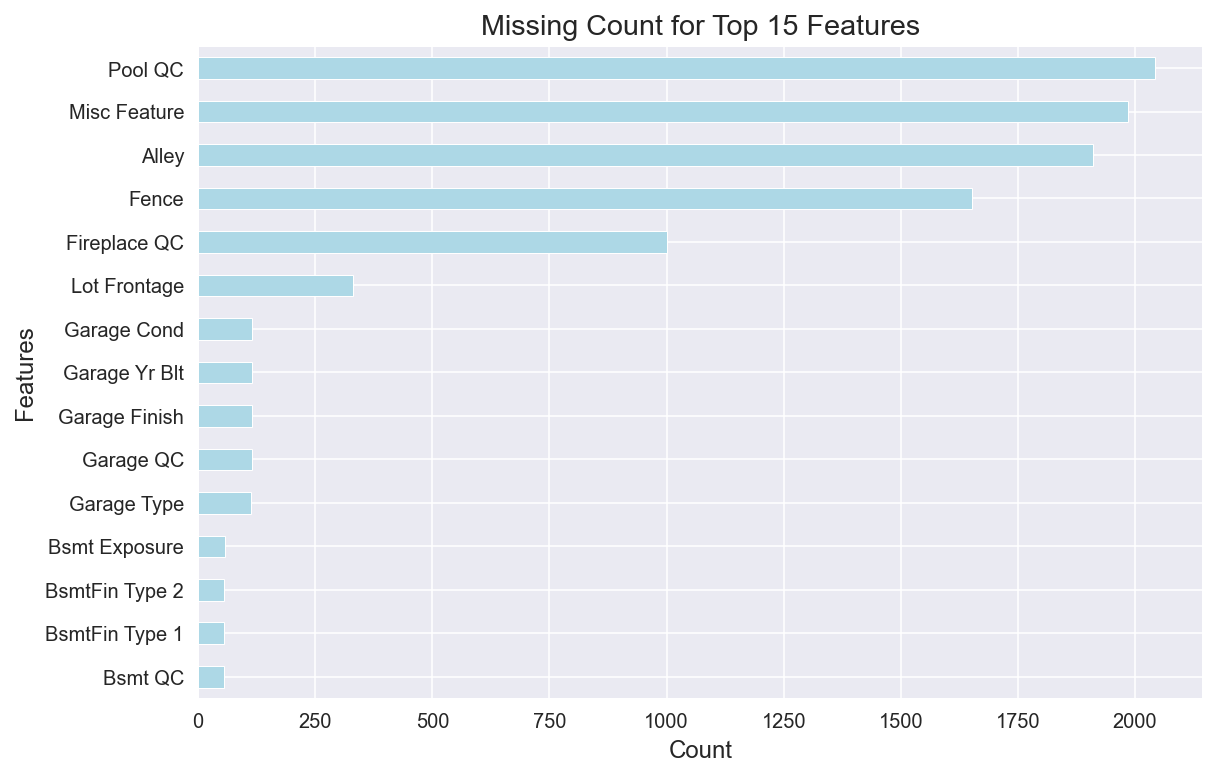

In [39]:
null_plot(df_train)

#### 1.6.1 Pool QC and Pool Area Missing Value
___
- Replace nan with 'NA' and perform minority feature dummify into 1 and 0.

In [40]:
df_train['Pool QC'].unique()

array([nan, 'Fa', 'Gd', 'Ex', 'TA'], dtype=object)

In [41]:
# Since original dataset is so little (8:2050) , we will simplified this column into have_pool instead, having 1 = Yes , 0 = no
minority_feature_dummify(df_train , 'Pool QC')

Before Dummify:
Gd    4
TA    2
Fa    2
Ex    1
Name: Pool QC, dtype: int64
                       
After Dummify:
-1    2042
 1       9
Name: Pool QC, dtype: int64


#### 1.6.2 Misc Features Missing Value
___
- Replace nan with 'NA' and perform minority feature dummify into 1 and 0.

In [42]:
df_train['Misc Feature'].unique()

array([nan, 'Shed', 'TenC', 'Gar2', 'Othr', 'Elev'], dtype=object)

In [43]:
# Since original dataset is so little (65:2050) , we will simplified this column into have_misc instead, having 1 = Yes , 0 = no
minority_feature_dummify(df_train , 'Misc Feature')

Before Dummify:
Shed    56
Gar2     4
Othr     3
Elev     1
TenC     1
Name: Misc Feature, dtype: int64
                       
After Dummify:
-1    1986
 1      65
Name: Misc Feature, dtype: int64


#### 1.6.3 Alley Missing Value
___
- Replace nan with 'NA' and perform minority feature dummify into 1 and 0.

In [44]:
df_train['Alley'].unique()

array([nan, 'Pave', 'Grvl'], dtype=object)

In [45]:
# Since original dataset is so little (140:2050) , we will simplified this column into have_alley instead, having 1 = Yes , 0 = no
minority_feature_dummify(df_train , 'Alley')

Before Dummify:
Grvl    85
Pave    55
Name: Alley, dtype: int64
                       
After Dummify:
-1    1911
 1     140
Name: Alley, dtype: int64


#### 1.6.4 Fence Missing Value
___
- Replace nan with 'NA' and perform minority feature dummify into 1 and 0.

In [46]:
df_train['Fence'].unique()

array([nan, 'MnPrv', 'GdPrv', 'GdWo', 'MnWw'], dtype=object)

In [47]:
# Since original dataset is so little (400:2050) , we will simplified this column into have_fence instead, having 1 = Yes , 0 = no
minority_feature_dummify(df_train , 'Fence')

Before Dummify:
MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: Fence, dtype: int64
                       
After Dummify:
-1    1651
 1     400
Name: Fence, dtype: int64


#### 1.6.5 Fireplace QC Missing Value
___
- Replace nan with 'NA'

In [48]:
df_train['Fireplace QC'].unique()

array([nan, 'TA', 'Gd', 'Po', 'Ex', 'Fa'], dtype=object)

In [49]:
# We will dummifed this column in later section base on ordinal condition
df_train['Fireplace QC'].fillna(value = 'NA',
                         inplace = True)

df_train['Fireplace QC'].value_counts()

NA    1000
Gd     523
TA     407
Fa      59
Po      31
Ex      31
Name: Fireplace QC, dtype: int64

#### 1.6.6 Lot Frontage Missing Value
___
- We will fill missing value in Lot Frontage base on the median of what type that building type is.

In [50]:
# Missing 330 rows of Data
df_train['Lot Frontage'].describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: Lot Frontage, dtype: float64

In [51]:
# We going to fill NaN value in Lot Frontage base on the median of the Building Type
map_cond = df_train.groupby('Bldg Type').median()['Lot Frontage'].to_dict()
map_cond

{'1Fam': 70.0, '2fmCon': 64.0, 'Duplex': 70.0, 'Twnhs': 24.0, 'TwnhsE': 41.0}

In [52]:
# Locate the row where it is np.nan in Lot Frontage
df_lot_nan = df_train['Lot Frontage'].isnull()

# Map the nan row in Lot Frontage base on mapping condition from Bldg Type
df_train.loc[df_lot_nan , 'Lot Frontage'] = df_train.loc[df_lot_nan , 'Bldg Type'].map(map_cond)

#### 1.6.7 Garage Feature Missing Value
___
As we recalled from earlier section 1.5 on Garage Features :
- Total 8 features for Basement : 
    - 3 numeric features : [Garage Yr Blt , Garage Cars , Garage Area]
    - 3 non-numeric ordinal features : [Garage QC , Garage Cond , Paved Drive]
    - 2 non-numeric , non-ordinal features : [Garage Type , Garage Finish]
    
- There are some houses that simply does not have a Garage , thus the consistencies of the nan value across a row.
- There is a row in Garage Type that is Detchd , and nan for the rest of its feature.
- The datatype in index 1712 for Garage Cars and Area should be 0 instead of np.nan

In [53]:
# Finding Houses with no Garage

garage_list_nan = [garage for garage in df_train.columns if 'Garage' in garage]

In [54]:
# There is a row in Garage Type that have a value , and nan for the rest of its feature.
df_train[df_train['Garage Yr Blt'].isna()][garage_list_nan].sort_values(by = 'Garage Type').head()

Garage Type  Garage Yr Blt Garage Finish  Garage Cars  Garage Area  \
1712      Detchd            NaN           NaN          NaN          NaN   
28           NaN            NaN           NaN          0.0          0.0   
53           NaN            NaN           NaN          0.0          0.0   
65           NaN            NaN           NaN          0.0          0.0   
79           NaN            NaN           NaN          0.0          0.0   

     Garage QC Garage Cond  
1712       NaN         NaN  
28         NaN         NaN  
53         NaN         NaN  
65         NaN         NaN  
79         NaN         NaN

In [55]:
# Replacing non numeric Garage feature with NA

df_train.loc[1712 , 'Garage Type'] = 'NA'

for col_name , data in df_train[garage_list_nan].items():
    if not pd.api.types.is_numeric_dtype(data):
        df_train[col_name].fillna(value = 'NA', inplace = True)
    else:
        df_train[col_name].fillna(value = 0 , inplace = True)

#### 1.6.8 Basement Feature Missing Value
___
As we recalled frome arlier section 1.5 on Basement Features :
- Total 11 features for Basement : 
    - 6 numeric features : [BsmtFin SF 1, BsmtFin SF 2 , Bsmt Unf SF , Total Bsmt SF , Bsmt Full Bath , Bsmt Half Bath]
    - 4 non-numeric ordinal features : ['Bsmt Qual', 'Bsmt Cond' , 'BsmtFin Type 1' , 'BsmtFin Type 2']
    - 1 non-numeric , non-ordinal features : ['Bsmt Exposure']
    
- There are some houses that simply does not have Basement , thus the consistency of the nan value across a row.
- There are 3 rows in Basement Type that have a value , and nan for the rest of its feature.
- There are 2 inconsistency for bsmt features with Bsmt SF

In [56]:
# Finding houses with no Basement
basement_list = [bsmt for bsmt in df_train.columns if 'Bsmt' in bsmt]

df_train[df_train['Bsmt Exposure'].isnull()][basement_list].sort_values(by = 'Bsmt QC').head()

Bsmt QC Bsmt Cond Bsmt Exposure BsmtFin Type 1  BsmtFin SF 1  \
1456      Gd        TA           NaN            Unf           0.0   
1547      Gd        TA           NaN            Unf           0.0   
1997      Gd        TA           NaN            Unf           0.0   
12       NaN       NaN           NaN            NaN           0.0   
93       NaN       NaN           NaN            NaN           0.0   

     BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Bsmt Full Bath  \
1456            Unf           0.0        725.0          725.0             0.0   
1547            Unf           0.0       1595.0         1595.0             0.0   
1997            Unf           0.0        936.0          936.0             0.0   
12              NaN           0.0          0.0            0.0             0.0   
93              NaN           0.0          0.0            0.0             0.0   

      Bsmt Half Bath  
1456             0.0  
1547             0.0  
1997             0.0  
12               0.0  
93               0.0

In [57]:
# Base on most Basement Type 1 with Unf & Bsmt Cond with TA , the mode value for BSMT Exposure is 'No'.
df_train.loc[df_train['BsmtFin Type 1'] == 'Unf' , :][['BsmtFin Type 1' , 'Bsmt Exposure']].value_counts()

BsmtFin Type 1  Bsmt Exposure
Unf             No               478
                Av                62
                Mn                41
                Gd                19
dtype: int64

In [58]:
# Inconsistency where rows have NaN and 0 : See ID 616

df_train[df_train['Bsmt Full Bath'].isnull()][basement_list].sort_values(by = 'Bsmt Full Bath').head()

Bsmt QC Bsmt Cond Bsmt Exposure BsmtFin Type 1  BsmtFin SF 1  \
616      NaN       NaN           NaN            NaN           0.0   
1327     NaN       NaN           NaN            NaN           NaN   

     BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Bsmt Full Bath  \
616             NaN           0.0          0.0            0.0             NaN   
1327            NaN           NaN          NaN            NaN             NaN   

      Bsmt Half Bath  
616              NaN  
1327             NaN

In [59]:
# Replacing 3 outlier Bsmt Exposure feature with No

df_train.loc[1456 , 'Bsmt Exposure'] = 'No'
df_train.loc[1547 , 'Bsmt Exposure'] = 'No'
df_train.loc[1997 , 'Bsmt Exposure'] = 'No'

In [60]:
# Replacing the numeric nan value in basement feature with 0 and non-numeric nan value with 'NA'
for col_name , data in df_train[basement_list].items():
    if pd.api.types.is_numeric_dtype(data):
        df_train[col_name].fillna(value = 0 , inplace = True)
    else:
        df_train[col_name].fillna(value = 'NA' , inplace = True)        

### 1.6.9 Masonary Feature Missing Value
___

-  Recall from above visualisation from section 1.5 , there are 2 features on Masonary:
    - Mas Vnr Type : 4 Non-ordinal features : BrkFace , None , Stone , BrkCmn
    - Mas Vnr Area : Numerical 
    
-  No. of Nan value for Vnr Type and Vnr Area is the same. Thus we can safely conclude that Masonary feature is not present in the same 22 houses.
- For Numeric features , we will fillna with 0.
- For Non-Numeric Feature , we will fillna with None

In [61]:
df_train['Mas Vnr Type'].unique()

array(['BrkFace', 'None', nan, 'Stone', 'BrkCmn'], dtype=object)

In [62]:
# No. of Nan value for Vnr Type and Vnr Area is the same. 
# Thus we can safely conclude that Masonary feature is not present in these 22 houses.

mas_list = [mas for mas in df_train if 'Mas' in mas]
df_train[df_train['Mas Vnr Type'].isnull()][mas_list].head()

Mas Vnr Type  Mas Vnr Area
22           NaN           NaN
41           NaN           NaN
86           NaN           NaN
212          NaN           NaN
276          NaN           NaN

In [63]:
# For Numeric features , we will fillna with 0.
# For Non-Numeric Feature , we will fillna with 'None'.

df_train['Mas Vnr Type'].fillna(value = 'None' , inplace = True)
df_train['Mas Vnr Area'].fillna(value = 0 , inplace = True)

### 1.6.10 Summary of DF after preprocessing Missing Value
___

In [64]:
print(f'Total null elements in df: {df_train.isnull().sum().sum()}')

Total null elements in df: 0


### 1.7 Preprocessing Outliers
___

From earlier visualisation , some of the outlier can be shown very clearly from the plots. In this section , we will clean those outliers up before dummifying the columns in Section 2.0.

- PSF : PSF > 50 and PSF <250 `(Removed 20 datapoints)`
- Garage Yr Blt : Go back 200 year to the future and bring it back to the correct year.
- Lot Area : Remove `2 datapoints` for abnormally large Lot Area.
- Kicthens : House or Restaurant? Remove `1 special house` with 3 kitchens.

### 1.7.1 Low PSF Outliers observed for Large Basement , Large SF Area
___

In [65]:
# Creating a new feature Call PSF (Price per Square FT)
df_train['PSF'] = df_train['SalePrice'] / df_train['Liv Area AbvGr'] 

In [66]:
# 10 extreme outliers with very low PSF (less than $50 PSF).. where got so cheap one....
# We remove below $50PSF because of outliers , and we remove above $250 because of extreme outlier (20 Data point)

df_train[['Liv Area AbvGr' , 'SalePrice' , 'PSF']].sort_values(by = 'PSF' , ascending = True).head()

Liv Area AbvGr  SalePrice        PSF
1628             832      12789  15.371394
183              733      13100  17.871760
960             5642     160000  28.358738
162             2128      62500  29.370301
408             1317      40000  30.372058

In [67]:
# Super Large Basement Base... As large As Liv Area above Ground
df_train[['Total Bsmt SF' ,'Liv Area AbvGr']].sort_values(by = 'Total Bsmt SF' , ascending = False).head()

Total Bsmt SF  Liv Area AbvGr
960          6110.0            5642
1885         5095.0            5095
1147         3206.0            1629
328          3200.0            3228
1164         3094.0            2402

In [68]:
print(f'Df shape before remove rows : {df_train.shape}')

df_train = df_train[(df_train['PSF'] > 50) & (df_train['PSF'] < 250)]

print(f'Df shape after remove rows : {df_train.shape}')

Df shape before remove rows : (2051, 86)
Df shape after remove rows : (2031, 86)


### 1.7.2 Garage Back to the Future (Yr 2207 to Yr 2007)
___

In [69]:
# More than 10% difference between the largest and 2nd largest
df_train['Garage Yr Blt'].sort_values(ascending = False).head()

1699    2207.0
144     2010.0
1241    2010.0
625     2009.0
1732    2009.0
Name: Garage Yr Blt, dtype: float64

In [70]:
df_train.loc[1699 , 'Garage Yr Blt'] = 2007

### 1.7.3 Super Large Lot Area
___

In [71]:
# 2 extremely large lot area.
df_train[['Lot Area' , 'Liv Area AbvGr']].sort_values(by = 'Lot Area' , ascending = False).head()

Lot Area  Liv Area AbvGr
471     159000            2144
694     115149            1824
1854     70761            1533
745      57200            1687
823      53504            3279

In [72]:
print(f'Df shape before remove rows : {df_train.shape}')

df_train = df_train[df_train['Lot Area'] < 100000]

print(f'Df shape after remove rows : {df_train.shape}')

Df shape before remove rows : (2031, 86)
Df shape after remove rows : (2029, 86)


### 1.7.4 Is this a restaurant? - This house has 3 kitchens
___



In [73]:
print(f'No. of Kitchens : \n -------------\n{df_train["Kitchen AbvGr"].value_counts()}')
print(f'Df shape before remove rows : {df_train.shape}')

df_train = df_train[df_train['Kitchen AbvGr'] < 3]

print(f'Df shape after remove rows : {df_train.shape}')

No. of Kitchens : 
 -------------
1    1943
2      84
0       2
Name: Kitchen AbvGr, dtype: int64
Df shape before remove rows : (2029, 86)
Df shape after remove rows : (2029, 86)


# 2.0 Feature Engineeering
___

- 2.1 Dummfying Ordinal feature with pre-defined dictionary
- 2.2 Dummfying Non-Ordinal Categorical feature with pd.Categorical(data).codes
- 2.3 Experimenting Additional Features and Visualing New Features
- 2.4 Checking for Multi-Collinearity

### 2.1 Dummfying Ordinal Categorical Feature
___

Note that we had given some negative score to penalize the negataive connonatation that some of the feature values had recorded. Also, for most of the N.A. features which typically absent , we had set a baseline of 0 score for those.

| Ordinal Feature | Location of House | Description |
|---|---|---|
| Bsmt QC<br>Garage QC<br>Fireplace QC<br>Exter QC | Common QC Feature | 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,'NA': 0 |
| Bsmt Cond<br>Garage Cond<br>Fireplace Cond<br>Exter Cond | Common Cond Feature | 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,'NA': 0 |
| Bsmt Exposure | Basement | 'Av': 3, 'Mn': 2, 'No': 1 |
| BsmtFin Type 1 | Basement | 'GLQ':3, 'ALQ':2, 'BLQ':1, 'Rec':1, 'LwQ':1, 'Unf':0 |
| BsmtFin Type 2 | Basement | 'GLQ':3, 'ALQ':2, 'BLQ':1, 'Rec':1, 'LwQ':1, 'Unf':0  |
| Garage Finish | Garage | 'Fin': 2, 'RFn': 1, 'Unf':0 |
| Paved Drive | Garage | 'Y' : 2, 'P' : 1, 'N' : 0, |
| Lot Shape | Land Plot Feature | 'Reg':4, 'IR1':3, 'IR2':2, 'IR3':1, |
| Land Slope | Land Plot Feature | 'Gtl':1, 'Mod':0,'Sev':-1 |
| Electrical | Heating & Utilities | 'SBrkr':4, 'FuseA':3, 'FuseF':2, 'FuseP':1, 'Mix':0, |
| Utilities | Heating & Utilities | 'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO':1 |
| Functional | House Type & Functionality | 'Typ':0, 'Min1':-1, 'Min2':-2, 'Mod':-3, 'Maj1':-4,'Maj2':-5,'Sev':-6,'Sal':-7 |
| House Style | House Type & Functionality | '1.5Unf':1.5, '1.5Fin':1.5, 'SFoyer':3, 'SLvl':3, '1Story':1, '2.5Unf':2.5, '2Story':2, '2.5Fin':2.5 |
| Neighborhood|Neighborhood|neighbor_dict|
| Condition 1 <br> Condition 2 |Neighborhood| 'RRAe' : -1 , 'RRAn' : -1 , 'RRNe' : 0 , 'RRNn' : 0 , 'PosN' : 3, 'PosA' : 3 ,'Artery' : 0 , 'Feedr' : 2 , 'Norm' : 1|

In [74]:
# Creating ordinal dict for non-numeric features
    
ordinal_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,'NA': 0,
                # Basement Features
                'GLQ':3, 'ALQ':2, 'BLQ':1, 'Rec':1, 'LwQ':1, 'Unf':0, 
                'Gd' : 4, 'Av': 3, 'Mn': 1, 'No': 0, 
                #Garage Features
                'Fin': 2, 'RFn': 1, 'Unf':0,
                 'Y' : 2, 'P' : 1, 'N' : 0,
                # Land Plot and Housing Feature
                'Reg':4, 'IR1':3, 'IR2':2, 'IR3':1,
                'Gtl':1, 'Mod':0,'Sev':-1,
                'Typ':0, 'Min1':-1, 'Min2':-2, 'Mod':-3, 'Maj1':-4,'Maj2':-5,'Sev':-6,'Sal':-7,
                'Grvl' : -1, 'Pave' : 1,
                'RRAe' : -1 , 'RRAn' : -1 , 'RRNe' : 0 , 'RRNn' : 0 , 'PosN' : 3, 'PosA' : 3 , 
                'Artery' : 0 , 'Feedr' : 2 , 'Norm' : 1,
                '1.5Unf':1.5, '1.5Fin':1.5, 'SFoyer':3, 'SLvl':3, '1Story':1, '2.5Unf':2.5, '2Story':2, '2.5Fin':2.5,
                # Heating and Utilities Related
                'SBrkr':4, 'FuseA':3, 'FuseF':2, 'FuseP':1, 'Mix':0, np.nan : -1,
                'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO':1
               }                  

In [75]:
# Create Pre-processing function block here to apply for train and test data later on.
def ordinal_dummy(df):
    # Replacing ordinal categorical feature with pre-defined dictionary
    for col_name , data in df.items():
        if not pd.api.types.is_numeric_dtype(data):
            df.replace({col_name:ordinal_dict} , inplace = True)
            
    # Replacing neighborhood feature with pre-defined dictionary
    for col_name , data in df.items():
        if not pd.api.types.is_numeric_dtype(data):
            df.replace({col_name:neighbor_dict} , inplace = True)
    
    return(df)

In [76]:
# Dummy ordinal features
ordinal_dummy(df_train)

# Check Ordinal Features after dummy
pd.set_option('display.max_columns', None)
df_train.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  Street  \
0  109  533352170           60        RL          70.0     13517       1   
1  544  531379050           60        RL          43.0     11492       1   
2  153  535304180           20        RL          68.0      7922       1   
3  318  916386060           60        RL          73.0      9802       1   
4  255  906425045           50        RL          82.0     14235       1   

   Alley  Lot Shape Land Contour  Utilities Lot Config  Land Slope  \
0     -1          3          Lvl          4    CulDSac           1   
1     -1          3          Lvl          4    CulDSac           1   
2     -1          4          Lvl          4     Inside           1   
3     -1          4          Lvl          4     Inside           1   
4     -1          3          Lvl          4     Inside           1   

   Neighborhood  Condition 1  Condition 2 Bldg Type  House Style  Overall QC  \
0             2           -1            1      1Fam          2.0           6   
1             3            1            1      1Fam          2.0           7   
2             2            1            1      1Fam          1.0           5   
3             3            1            1      1Fam          2.0           5   
4             3            1            1      1Fam          1.5           6   

   Overall Cond  Yr Built  Yr Remod/Add Roof Style Roof Matl Exterior 1st  \
0             8      1976          2005      Gable   CompShg      HdBoard   
1             5      1996          1997      Gable   CompShg      VinylSd   
2             7      1953          2007      Gable   CompShg      VinylSd   
3             5      2006          2007      Gable   CompShg      VinylSd   
4             8      1900          1993      Gable   CompShg      Wd Sdng   

  Exterior 2nd Mas Vnr Type  Mas Vnr Area  Exter QC  Exter Cond Foundation  \
0      Plywood      BrkFace         289.0         4           3     CBlock   
1      VinylSd      BrkFace         132.0         4           3      PConc   
2      VinylSd         None           0.0         3           4     CBlock   
3      VinylSd         None           0.0         3           3      PConc   
4      Plywood         None           0.0         3           3      PConc   

   Bsmt QC  Bsmt Cond  Bsmt Exposure  BsmtFin Type 1  BsmtFin SF 1  \
0        3          3              0               3         533.0   
1        4          3              0               3         637.0   
2        3          3              0               3         731.0   
3        4          3              0               0           0.0   
4        2          4              0               0           0.0   

   BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF Heating  \
0               0           0.0        192.0          725.0    GasA   
1               0           0.0        276.0          913.0    GasA   
2               0           0.0        326.0         1057.0    GasA   
3               0           0.0        384.0          384.0    GasA   
4               0           0.0        676.0          676.0    GasA   

   Heating QC  Central Air  Electrical  1st Flr SF  2nd Flr SF  Low QC Fin SF  \
0           5            2           4         725         754              0   
1           5            2           4         913        1209              0   
2           3            2           4        1057           0              0   
3           4            2           4         744         700              0   
4           3            2           4         831         614              0   

   Liv Area AbvGr  Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  \
0            1479             0.0             0.0          2          1   
1            2122             1.0             0.0          2          1   
2            1057             1.0             0.0          1          0   
3            1444             0.0             0.0          2          1   
4  

### 2.2 Dummfying Non - Ordinal Categorical Feature
___

In [77]:
def category_dummy(df):

    for col_name , data in df.items():
        if not pd.api.types.is_numeric_dtype(data):
            df[col_name] = pd.Categorical(data).codes + 1
    
    return(df)

In [78]:
# Dummy categorical features
category_dummy(df_train).head(3)

pd.set_option('display.max_columns', None)
df_train.head(3)

Id        PID  MS SubClass  MS Zoning  Lot Frontage  Lot Area  Street  \
0  109  533352170           60          6          70.0     13517       1   
1  544  531379050           60          6          43.0     11492       1   
2  153  535304180           20          6          68.0      7922       1   

   Alley  Lot Shape  Land Contour  Utilities  Lot Config  Land Slope  \
0     -1          3             4          4           2           1   
1     -1          3             4          4           2           1   
2     -1          4             4          4           5           1   

   Neighborhood  Condition 1  Condition 2  Bldg Type  House Style  Overall QC  \
0             2           -1            1          1          2.0           6   
1             3            1            1          1          2.0           7   
2             2            1            1          1          1.0           5   

   Overall Cond  Yr Built  Yr Remod/Add  Roof Style  Roof Matl  Exterior 1st  \
0             8      1976          2005           2          1             7   
1             5      1996          1997           2          1            13   
2             7      1953          2007           2          1            13   

   Exterior 2nd  Mas Vnr Type  Mas Vnr Area  Exter QC  Exter Cond  Foundation  \
0            10             2         289.0         4           3           2   
1            13             2         132.0         4           3           3   
2            13             3           0.0         3           4           2   

   Bsmt QC  Bsmt Cond  Bsmt Exposure  BsmtFin Type 1  BsmtFin SF 1  \
0        3          3              0               3         533.0   
1        4          3              0               3         637.0   
2        3          3              0               3         731.0   

   BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Heating  \
0               0           0.0        192.0          725.0        1   
1               0           0.0        276.0          913.0        1   
2               0           0.0        326.0         1057.0        1   

   Heating QC  Central Air  Electrical  1st Flr SF  2nd Flr SF  Low QC Fin SF  \
0           5            2           4         725         754              0   
1           5            2           4         913        1209              0   
2           3            2           4        1057           0              0   

   Liv Area AbvGr  Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  \
0            1479             0.0             0.0          2          1   
1            2122             1.0             0.0          2          1   
2            1057             1.0             0.0          1          0   

   Bedroom AbvGr  Kitchen AbvGr  Kitchen QC  Totalrooms AbvGr  Functional  \
0              3              1           4                 6           0   
1              4              1           4                 8           0   
2              3              1           4                 5           0   

   Fireplaces  Fireplace QC  Garage Type  Garage Yr Blt  Garage Finish  \
0           0             0            3         1976.0              1   
1           1             3            3         1997.0              1   
2           0             0            7         1953.0              0   

   Garage Cars  Garage Area  Garage QC  Garage Cond  Paved Drive  \
0          2.0        475.0          3            3            2   
1          2.0        559.0          3            3            2   
2          1.0        246.0          3            3            2   

   Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  Screen Porch  \
0             0             44               0           0             0   
1             0             74               0           0             0   
2             0             52               0           0             0   

   Pool Area  Pool QC  Fence  Misc Feature  Misc Val  M

### 2.3 Experimenting Additional Features and Visualing New Features
___
Some of the features had been created previously and visualised, while new features are further added below.

| New Features | Word Description | Reference |
|---|---|---|
| Log SalePrice  | Log of the Sales Price | Section 1.4 |
| PSF | Liv Area AbvGr / SalePrice | Section 1.7.1 |
| Total Porch SF  | Sum of all 5 Porch Features | Section 1.4e |
| Building Age | (Year Modified OR Year Built) - Year Sold | Section 1.4a |
| Season| Season base on Month| Section 1.4d|
| Total Bath| Sum of all Bath in Basement & AbvGr| Section 2.3|
| Overall Score| Overall QC + Overall Cond | Section 2.3|
| Garage Score| Garage QC + Garage Cond | Section 2.3|
| Exter Score| Exter QC + Exter Cond | Section 2.3|
| Bsmt Score| Bsmt QC + Bsmt Cond | Section 2.3|
| Kitchen Score| 2 x Kitchen QC + No.of Kitchen | Section 2.3|
| Fireplace Score| 2 x Fireplace QC + No.of Fireplace | Section 2.3|
| Neighborhood Score| Condition 1 + Condition 2 + 0.5 x Street + 0.5 x Alley | Section 2.3|

In [79]:
# Create Pre-processing function bloc here to apply for train and test data later on.
def feature_addition(df):
    bath_list = [bath for bath in df.columns if 'Bath' in bath]

    df['Total Bath'] = df[bath_list].sum(axis = 1)

    # Area Relation
    df['Total SF'] = df['Liv Area AbvGr'] + df['Total Bsmt SF']
    # Quality and Condition Relation
    df['Overall Score'] = df['Overall QC'] + df['Overall Cond']
    df['Garage Score'] = df['Garage QC'] + df['Garage Cond'] + df['Paved Drive']
    df['Exter Score'] = df['Exter QC'] + df['Exter Cond'] 
    df['Bsmt Score'] = df['Bsmt QC'] + df['Bsmt Cond'] 
    df['Kitchen Score'] = 2*df['Kitchen QC'] + df['Kitchen AbvGr']
    df['Fireplace Score'] = 2*df['Fireplace QC'] * df['Fireplaces'] 
    df['Neighborhood Score'] = df['Condition 1'] + df['Condition 2'] + 0.5*df['Street'] + 0.5*df['Alley']
    
    return(df)

    print(f'Final Data Set after pre-process: {df.shape}')

In [80]:
feature_addition(df_train).head(3)

Id        PID  MS SubClass  MS Zoning  Lot Frontage  Lot Area  Street  \
0  109  533352170           60          6          70.0     13517       1   
1  544  531379050           60          6          43.0     11492       1   
2  153  535304180           20          6          68.0      7922       1   

   Alley  Lot Shape  Land Contour  Utilities  Lot Config  Land Slope  \
0     -1          3             4          4           2           1   
1     -1          3             4          4           2           1   
2     -1          4             4          4           5           1   

   Neighborhood  Condition 1  Condition 2  Bldg Type  House Style  Overall QC  \
0             2           -1            1          1          2.0           6   
1             3            1            1          1          2.0           7   
2             2            1            1          1          1.0           5   

   Overall Cond  Yr Built  Yr Remod/Add  Roof Style  Roof Matl  Exterior 1st  \
0             8      1976          2005           2          1             7   
1             5      1996          1997           2          1            13   
2             7      1953          2007           2          1            13   

   Exterior 2nd  Mas Vnr Type  Mas Vnr Area  Exter QC  Exter Cond  Foundation  \
0            10             2         289.0         4           3           2   
1            13             2         132.0         4           3           3   
2            13             3           0.0         3           4           2   

   Bsmt QC  Bsmt Cond  Bsmt Exposure  BsmtFin Type 1  BsmtFin SF 1  \
0        3          3              0               3         533.0   
1        4          3              0               3         637.0   
2        3          3              0               3         731.0   

   BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Heating  \
0               0           0.0        192.0          725.0        1   
1               0           0.0        276.0          913.0        1   
2               0           0.0        326.0         1057.0        1   

   Heating QC  Central Air  Electrical  1st Flr SF  2nd Flr SF  Low QC Fin SF  \
0           5            2           4         725         754              0   
1           5            2           4         913        1209              0   
2           3            2           4        1057           0              0   

   Liv Area AbvGr  Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  \
0            1479             0.0             0.0          2          1   
1            2122             1.0             0.0          2          1   
2            1057             1.0             0.0          1          0   

   Bedroom AbvGr  Kitchen AbvGr  Kitchen QC  Totalrooms AbvGr  Functional  \
0              3              1           4                 6           0   
1              4              1           4                 8           0   
2              3              1           4                 5           0   

   Fireplaces  Fireplace QC  Garage Type  Garage Yr Blt  Garage Finish  \
0           0             0            3         1976.0              1   
1           1             3            3         1997.0              1   
2           0             0            7         1953.0              0   

   Garage Cars  Garage Area  Garage QC  Garage Cond  Paved Drive  \
0          2.0        475.0          3            3            2   
1          2.0        559.0          3            3            2   
2          1.0        246.0          3            3            2   

   Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  Screen Porch  \
0             0             44               0           0             0   
1             0             74               0           0             0   
2             0             52               0           0             0   

   Pool Area  Pool QC  Fence  Misc Feature  Misc Val  M

- Some of the new combined features exhibit linear relation , such as Overall Score , Exter Score , BMST Score , FIreplace Score.

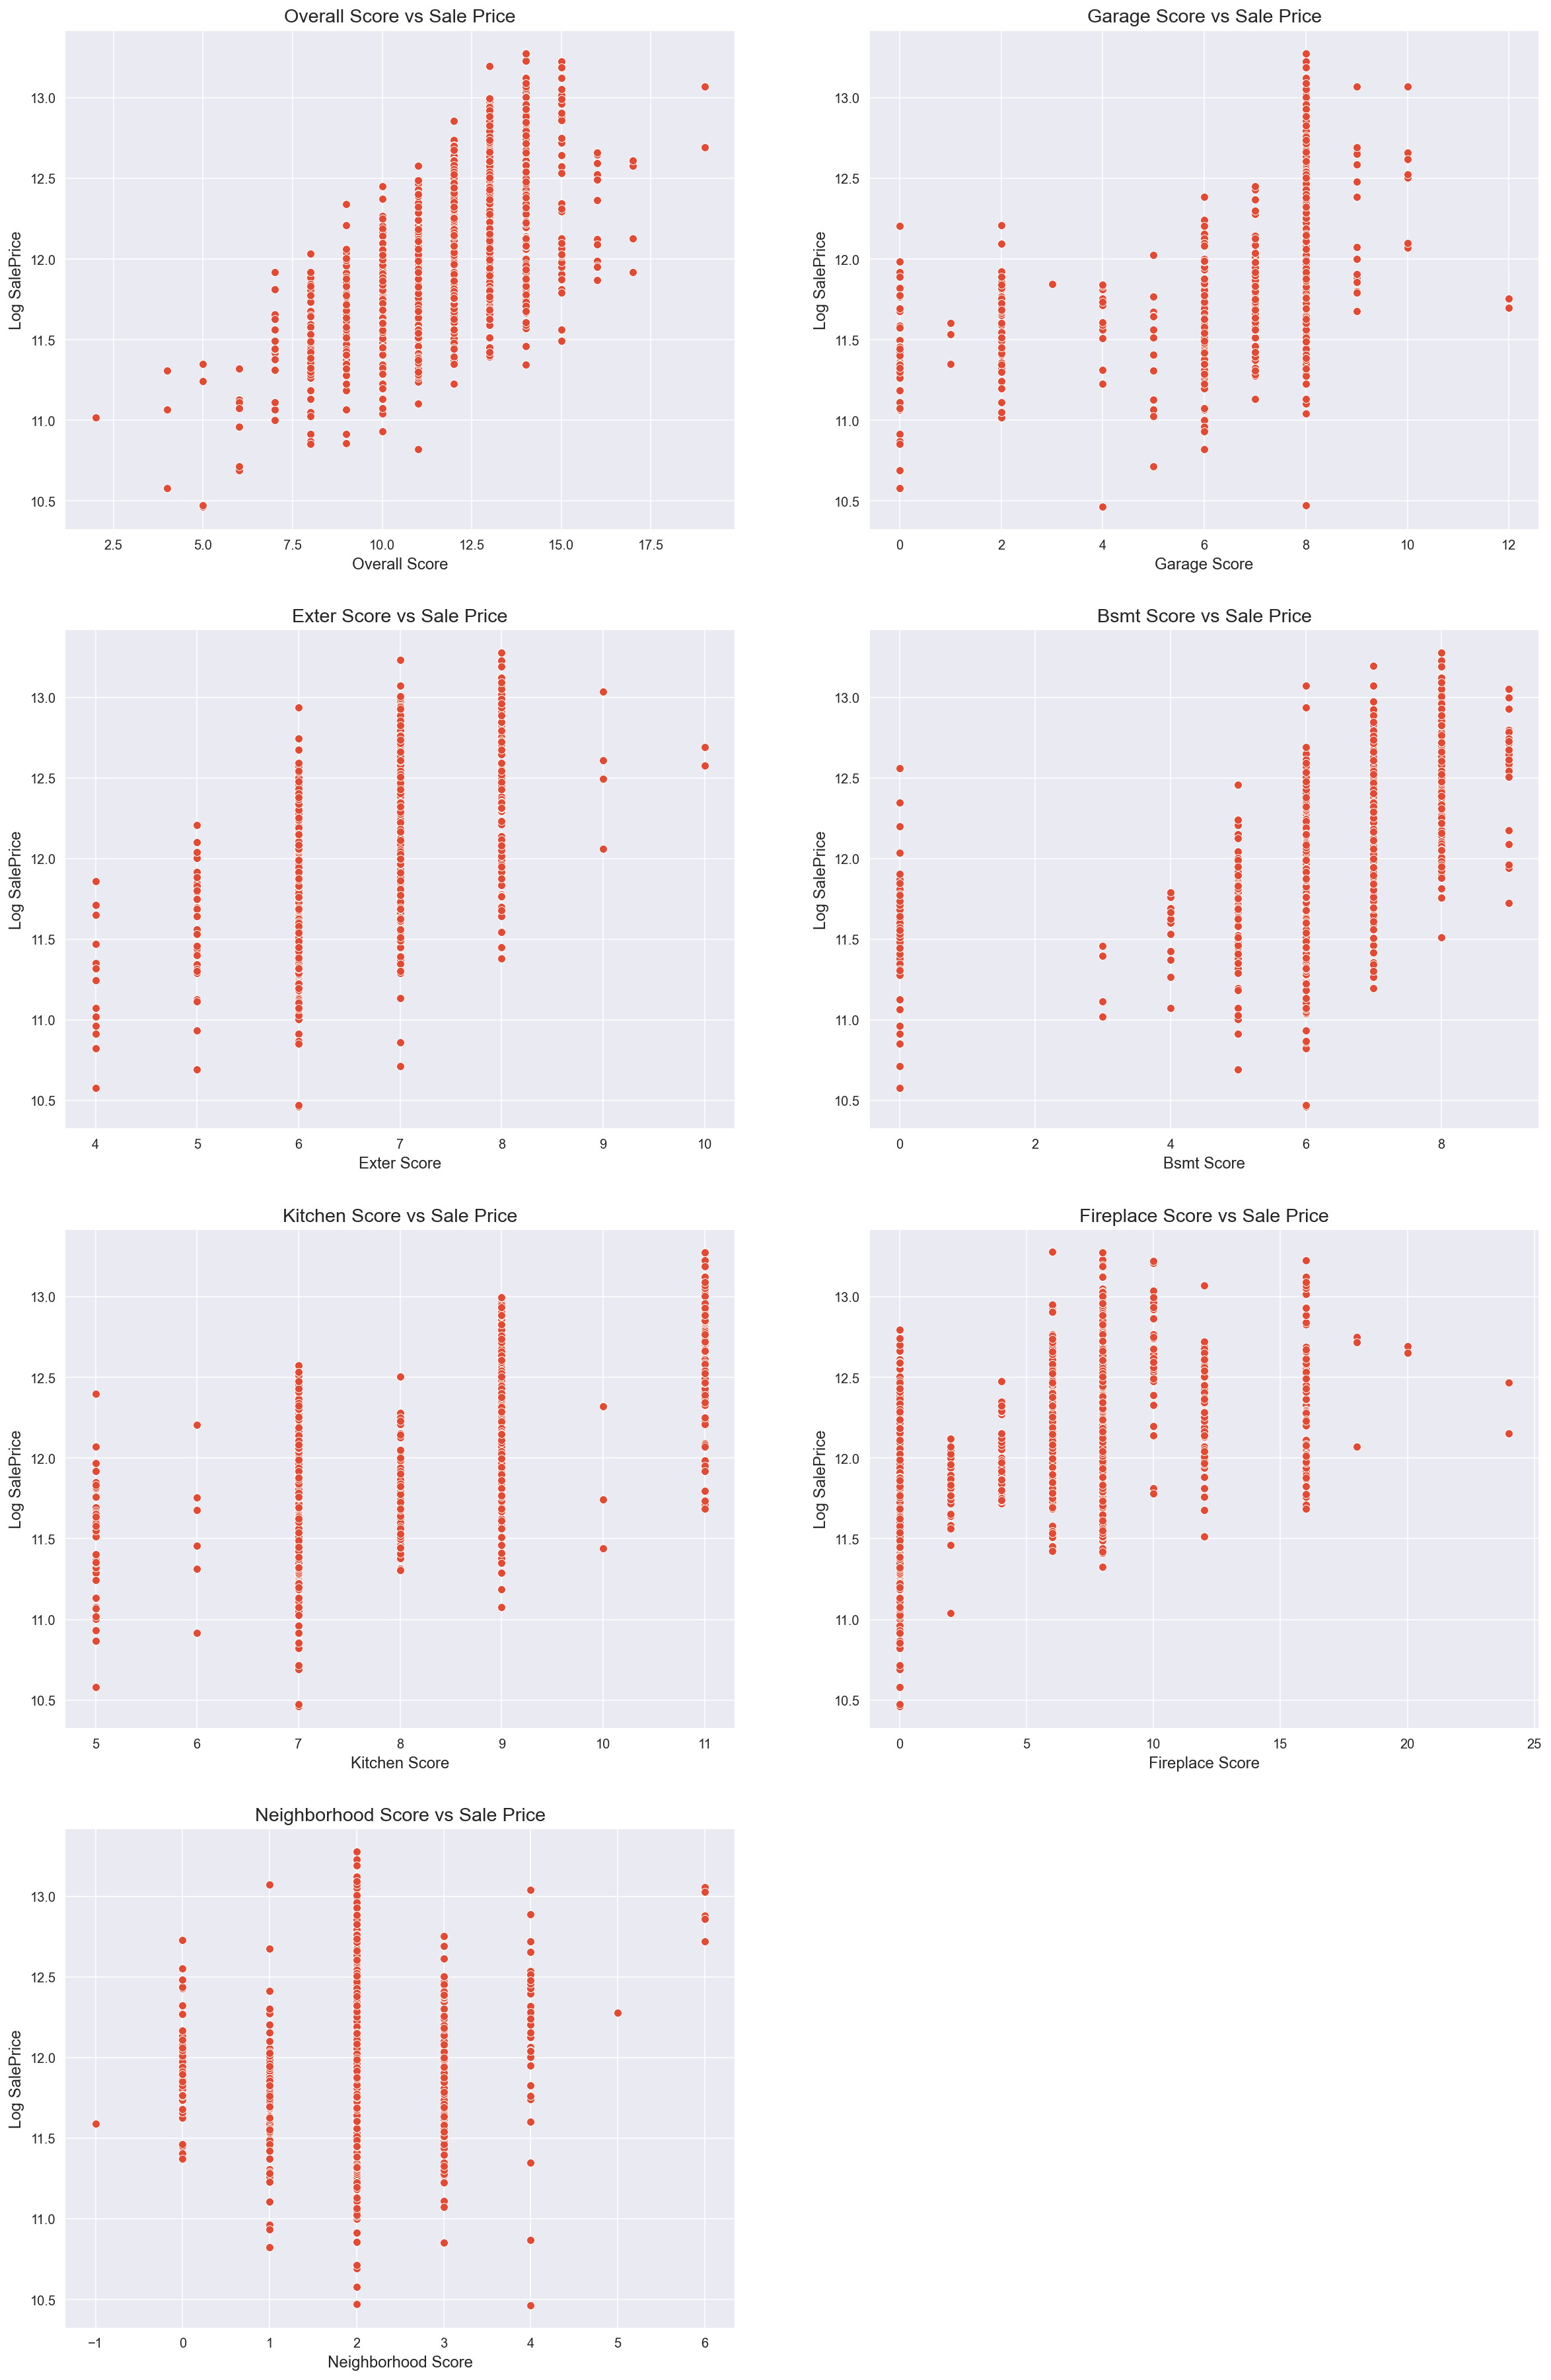

In [81]:
list_score = [score for score in df_train.columns if 'Score' in score]
EDA_subplot(4 ,2 , list_score , df_train)

### 2.4 Checking for Multi-Collinearity
___

* Well I tried experimenting with passing the DF into a VIF function, so as to reduce the feature before fitting through the model. The features remaining after passing through VIF is around 70+. I hope to reduce the features so that i can polynomial feature degree 2, however these will create a total of around 3000+ feature, which will take hours to run.

* To mitigate this issue , we had focused strongly on Lasso and Ridge model. Utilising their penalising functions, we will aim to remove thos multi-collinear features.

* Below is the code , for the adventurous seeker for the VIF. 
*[VIF Explained](https://etav.github.io/python/vif_factor_python.html)

In [82]:

# df_train2 = df_train.drop(to_drop_list , axis = 1)

# pd.set_option('display.max_rows' , None)
# vif = df_train2.iloc[:,:-1]
# df_vif = calc_vif(vif).sort_values(by = 'VIF' , ascending = False)

In [83]:
# df_vif = df_vif[df_vif['VIF'] <= 5]
# list_vif = df_vif['variables'].to_list()
# list_vif

# 3.0 Modelling
___

- 3.1 Preparing Dataset : Train Val Split , Standardising Data
- 3.2 Linear Regression (Baseline Model)
- 3.3 Lasso Regression
- 3.4 Ridge Regression
- 3.5 ElasticNet Regression
- 3.6 Random Forest Regression

### 3.1 Train Val Split and Data Standardisation
___

In [84]:
# Setting Random Seed
np.random.seed(42)

### Creating feature list to drop
list_to_drop = [name for name in df_train.columns if 'QC' in name or 'Cond' in name]
for item in ['SalePrice' , 'Log SalePrice' , 'PSF' , 'PID' , 'Street' , 'Alley']:
    list_to_drop.append(item)



# Create X and y variables : We will drop Sale Price Related Feature , Street & Alley in X.
X = df_train.drop(['SalePrice' , 'Log SalePrice' , 'PSF' , 'PID' , 'Street' , 'Alley'], axis = 1)
y = df_train['Log SalePrice']

X_train , X_val , y_train , y_val = train_test_split(X , y , test_size = 0.2)

# poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
# X_train = poly.fit_transform(X_train)
# X_val = poly.transform(X_val)

#Standardising Our data
ss = StandardScaler()
ss.fit_transform(X_train)
ss.transform(X_val)

print(f'X_train Shape : {X_train.shape}')
print(f'X_val Shape : {X_val.shape}')
print(f'y_train Shape : {y_train.shape}')
print(f'y_val Shape : {y_val.shape}')

X_train Shape : (1623, 89)
X_val Shape : (406, 89)
y_train Shape : (1623,)
y_val Shape : (406,)


### 3.2 Linear Regression
___

In [85]:
lr = LinearRegression()
lr.fit(X_train , y_train)
val_pred_lr = lr.predict(X_val)

In [86]:
lr_score = eval_pred(lr , X_train , X_val)
lr_score

Score
Training MAE            0.076062
Validation MAE          0.078828
Training RMSE           0.104159
Validation RMSE         0.103474
Training Model Score    0.931745
Validation Model Score  0.924523

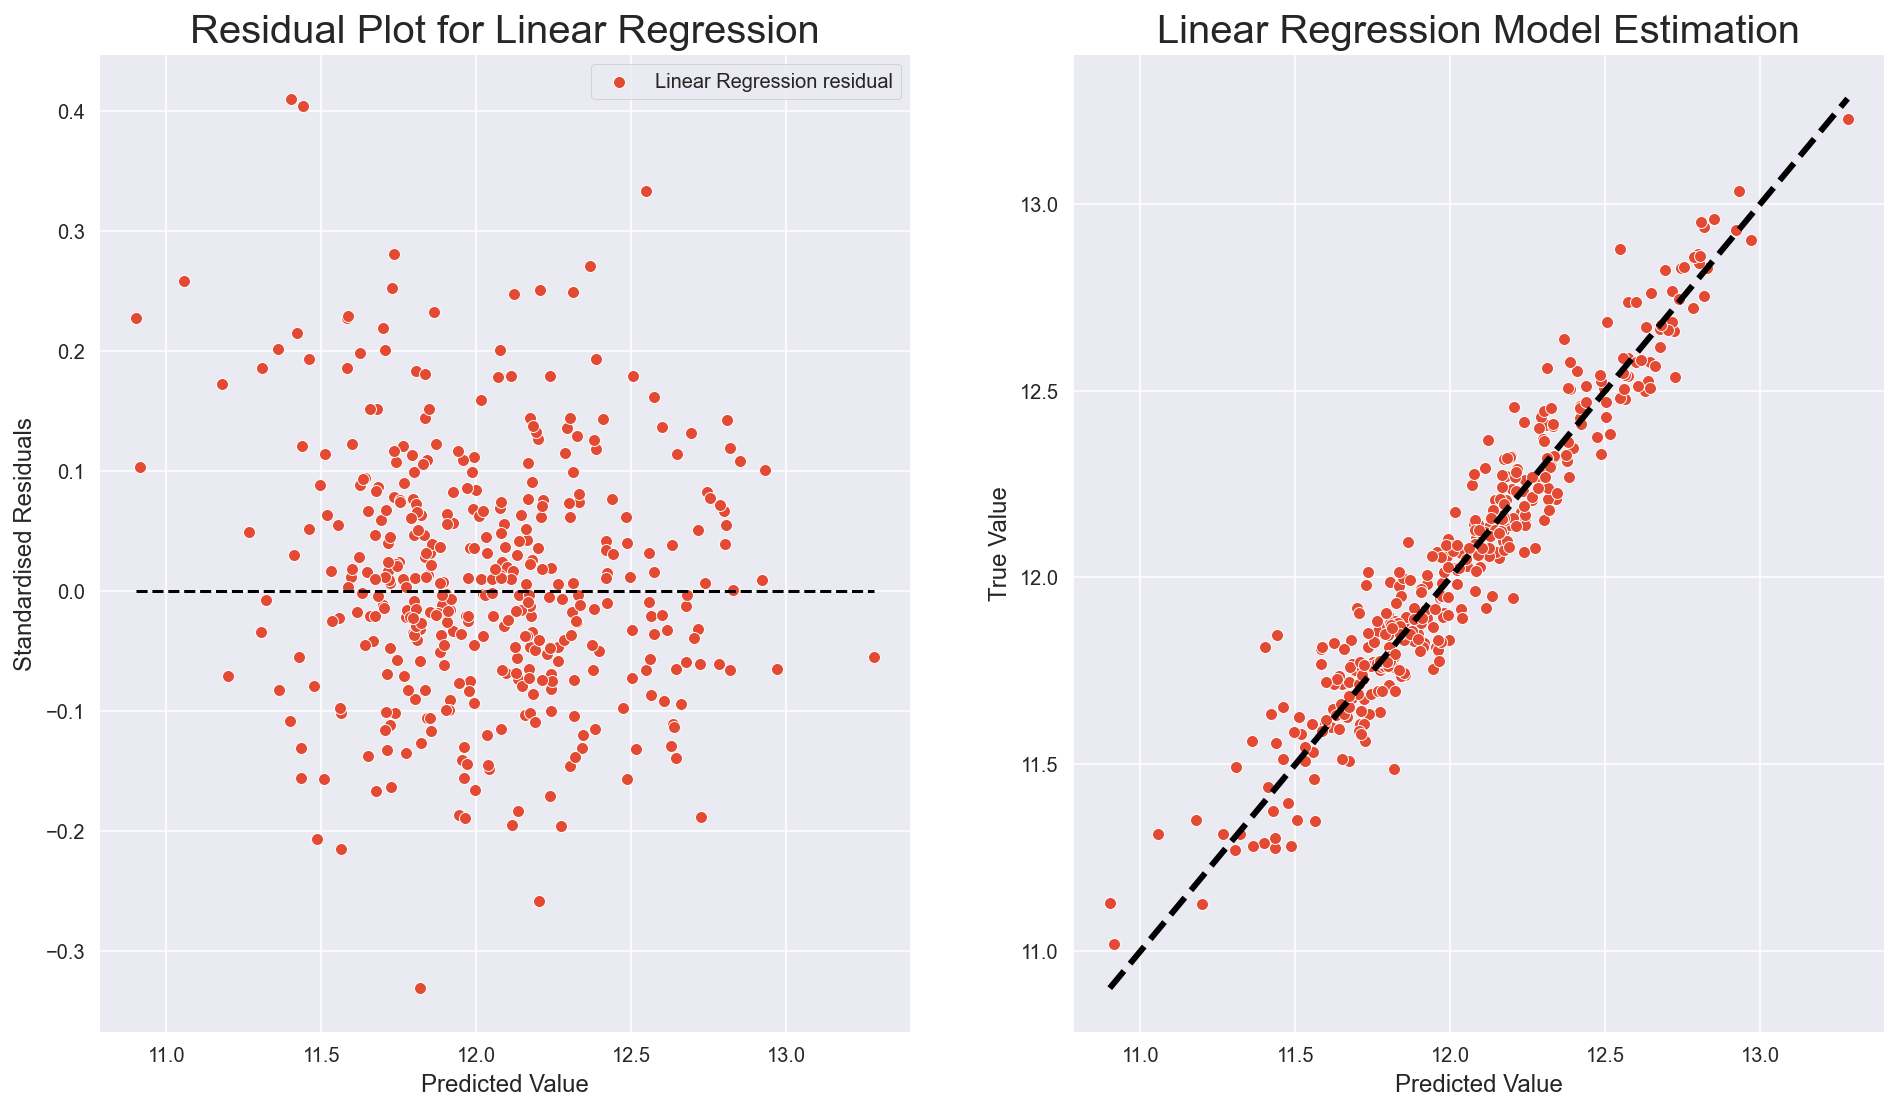

In [87]:
plt.figure(figsize = (16,9))


plt.subplot(1,2,1)
residual_plot(y_val , val_pred_lr , 'Linear Regression')

plt.subplot(1,2,2)
regplot(y_val , val_pred_lr , 'Linear Regression')

In [88]:
rmse , rmse_error_percent , mean = error_percent(lr_score)

In [89]:
print(f'Model is slightly overfitted. The residual of the predicted price is more extreme on the higher and lower end.')
print(f'Model has a RMSE Validation error of {rmse}, which translate to a {rmse_error_percent}% error with reference to the predicted value.')
print(f'The translate to about an RMSE error of ${rmse*mean} from our validation datatset, with reference to the predicted value')

Model is slightly overfitted. The residual of the predicted price is more extreme on the higher and lower end.
Model has a RMSE Validation error of 0.1035, which translate to a 10.9% error with reference to the predicted value.
The translate to about an RMSE error of $18810.401535 from our validation datatset, with reference to the predicted value


### 3.3 Lasso Regression
___

In [90]:
%%time
# Fitting into LassoCV to find best alpha
lasso_cv = LassoCV(n_alphas = 1000,
                   cv = 10,
                   max_iter = 10000,
                   verbose = False,
                   n_jobs = -1,
                   random_state = 42)

lasso_cv.fit(X_train , y_train)
lasso_cv.alpha_

Wall time: 1.25 s


0.6775674514674449

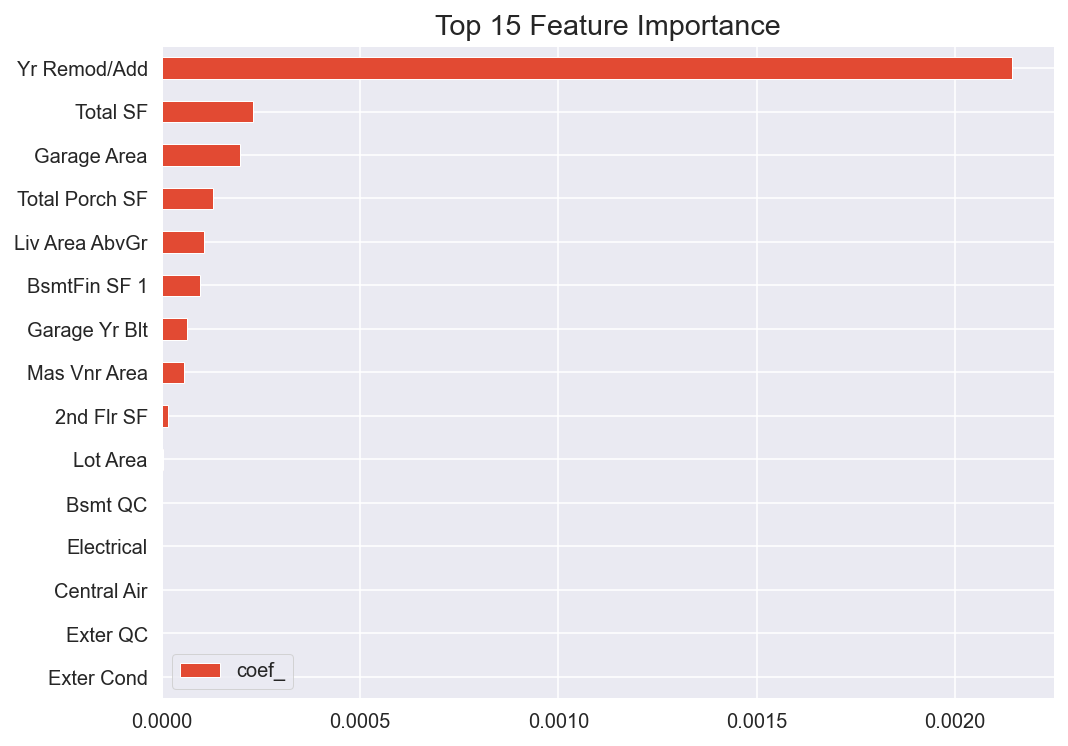

In [91]:
# FItting into Lasso Model with best alpha_

lasso = Lasso(alpha = lasso_cv.alpha_ , random_state = 42)
lasso.fit(X_train , y_train)
val_pred_lasso = lasso.predict(X_val)

coef_plot(lasso)

In [92]:
# Lasso Model Performance
lasso_score = eval_pred(lasso , X_train , X_val)
lasso_score

Score
Training MAE            0.109778
Validation MAE          0.106090
Training RMSE           0.152725
Validation RMSE         0.147447
Training Model Score    0.853255
Validation Model Score  0.846741

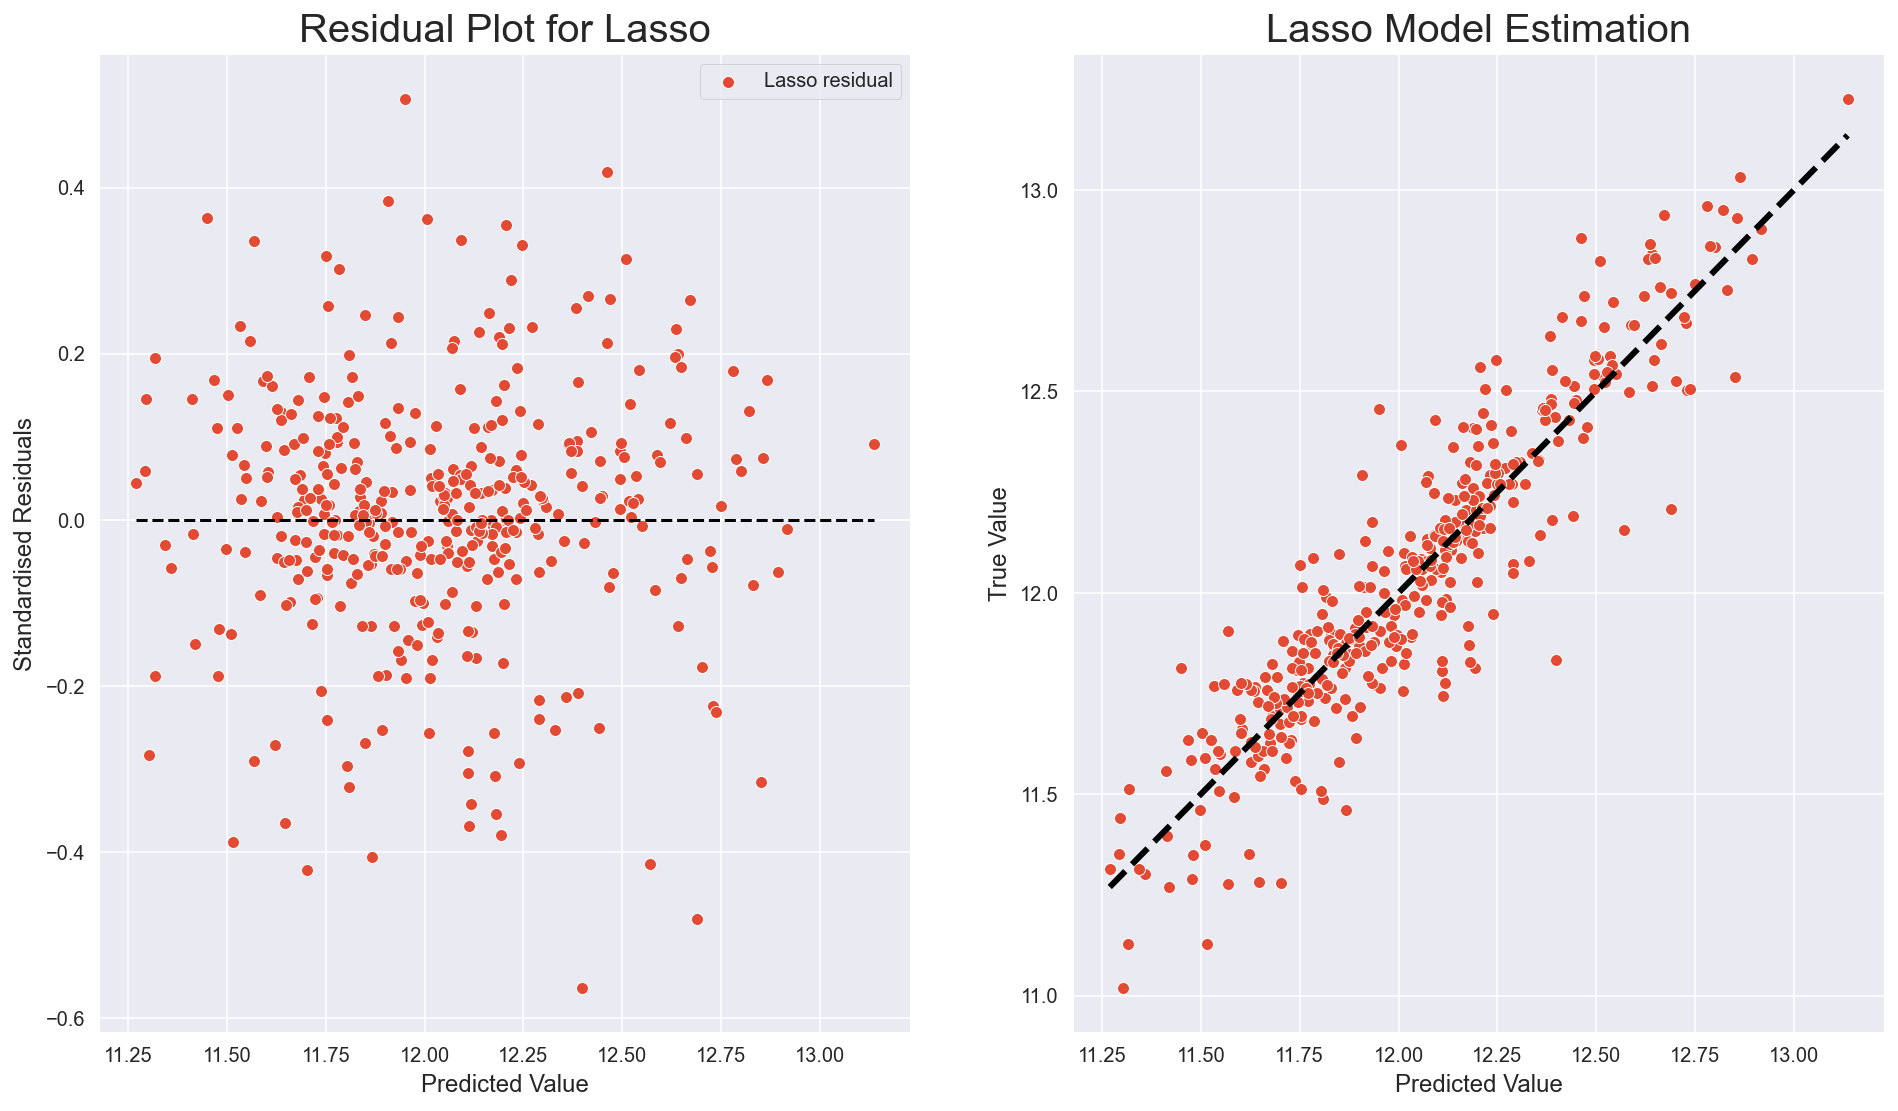

In [93]:
plt.figure(figsize = (16,9))


plt.subplot(1,2,1)
residual_plot(y_val , val_pred_lasso , 'Lasso')

plt.subplot(1,2,2)
regplot(y_val , val_pred_lasso , 'Lasso')

In [94]:
rmse , rmse_error_percent , mean = error_percent(lasso_score)

print(f'This Model is overfitted ,and at the same time does not seem to be training very well as well')
print(f'The lasso model has a relatively higher rmse value compared to the baseline Linear Regression and performed more worse at lower Sale Price')
print(f'The lasso model has a RMSE Validation error of {rmse}, which translate to a {rmse_error_percent}% error with reference to the predicted value.')
print(f'This translate to about an RMSE error of ${rmse*mean} from our validation datatset, with reference to the predicted value')

This Model is overfitted ,and at the same time does not seem to be training very well as well
The lasso model has a relatively higher rmse value compared to the baseline Linear Regression and performed more worse at lower Sale Price
The lasso model has a RMSE Validation error of 0.1474, which translate to a 15.89% error with reference to the predicted value.
This translate to about an RMSE error of $26788.919674 from our validation datatset, with reference to the predicted value


### 3.4 Ridge Regression
___

In [95]:
# Fitting into RidgeCV to find best alpha
ridge_cv = RidgeCV(alphas = np.logspace(0.1 , 5, 500),
                   cv = 10)

ridge_cv.fit(X_train , y_train)
ridge_cv.alpha_

94.52596119244778

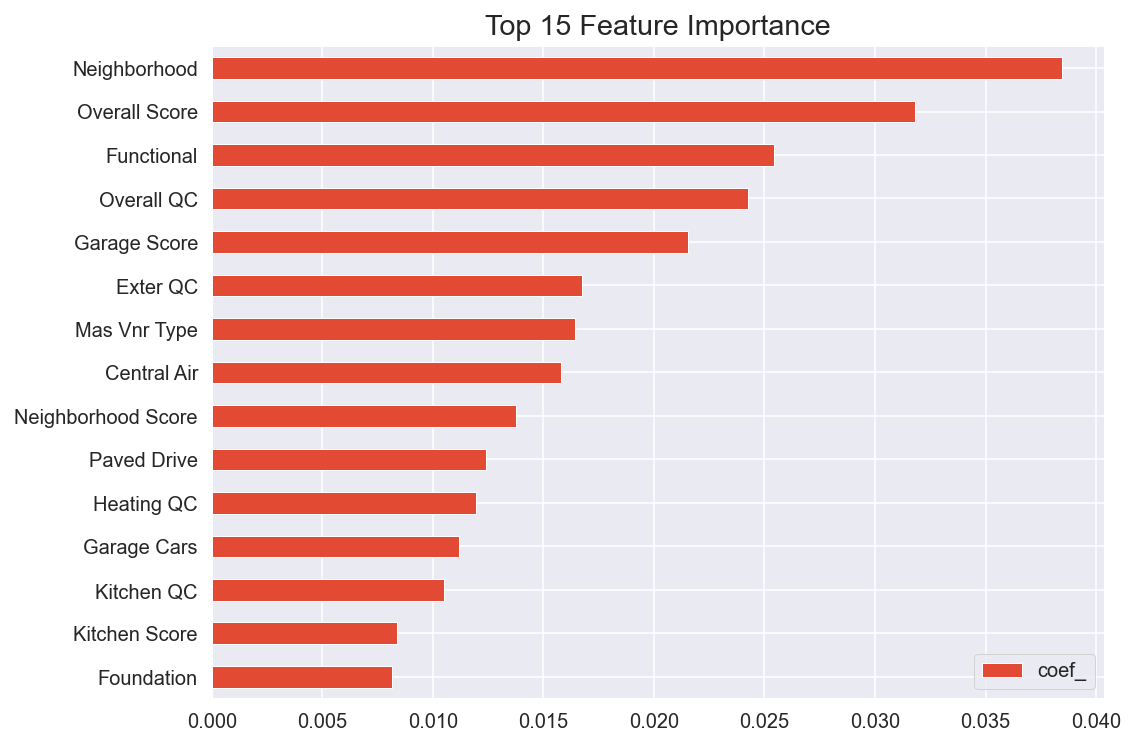

In [96]:
# FItting into Ridge Model with best alpha_

ridge = Ridge(alpha = ridge_cv.alpha_ , random_state = 42)
ridge.fit(X_train , y_train)
val_pred_ridge = ridge.predict(X_val) 

coef_plot(ridge)

In [97]:
# Lasso Model Performance
ridge_score = eval_pred(ridge , X_train , X_val)
ridge_score

Score
Training MAE            0.076030
Validation MAE          0.077622
Training RMSE           0.104681
Validation RMSE         0.102304
Training Model Score    0.931058
Validation Model Score  0.926221

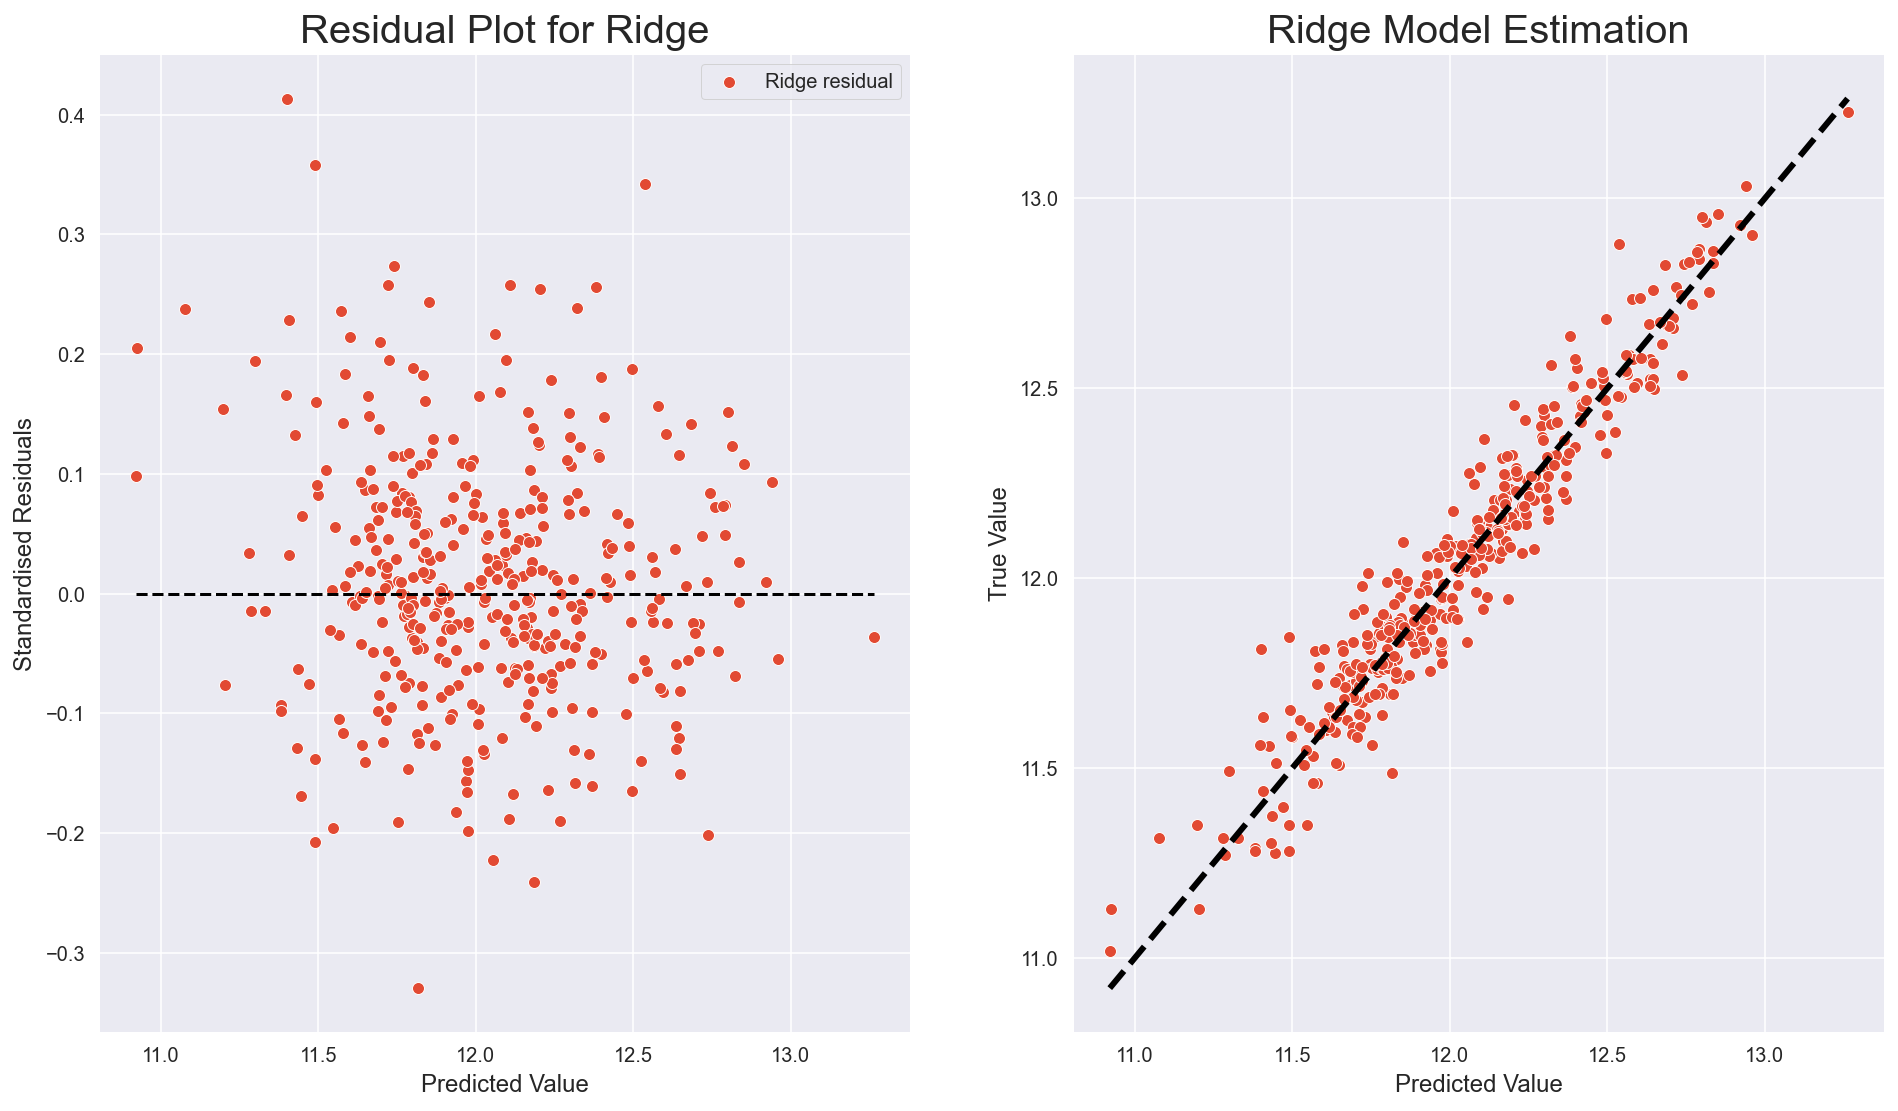

In [98]:
plt.figure(figsize = (16,9))


plt.subplot(1,2,1)
residual_plot(y_val , val_pred_ridge , 'Ridge')

plt.subplot(1,2,2)
regplot(y_val , val_pred_ridge , 'Ridge')

In [99]:
rmse , rmse_error_percent , mean = error_percent(ridge_score)

print(f'This Model is slithgly overfitted ,and at the same time does not seem to be training very well as well')
print(f'The ridge model performed slightly better compared to the baseline Linear Regression.')
print(f'The ridge model has a RMSE Validation error of {rmse}, which translate to a {rmse_error_percent}% error with reference to the predicted value.')
print(f'This translate to about an RMSE error of ${rmse*mean} from our validation datatset, with reference to the predicted value')

This Model is slithgly overfitted ,and at the same time does not seem to be training very well as well
The ridge model performed slightly better compared to the baseline Linear Regression.
The ridge model has a RMSE Validation error of 0.1023, which translate to a 10.77% error with reference to the predicted value.
This translate to about an RMSE error of $18592.309923 from our validation datatset, with reference to the predicted value


### 3.5 ElasticNet CV
___

In [100]:
# Fitting into ENetCV to find best alpha

l1_ratio = np.linspace(0.01 , 1 , 100)
enet_cv = ElasticNetCV(l1_ratio = l1_ratio,
                       n_alphas = 1000,
                       cv = 10 ,
                       n_jobs = -1,
                       max_iter = 50000)

enet_cv.fit(X_train , y_train)
print('enet Alpha :' , enet_cv.alpha_)
print('enet l1_ratio :' , enet_cv.l1_ratio_)

enet Alpha : 0.6775674514674449
enet l1_ratio : 1.0


In [101]:
# ENet Model Performance

enet = ElasticNet(alpha = enet_cv.alpha_,
                  l1_ratio = enet_cv.l1_ratio_)
enet.fit(X_train , y_train)
val_pred_enet = enet.predict(X_val) 


enet_score = eval_pred(enet , X_train , X_val)
enet_score

Score
Training MAE            0.109778
Validation MAE          0.106090
Training RMSE           0.152725
Validation RMSE         0.147447
Training Model Score    0.853255
Validation Model Score  0.846741

### 3.6 Random Forest Regressor
___

In [102]:
%%time

np.random.seed(42)
# Fitting into GridSearchCV to find best params
rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
                 'min_samples_leaf' : np.arange(1, 5 , 1),
                 'n_estimators' : np.arange(40 , 80 , 10),
                 'max_features' : ['log2' , 'sqrt' , 'auto'],
                 'max_depth' : [None , 3 , 5]}

#Create Random Forest model
rf = RandomForestRegressor(n_jobs = -1,
                          random_state = 42)

#Instantiating GridSearchCV model
rf_cv = GridSearchCV(estimator = rf,
                     param_grid = rf_param_grid,
                     cv = 10,
                     verbose = True)

rf_cv.fit(X_train , y_train)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 8min 48s


[Parallel(n_jobs=1)]: Done 5760 out of 5760 | elapsed:  8.8min finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [None, 3, 5],
                         'max_features': ['log2', 'sqrt', 'auto'],
                         'min_samples_leaf': array([1, 2, 3, 4]),
                         'min_samples_split': array([2, 4, 6, 8]),
                         'n_estimators': array([40, 50, 60, 70])},
             verbose=True)

In [103]:
# Finding Best params for RF
rf_cv.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 70}

In [152]:
# Fitting RF with best Params
rf = RandomForestRegressor(n_estimators = 70,
                           min_samples_split = 4,
                           min_samples_leaf = 1,
                           max_depth = None,
                           max_features = 'sqrt',
                           n_jobs = -1,
                           random_state = 42)

rf.fit(X_train , y_train)
val_pred_rf = rf.predict(X_val)

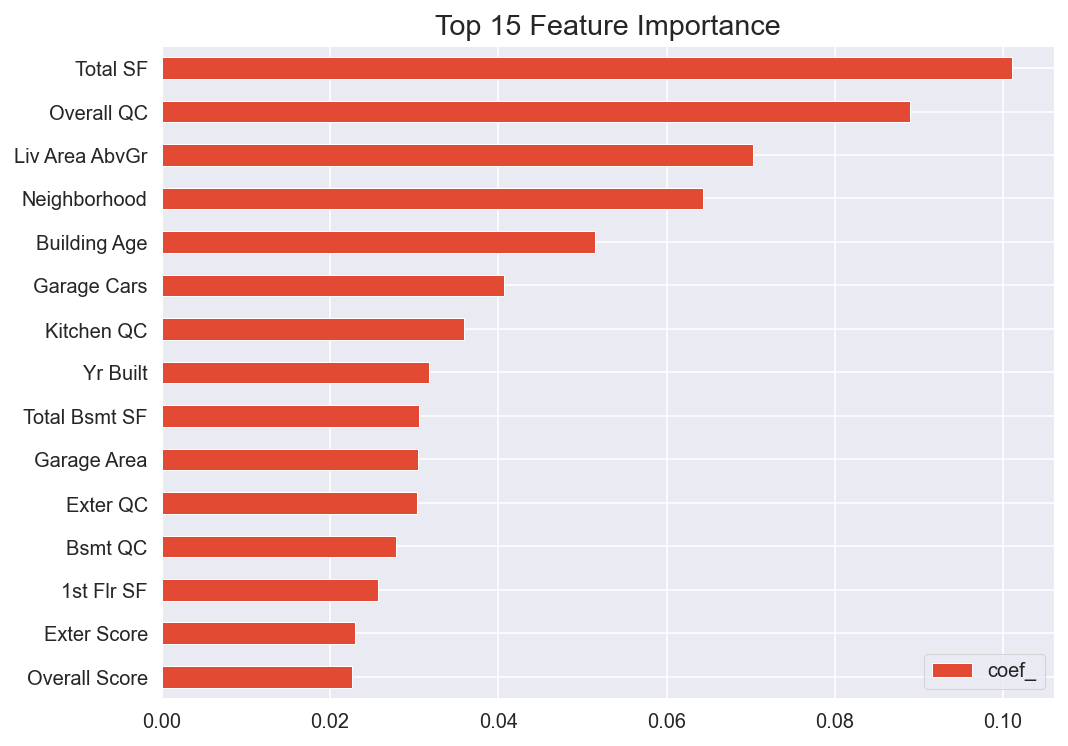

In [153]:
# Top features for Random Forest
coef_plot(rf)

In [154]:
rf_score = eval_pred(rf , X_train , X_val)
rf_score

Score
Training MAE            0.036248
Validation MAE          0.075616
Training RMSE           0.052925
Validation RMSE         0.104506
Training Model Score    0.982378
Validation Model Score  0.923011

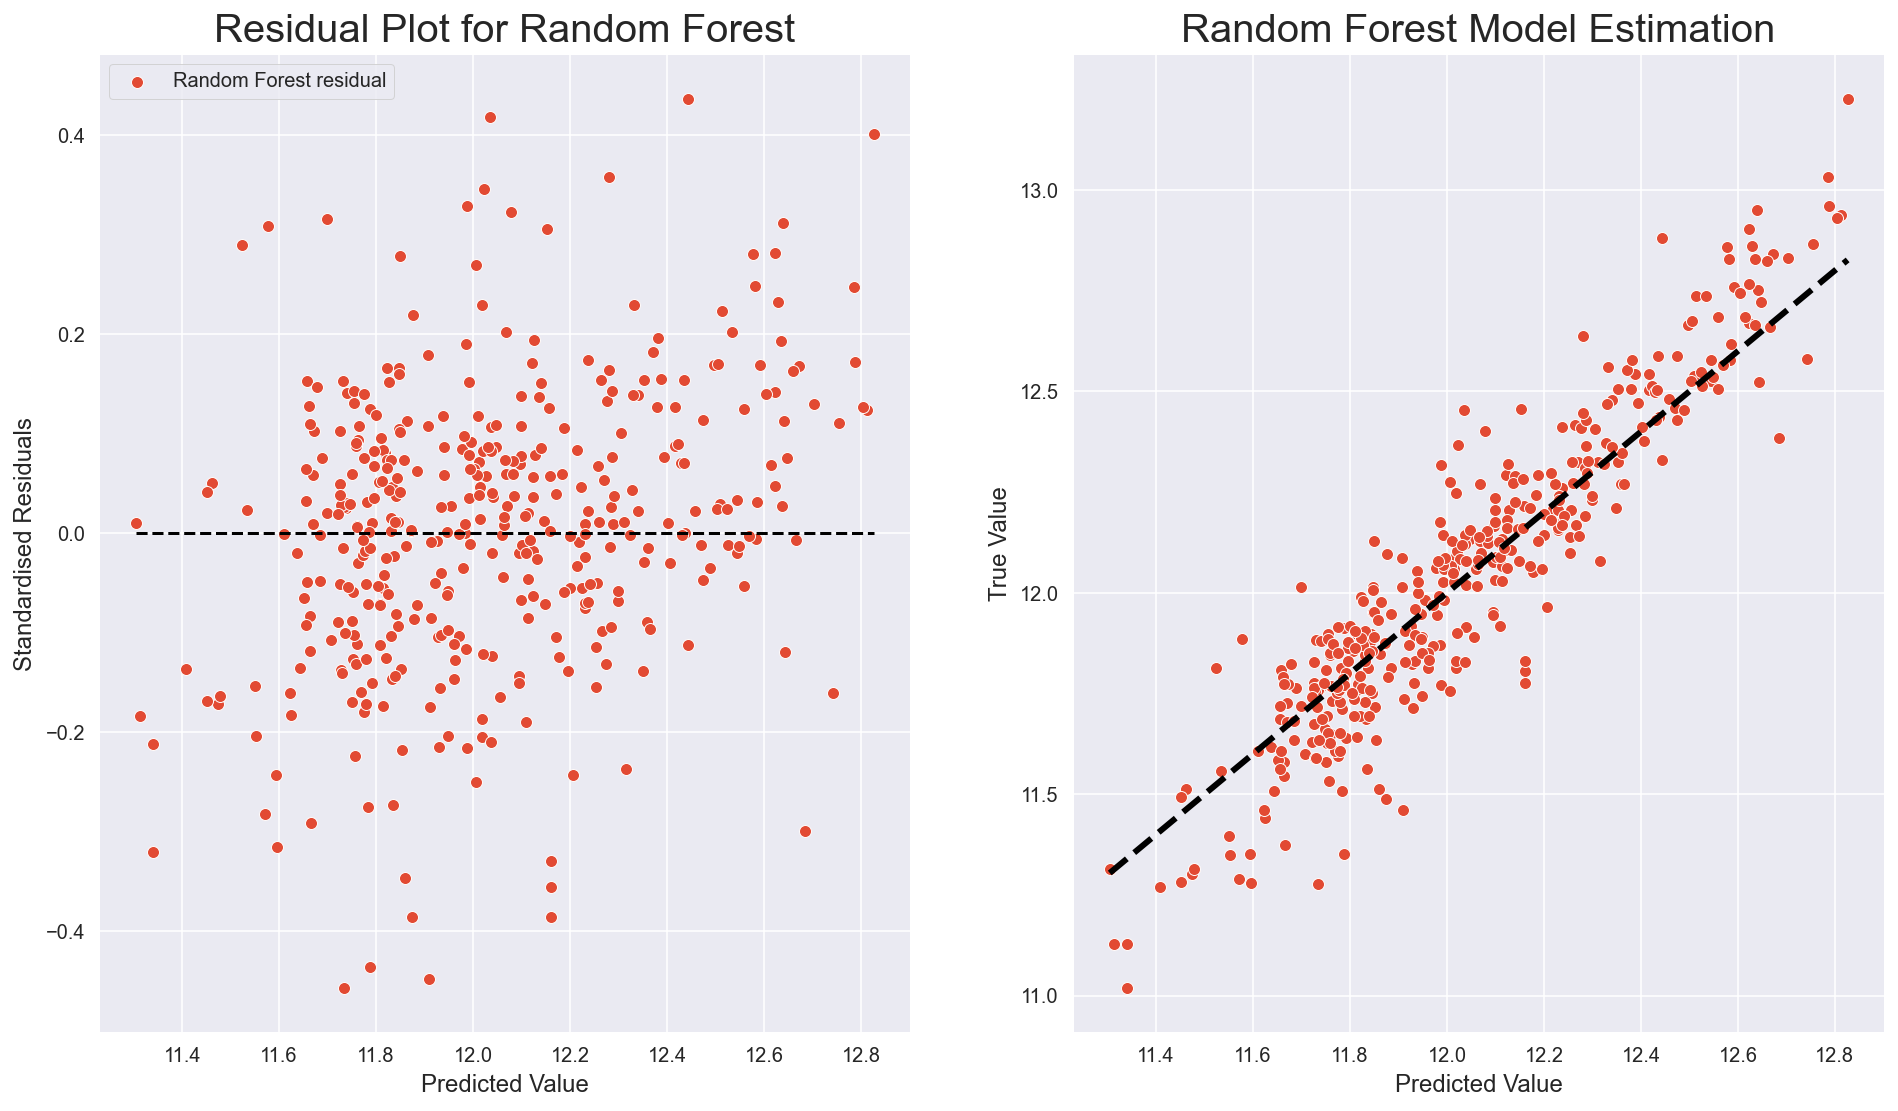

In [107]:
plt.figure(figsize = (16,9))


plt.subplot(1,2,1)
residual_plot(y_val , val_pred_rf , 'Random Forest')

plt.subplot(1,2,2)
regplot(y_val , val_pred_rf , 'Random Forest')

In [155]:
rmse , rmse_error_percent , mean = error_percent(rf_score)

print(f'Although this model score has a comparable RMSE error compared to LR & Ridge, the model is severly overfit')
print(f'The ridge model has a RMSE Validation error of {rmse}, which translate to a {rmse_error_percent}% error with reference to the predicted value.')
print(f'This translate to about an RMSE error of ${rmse*mean} from our validation datatset, with reference to the predicted value')

Although this model score has a comparable RMSE error compared to LR & Ridge, the model is severly overfit
The ridge model has a RMSE Validation error of 0.1045, which translate to a 11.02% error with reference to the predicted value.
This translate to about an RMSE error of $18992.144545 from our validation datatset, with reference to the predicted value


### 3.7 Model Summary
___

Base on our various model, it is observed that features such as neighbourhood , overall score , garage score exhibit better relationship withr espect to the Sale Price

In [156]:
dict_score = {'LR Score' : lr_score,
            'Lasso Score' : lasso_score,
            'Ridge Score' : ridge_score,
            'Elastic Net' : enet_score, 
            'RandomForest Score' : rf_score}

df_score = pd.DataFrame()

for name , score in dict_score.items():
    df_score[name] = score.values.ravel()
    df_score.index = score.index.ravel()

In [157]:
df_score

LR Score  Lasso Score  Ridge Score  Elastic Net  \
Training MAE            0.076062     0.109778     0.076030     0.109778   
Validation MAE          0.078828     0.106090     0.077622     0.106090   
Training RMSE           0.104159     0.152725     0.104681     0.152725   
Validation RMSE         0.103474     0.147447     0.102304     0.147447   
Training Model Score    0.931745     0.853255     0.931058     0.853255   
Validation Model Score  0.924523     0.846741     0.926221     0.846741   

                        RandomForest Score  
Training MAE                      0.036248  
Validation MAE                    0.075616  
Training RMSE                     0.052925  
Validation RMSE                   0.104506  
Training Model Score              0.982378  
Validation Model Score            0.923011

# 4.0 Ridge Model with top 10 features
___

1. Using one of the better model , we extract out the top 10 features sort by coef_
2. We will pass it through a Polynomial Feature 2 before standardising it.
3. This will create around a total of 65 features.

In [158]:
# Extracting Top 10 coef_ from Ridge Model

df_ridge = pd.DataFrame(index= X_train.columns,
                      data = {'coef_' :abs(ridge.coef_)})
df_ridge = df_ridge.sort_values(by = 'coef_' , ascending = False).head(10)
X_top10 = df_ridge.sort_values(by = 'coef_', ascending = False).index[:10].to_list()
print(X_top10)

['Neighborhood', 'Overall Score', 'Functional', 'Overall QC', 'Garage Score', 'Exter QC', 'Mas Vnr Type', 'Central Air', 'Neighborhood Score', 'Kitchen AbvGr']


In [159]:
np.random.seed(42)

# Splitting X variable as top 10 features
X = df_train[X_top10]
y = df_train['Log SalePrice']
X_train_top10 , X_val_top10 , y_train_top10 , y_val_top10 = train_test_split(X , y , test_size = 0.2)


# Polynomial the top 10 features
poly = PolynomialFeatures(degree = 2, include_bias = False , interaction_only = False , order = 'C')
X_train_top10 = poly.fit_transform(X_train_top10)
X_val_top10 = poly.transform(X_val_top10)


#Standardising Our data
ss = StandardScaler()
ss.fit_transform(X_train_top10)
ss.transform(X_val_top10)

print(f'X_train Shape : {X_train_top10.shape}')
print(f'X_val Shape : {X_val_top10.shape}')
print(f'y_train Shape : {y_train_top10.shape}')
print(f'y_val Shape : {y_val_top10.shape}')

X_train Shape : (1623, 65)
X_val Shape : (406, 65)
y_train Shape : (1623,)
y_val Shape : (406,)


In [160]:
%%time

# Fitting into RIdgeCV to find best alpha
ridge_cv_top10 = RidgeCV(alphas = np.logspace(0.01 , 5, 500),
                         cv = 10)

ridge_cv_top10.fit(X_train_top10 , y_train_top10)
ridge_cv_top10.alpha_

Wall time: 8 s


380.1893963205609

In [161]:
# Fitting into Ridge model

ridge_top10 = Ridge(alpha = ridge_cv_top10.alpha_)
ridge_top10.fit(X_train_top10 , y_train_top10)
val_pred_ridge_top10 = ridge_top10.predict(X_val_top10) 

In [162]:
eval_pred(ridge_top10 , X_train_top10 , X_val_top10)

Score
Training MAE            0.141549
Validation MAE          0.141718
Training RMSE           0.185215
Validation RMSE         0.183296
Training Model Score    0.784177
Validation Model Score  0.763158

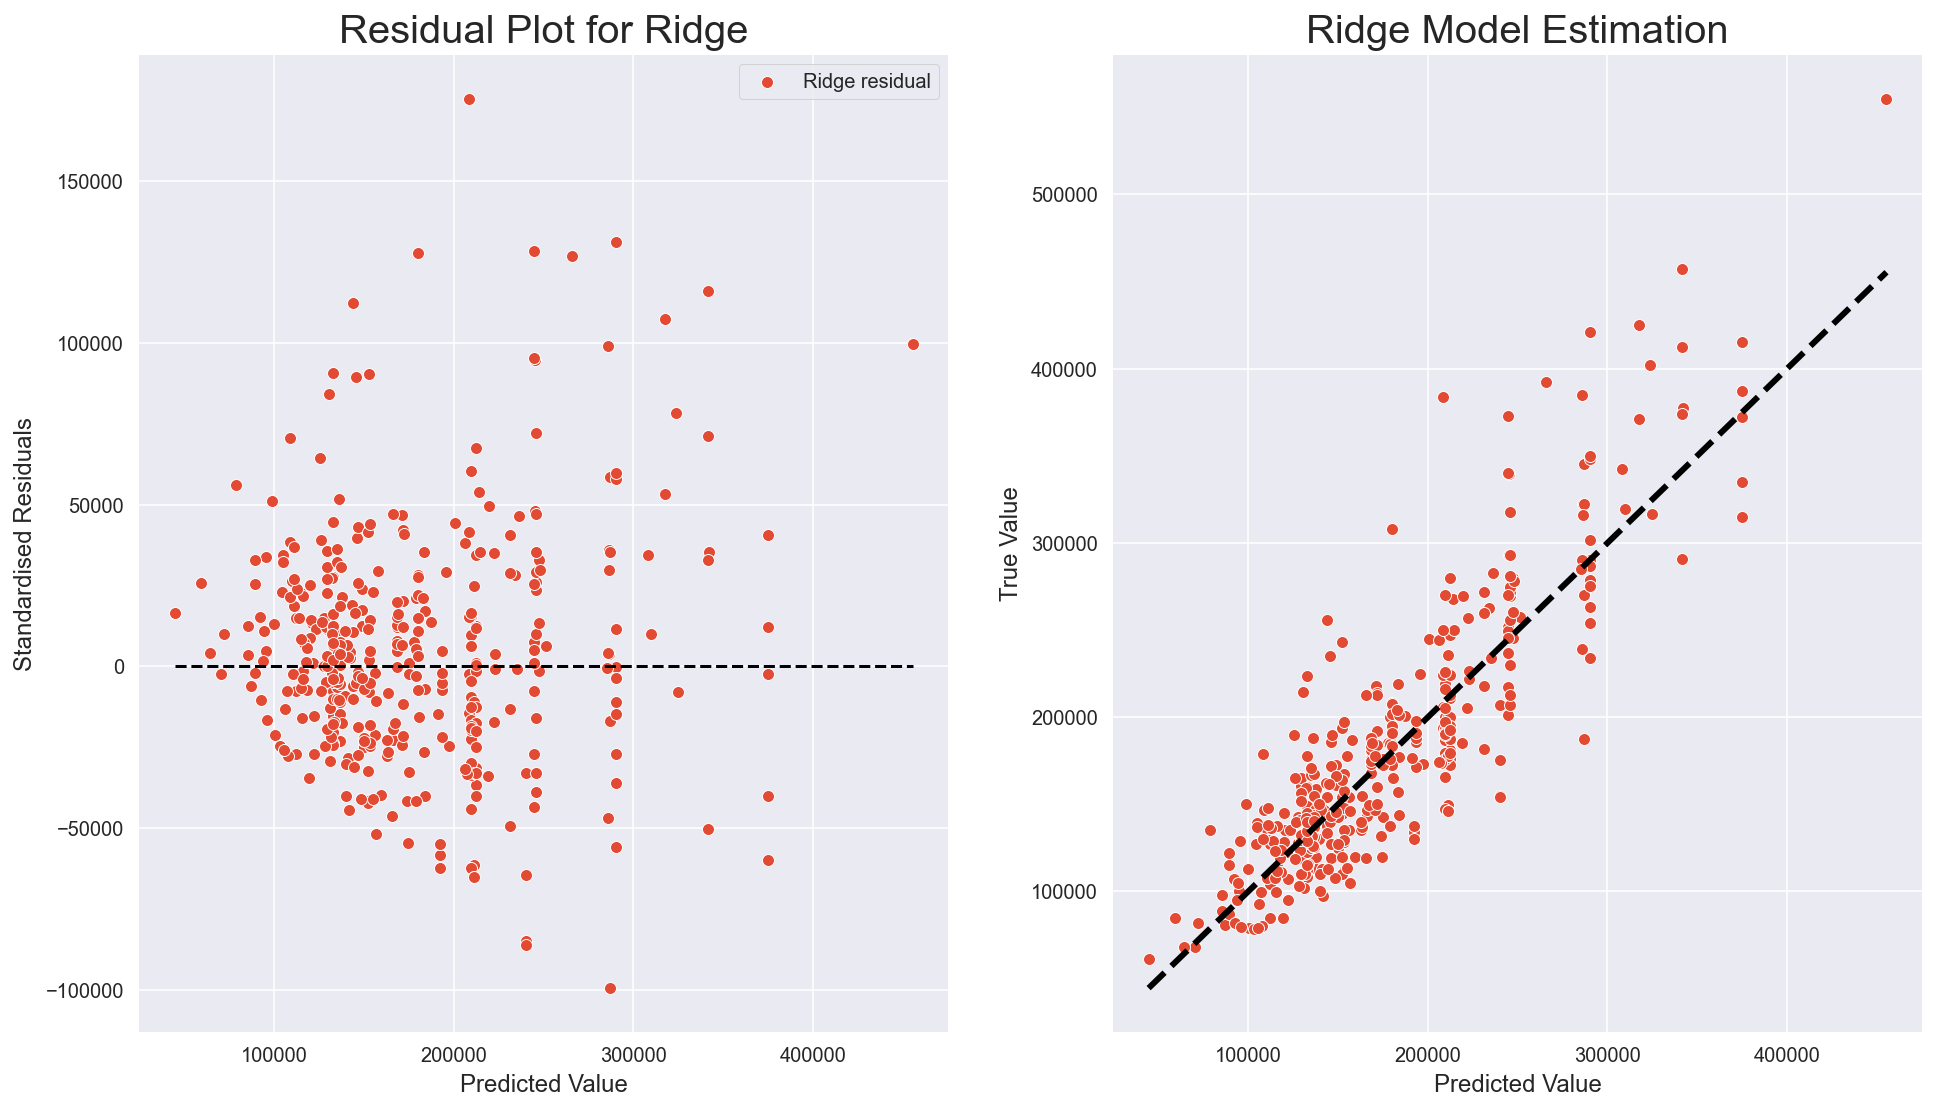

In [163]:
plt.figure(figsize = (16,9))


plt.subplot(1,2,1)
residual_plot(np.exp(y_val_top10) , np.exp(val_pred_ridge_top10), 'Ridge')

plt.subplot(1,2,2)
regplot(np.exp(y_val_top10) , np.exp(val_pred_ridge_top10) , 'Ridge')

In [117]:
print('With most of the features remove , the model overall performance had decrease significantly in term of training and predicting.')
print('The RMSE error had also significantly increased by 8% compared to the Baseline Linear Regression Model')
print('We, for the model for Kaggle Submission as well as for using to predict our "client" house feature , w')

With most of the features remove , the model overall performance had decrease significantly in term of training and predicting.
The RMSE error had also significantly increased by 8% compared to the Baseline Linear Regression Model
We, for the model for Kaggle Submission as well as for using to predict our "client" house feature , w


# 5.0 Preparing test prediction for kaggle submission
___
1. We need to load in test_csv
2. We need to apply the same preprocessing step to out train_csv to our test_csv
3. We will assign X_test to test_csv
4. Using the model.predict(X_test) , we will get the prediction array base on the X_test

### 5.1 Importing Test_csv
___

In [164]:
df_test = pd.read_csv('datasets/test.csv')

In [165]:
def preprocess_data(df):
    
    ### Section 1.4 : Feature Creation   
    for i in range(len(df)):
        if df['Year Remod/Add'][i] > df['Year Built'][i]:
            df['Building Age'] = df['Yr Sold'] -  df['Year Remod/Add']
        else:
            df['Building Age'] = df['Yr Sold'] -  df['Year Built']    
    
    df['Season'] = df['Mo Sold'].map(season_map)
    
    porch_list  = [porch for porch in df if 'Porch'in porch or 'Deck' in porch]
    df['Total Porch SF'] = df[porch_list].sum(axis = 1)
    porch_list  = [porch for porch in df if 'Porch'in porch or 'Deck' in porch]
    
    ### Section 1.5 : Renaming Columns
    standardise_col_name(df)
    
    ### Section 1.6 : Preprocessing NaN
    minority_feature_dummify(df , 'Pool QC')
    minority_feature_dummify(df , 'Misc Feature')
    minority_feature_dummify(df , 'Alley')
    minority_feature_dummify(df , 'Fence')
    df['Fireplace QC'].fillna(value = 'NA',
                         inplace = True)
    
    map_cond = df.groupby('Bldg Type').median()['Lot Frontage'].to_dict()
    df_lot_nan = df['Lot Frontage'].isnull()
    df.loc[df_lot_nan , 'Lot Frontage'] = df.loc[df_lot_nan , 'Bldg Type'].map(map_cond)
    
    garage_list_nan = [garage for garage in df.columns if 'Garage' in garage]
    df[df['Garage Yr Blt'].isna()][garage_list_nan].sort_values(by = 'Garage Type').head()
    for col_name , data in df[garage_list_nan].items():
        if not pd.api.types.is_numeric_dtype(data):
            df[col_name].fillna(value = 'NA', inplace = True)
        else:
            df[col_name].fillna(value = 0 , inplace = True)
            
    basement_list = [bsmt for bsmt in df.columns if 'Bsmt' in bsmt]
    for col_name , data in df[basement_list].items():
        if pd.api.types.is_numeric_dtype(data):
            df[col_name].fillna(value = 0 , inplace = True)
        else:
            df[col_name].fillna(value = 'NA' , inplace = True)
    
    df['Mas Vnr Type'].fillna(value = 'None' , inplace = True)
    df['Mas Vnr Area'].fillna(value = 0 , inplace = True)

    
    ### Section 2.0 : Feature Engineering
    ### Section 2.1 : Replacing ordinal feature with pre-defined dictionary
    ordinal_dummy(df)
            
    ### Section 2.2 : Dummy Cat. Feature        
    category_dummy(df)
     
    ### Section 2.3 : Adding New Features
    feature_addition(df)
            
    return(df)

### 5.2 Preprocess test data (Same Process as train data)

In [166]:
df_test_processed = preprocess_data(df_test)
df_test_processed.isnull().sum().sum()

Before Dummify:
Ex    3
TA    1
Name: Pool QC, dtype: int64
                       
After Dummify:
-1    874
 1      4
Name: Pool QC, dtype: int64
Before Dummify:
Shed    39
Gar2     1
Othr     1
Name: Misc Feature, dtype: int64
                       
After Dummify:
-1    837
 1     41
Name: Misc Feature, dtype: int64
Before Dummify:
Grvl    35
Pave    23
Name: Alley, dtype: int64
                       
After Dummify:
-1    820
 1     58
Name: Alley, dtype: int64
Before Dummify:
MnPrv    103
GdPrv     35
GdWo      32
MnWw       2
Name: Fence, dtype: int64
                       
After Dummify:
-1    706
 1    172
Name: Fence, dtype: int64


0

### 5.3 Fitting Test_data into our `ridge model`
___

In [167]:
# Setting Random Seed
np.random.seed(42)

# Create X_test variables
X_test = df_test_processed.drop(['PID' , 'Alley' , 'Street'], axis = 1)

#Standardising Our data
ss = StandardScaler()
ss.fit_transform(X_test)

### Check test shape after pre-processed same 
print(f'X_train Shape : {X_train.shape}')
print(f'X_test Shape : {X_test.shape}')

X_train Shape : (1623, 89)
X_test Shape : (878, 89)


In [170]:
# Finding Best Alpha
ridge_cv = RidgeCV(alphas = np.logspace(0 , 5, 500),
                   cv = 10)

ridge_cv.fit(X_train , y_train)
ridge_cv.alpha_

# Fitting into model
ridge = Ridge(alpha = ridge_cv.alpha_)
ridge.fit(X_train , y_train)

# Creating df with only salesprice and ID
df_test_processed['SalePrice'] = np.exp(ridge.predict(X_test)) 
df_submission = df_test_processed[['Id' , 'SalePrice']]

### 5.4 Convert to submission file
___
Base on our submission file , we have a RMSE of `$25025` for our test data , compared to the validation RMSE of `$18000`

In [169]:
import os
os.getcwd()
export_path = r'D:\\Python Exercise\\GA-DSF - Projects\\Project 2\Ames_housing_submission.csv'
df_submission.to_csv(export_path , index = False)

# 6.0 Using optimised model to advise client on the qualitative impact on Sale Price from Feature improvement
___

1. We will use a baseline dataset on our client's house current feature
2. We will generate a baseline dataset base on our client current house feature.
3. We will varies the result for each feature at a time to see what is the qualitative impact on the Sale Price.
4. Base on our model from Section 3.4, it is best used to predict feature such as Overall Score , Garage Score , Kitchen Score. (See Section 3.4 for Ridge Regression)

### 6.1 Our Client (Alan Walker) House Profile
___

As per our problem statement , we aim to assist our young work class archetype , such as Alan Walker , to optimise their House selling price between 5% to 10% from their baseline Sale Price, by using our housing prediction models to provide advise to house seller on which features to optimise within their renovation spending budget.

In this scenerio , we will use our model to predict the variation of the 2 features : `House Score` and `Garage Score` with respect to the Sale Price.

`Our Client House Key Information`
* Neighbouhood : NridgHT
* House Style : 2 Story
* Living Area : 1,904 SF
* Functional : Typical
* Air Con : Yes
___
`Client House Feature to Study`
* **Current House Cond : 5**
* **Current House QC : 8**
* **Current Garage Cond : Typical Average**
* **Current Garage QC : Typical Average**

### 6.2 Advising Client on qualitative impact of improving house condition.
___

* Alan's `current house condition is scored 5 and quality is scored 8`.
* Base on our model , if he were to renovate and improve his house condition from 5 to 6 , we predict he should be able to increase his Sale Price from `$270,000` to `$281,000`
*  Base on our model , if he were to renovate and improve his house condition from 5 to 7 , we predict he should be able to increase his Sale Price from `$270,000` to `$292,000`
* Lets Plot a graph to see the effect for both quality and condition.

In [124]:
# Load in data and preprocess the same way as in Section 5.0 for our Kaggle Submission
df_test = pd.read_csv('datasets/alan_walker_house_overall.csv')

df_test_processed = preprocess_data(df_test)
df_test_processed.isnull().sum().sum()

Before Dummify:
Series([], Name: Pool QC, dtype: int64)
                       
After Dummify:
-1.0    70
Name: Pool QC, dtype: int64
Before Dummify:
Series([], Name: Misc Feature, dtype: int64)
                       
After Dummify:
-1.0    70
Name: Misc Feature, dtype: int64
Before Dummify:
Series([], Name: Alley, dtype: int64)
                       
After Dummify:
-1.0    70
Name: Alley, dtype: int64
Before Dummify:
Series([], Name: Fence, dtype: int64)
                       
After Dummify:
-1.0    70
Name: Fence, dtype: int64


0

In [125]:
# Setting Random Seed
np.random.seed(42)

# Create X_test variables
X_test = df_test_processed.drop(['PID' , 'Alley' , 'Street'], axis = 1)

#Standardising Our data
ss = StandardScaler()
ss.fit_transform(X_test)

### Check test shape after pre-processed same  (Important!)
print(f'X_train Shape : {X_train.shape}')
print(f'X_test Shape : {X_test.shape}')

X_train Shape : (1623, 89)
X_test Shape : (70, 89)


In [126]:
# Finding Best Alpha
ridge_cv = RidgeCV(alphas = np.logspace(0 , 5, 500),
                   cv = 10)

ridge_cv.fit(X_train , y_train)
ridge_cv.alpha_

# Fitting into model
ridge = Ridge(alpha = ridge_cv.alpha_)
ridge.fit(X_train , y_train)
df_test_processed['SalePrice'] = np.exp(ridge.predict(X_test)) 

df_submission = df_test_processed[['Id' , 'Overall QC' , 'Overall Cond' ,  'SalePrice']]

In [127]:
# Our client baseline house condition is ID 2402.
# Subsequent are variation of feature score , while all else kept constant
df_submission.head(10)

Id  Overall QC  Overall Cond      SalePrice
0  2402           8             5  270482.931953
1  2403           8             4  260043.078633
2  2404           8             3  250006.173243
3  2405           8             2  240356.663166
4  2406           8             1  231079.596071
5  2407           8             6  281351.355426
6  2408           8             7  292649.939134
7  2409           8             8  304402.254417
8  2410           8             9  316626.522351
9  2411           8            10  329341.695737

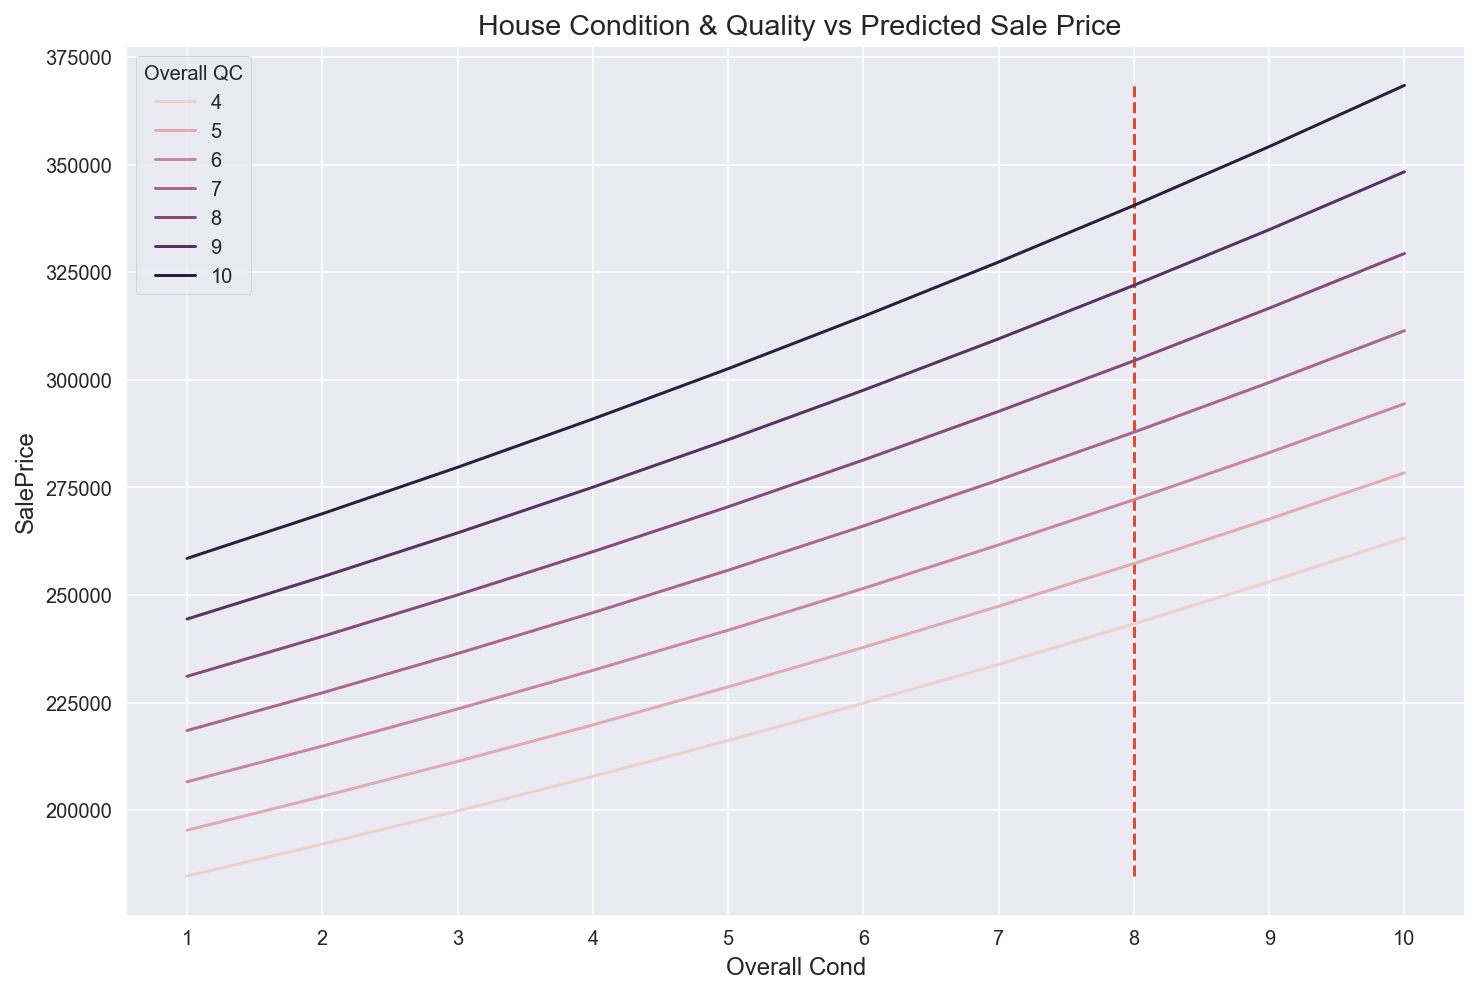

In [128]:
plt.figure(figsize = (12,8))
sns.lineplot(x = 'Overall Cond',
             y = 'SalePrice',
             hue = 'Overall QC',
             data = df_submission)

plt.vlines(x = 8,
           ymin = min(df_test_processed['SalePrice']),
           ymax = max(df_test_processed['SalePrice']),
           linestyles='--')

plt.xticks(range(1,11,1))

plt.title(' House Condition & Quality vs Predicted Sale Price');

### 6.2 Advising Client on qualitative impact of improving Garage condition.
___

* Alan's `current Garage condition is scored Average and quality is scored Average`.
* Base on our model , if he were to renovate and improve his Garage condition from Average to Good , we predict he should be able to increase his Sale Price from `$270,000` to `$277,000`
*  Base on our model , if he were to renovate and improve his house condition from Average to Excellent , we predict he should be able to increase his Sale Price from `$270,000` to `$285,000`
* Lets Plot a graph to see the effect for both quality and condition.

In [129]:
# Load in data and preprocess the same way as in Section 5.0 for our Kaggle Submission
df_test = pd.read_csv('datasets/alan_walker_garage_overall.csv')

df_test_processed = preprocess_data(df_test)
df_test_processed.isnull().sum().sum()

Before Dummify:
Series([], Name: Pool QC, dtype: int64)
                       
After Dummify:
-1.0    25
Name: Pool QC, dtype: int64
Before Dummify:
Series([], Name: Misc Feature, dtype: int64)
                       
After Dummify:
-1.0    25
Name: Misc Feature, dtype: int64
Before Dummify:
Series([], Name: Alley, dtype: int64)
                       
After Dummify:
-1.0    25
Name: Alley, dtype: int64
Before Dummify:
Series([], Name: Fence, dtype: int64)
                       
After Dummify:
-1.0    25
Name: Fence, dtype: int64


0

In [130]:
# Setting Random Seed
np.random.seed(42)

# Create X_test variables
X_test = df_test_processed.drop(['PID' , 'Alley' , 'Street'], axis = 1)

#Standardising Our data
ss = StandardScaler()
ss.fit_transform(X_test)

### Check test shape after pre-processed same  (Important!)
print(f'X_train Shape : {X_train.shape}')
print(f'X_test Shape : {X_test.shape}')

X_train Shape : (1623, 89)
X_test Shape : (25, 89)


In [131]:
# Finding Best Alpha
ridge_cv = RidgeCV(alphas = np.logspace(0 , 5, 500),
                   cv = 10)

ridge_cv.fit(X_train , y_train)
ridge_cv.alpha_

# Fitting into model
ridge = Ridge(alpha = ridge_cv.alpha_)
ridge.fit(X_train , y_train)
df_test_processed['SalePrice'] = np.exp(ridge.predict(X_test)) 

df_submission = df_test_processed[['Id' , 'Garage QC' , 'Garage Cond' ,  'SalePrice']]

In [132]:
# Our client baseline house condition is ID 2402.
# Subsequent are variation of feature score , while all else kept constant
df_submission.head(10)

Id  Garage QC  Garage Cond      SalePrice
0  2402          3            3  270482.931953
1  2403          3            2  263398.524325
2  2404          3            4  277762.545319
3  2405          3            5  285236.481806
4  2406          3            1  256502.539746
5  2407          2            3  263608.322957
6  2408          2            2  256703.973021
7  2409          2            4  270702.917272
8  2410          2            5  277986.895780
9  2411          2            1  249983.257163

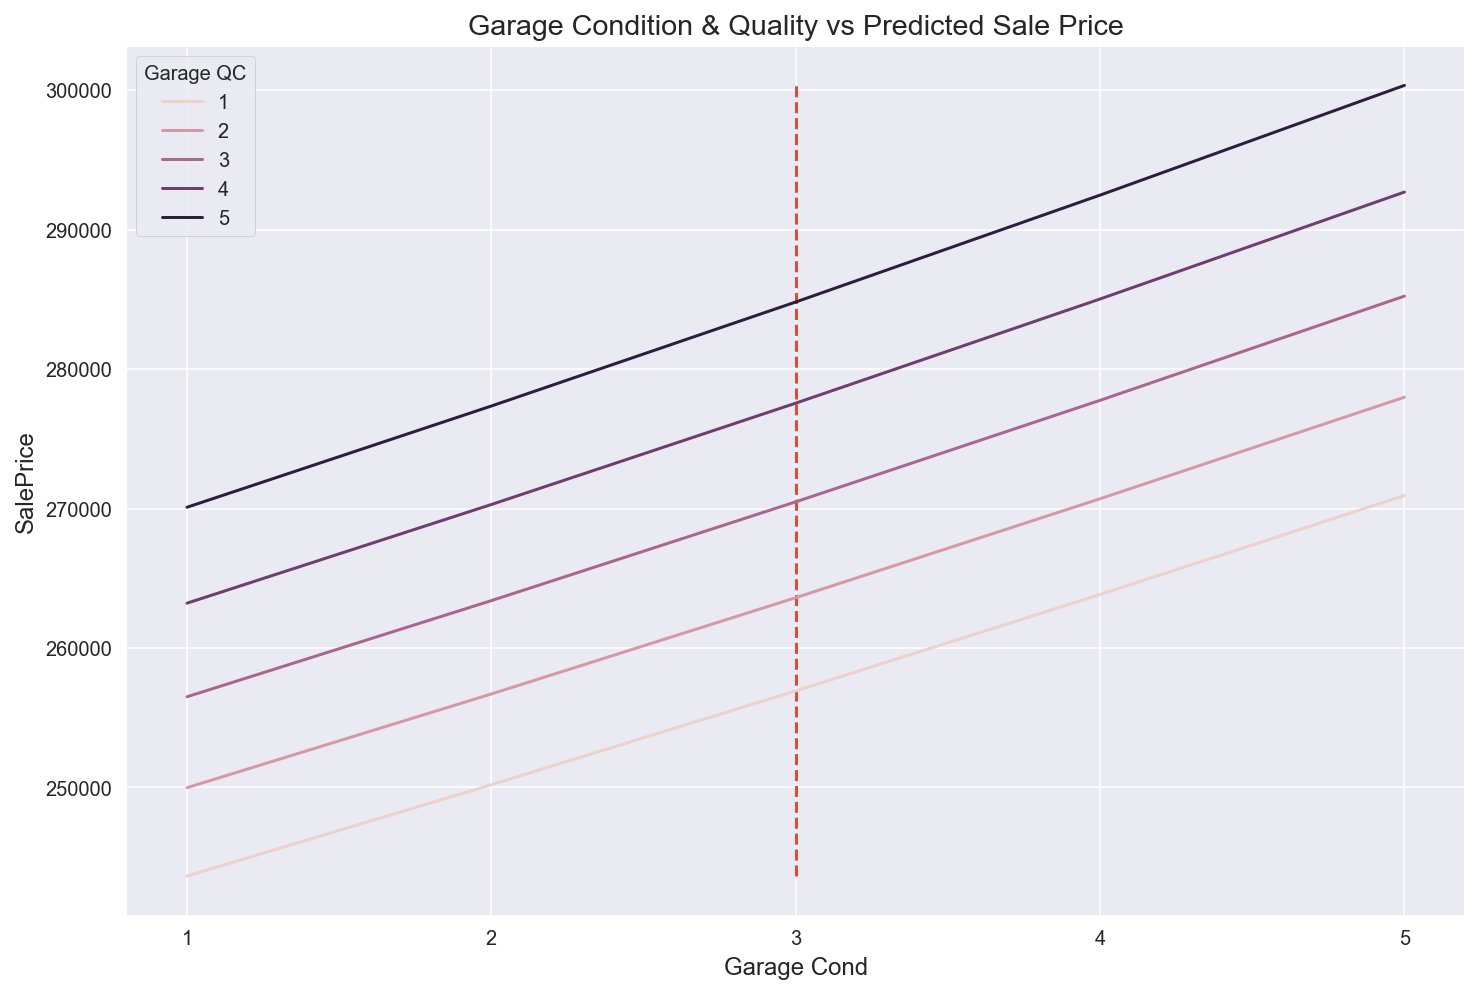

In [133]:
plt.figure(figsize = (12,8))
sns.lineplot(x = 'Garage Cond',
             y = 'SalePrice',
             hue = 'Garage QC',
             data = df_submission)

plt.vlines(x = 3,
           ymin = min(df_test_processed['SalePrice']),
           ymax = max(df_test_processed['SalePrice']),
           linestyles='--')

plt.xticks(range(1,6,1))

plt.title('Garage Condition & Quality vs Predicted Sale Price');

# 7.0 Conclusion
___

- Actual Qualitative Application
    1. In the `Section 6.0` Example , we were able to use our client baseline house condition, together with our Model to demostrate how variation of the feature affect the Sale Price. From `Section 6.2` , we had demostrate that if Alan (our client) were to renovate and improve his house condition from 5 to 7 , we predict he should be able to increase his Sale Price from `$270,000` to `$292,000` , a 8% potential increase.
    2.Overall , we were able to generate a model to advise our client what house features they could improve , and the qualitative correlation to the Sale Price. We could use our model to run on multiple features that had demostrated strong relation as demostrated in `Section 6.2` and `Section 6.3`
    3. We had also reached our model's target to be able to advise our client on what action to take on their house so that they are able to increase their selling price by 5% to 10%.

- Next Step
    * `While we are able to predict qualitatively , we should also take into account that to improve a house feature, renovation budget will be required. Whether that outweighs the increase of SalePrice is not covered in this studies and could be further studies together with interior design team.`


# 8.0 Resources and Credits
___
- [A Thorough Dive into the Ames Iowa Housing Dataset.](https://medium.com/mlearning-ai/a-thorough-dive-into-the-ames-iowa-housing-dataset-part-1-of-5-7205093a5a53)
- [AMES Housing Set Dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)
- [VIF Explained](https://etav.github.io/python/vif_factor_python.html)